# This notebook plots the results of a trained GoogLeNet model on the dataset generated by the Unity environment.

It loads a trained model (.pt file) and can generate plots of the predicted location for a single image.

In [9]:
# Set the filepath of the saved trained model.
model_filename = "C:\\Users\\LB\\Desktop\\scriptie\\model\\DATASETsolo250kv2EPOCHS50.pt"

# Set the filepath to the test dataset.
dataset_path = "S:\\datasets\\solo100v2"

In [10]:
# Import dependencies.
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from UnityDataset import CustomData

torch.manual_seed(17)

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = CustomData(dataset_path, transform=transform)
test_data, _ = torch.utils.data.random_split(dataset, [100, 0])

Did not find JSON file, generating metadata...
finished setting up dataset
Items in dataset: 100


In [12]:
batch_size = 1
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

## Define the model.

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class InceptionBlock(nn.Module):
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

class Auxiliary(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=(61 * 91)):
    # def __init__(self, in_channels=3, use_auxiliary=True, num_classes=100):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)

        return x, y, z

## Load the pre-trained model.

In [16]:
model = Inception()

if os.name == "nt":
    model.load_state_dict(torch.load(model_filename))
else:
    model.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
#move the model to the device
criterion = nn.CrossEntropyLoss()
model.to(device)
model.eval()

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=5551, bias=True)
  (auxiliary4a): Auxiliary(
    (avgpool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv1x1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    

In [19]:
predictions = []
for image, label in test_loader:
    inputs = image.to(device)

    labels = label.to(device)

    # optimizer.zero_grad()

    with torch.set_grad_enabled(False):
        outputs, _, _ = model(inputs)
        _, preds = torch.topk(outputs, 10)
        predictions.append((preds, label))


In [20]:
def get_location(x):
    return x % 91, x // 91

def gradient(x):
    return 1 / ((x + 1) * (x + 1))

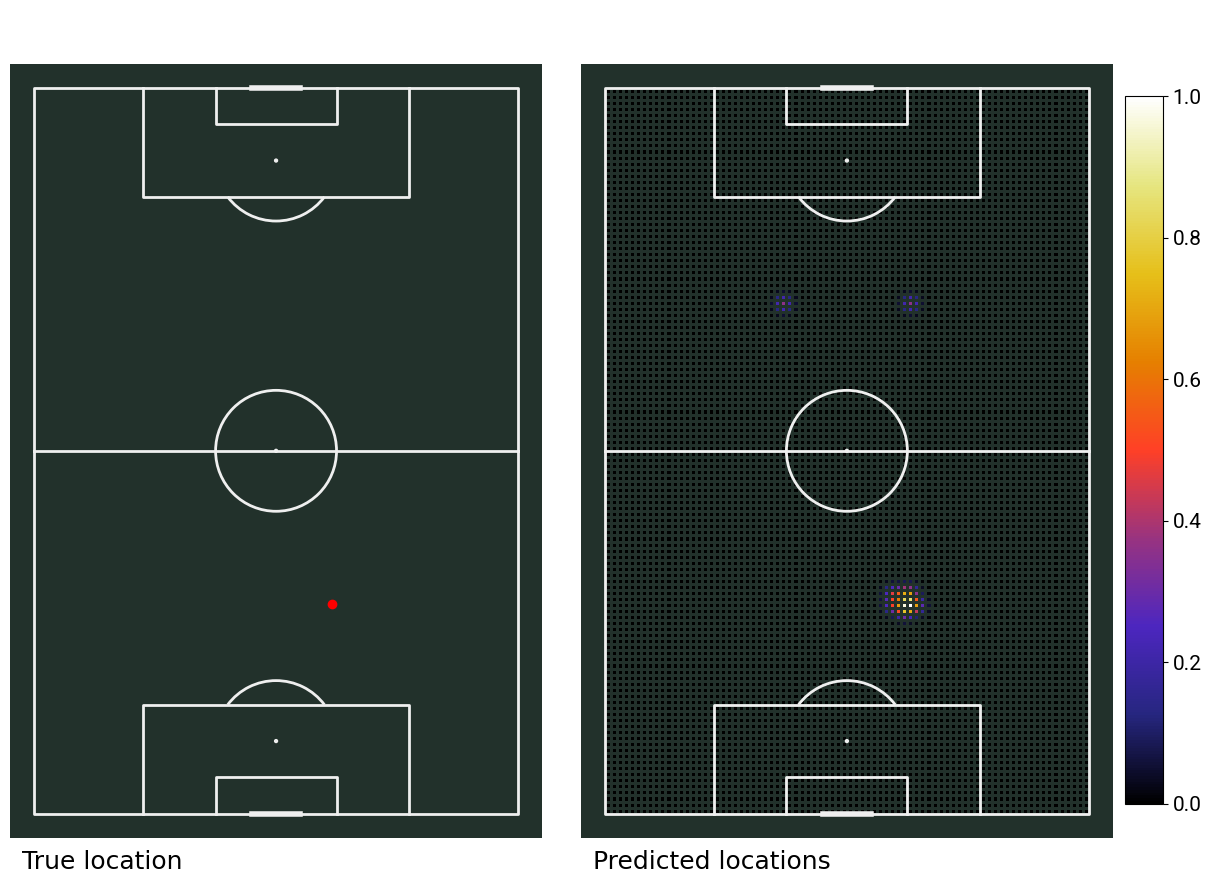

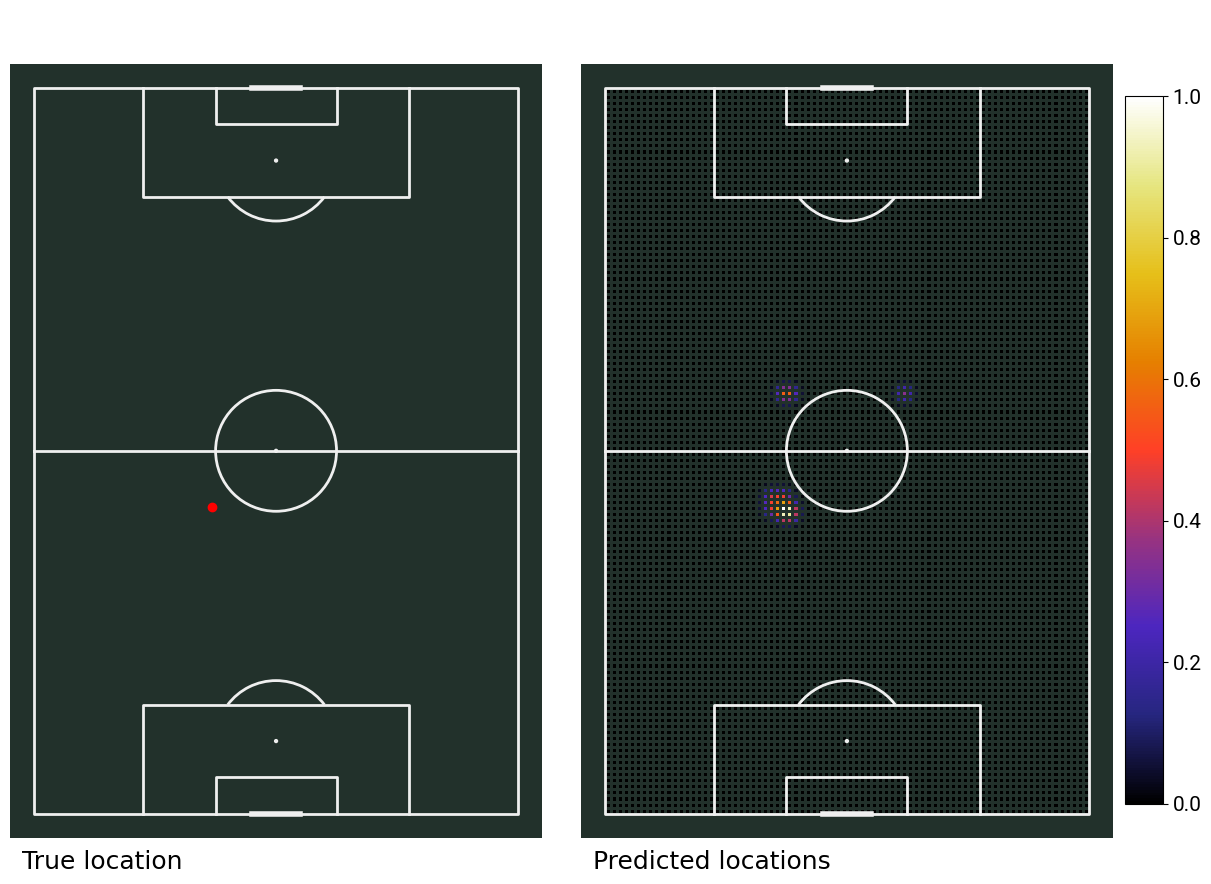

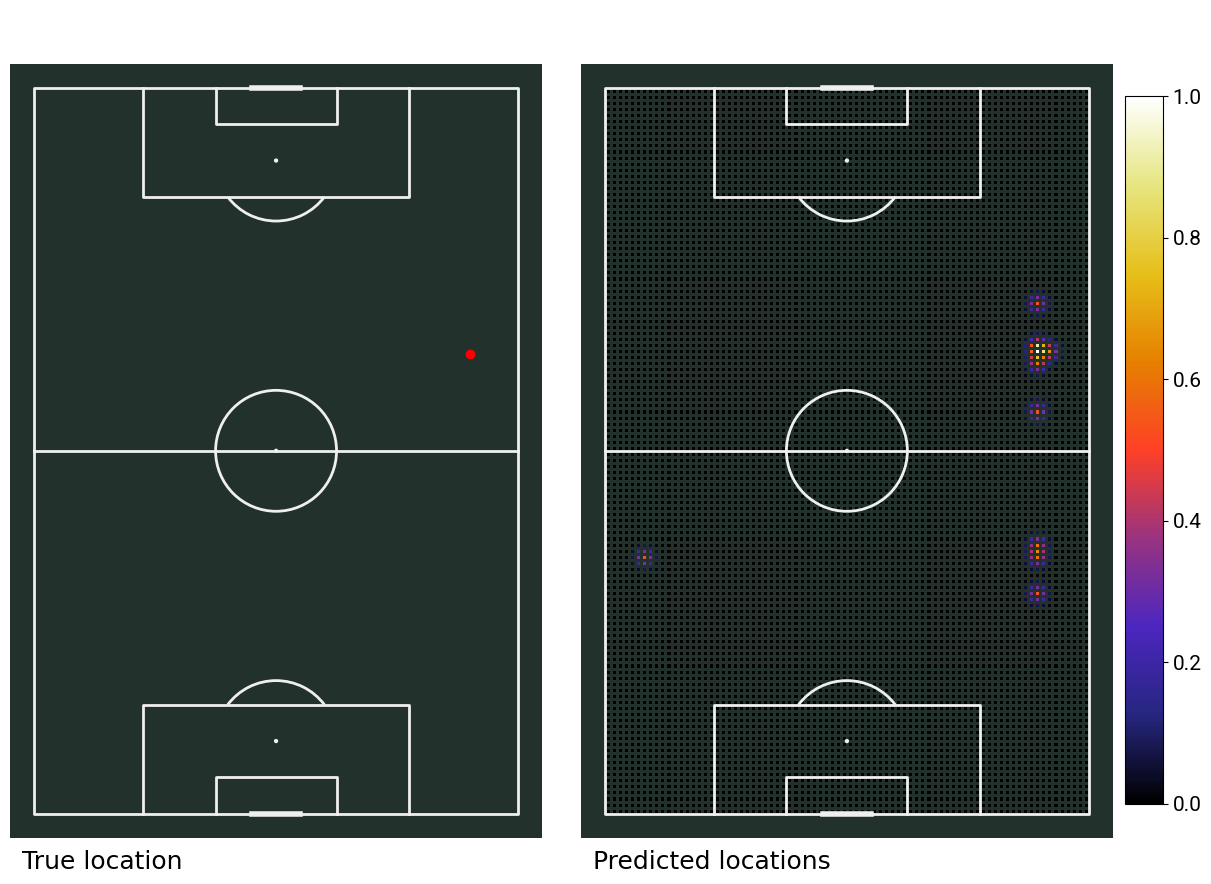

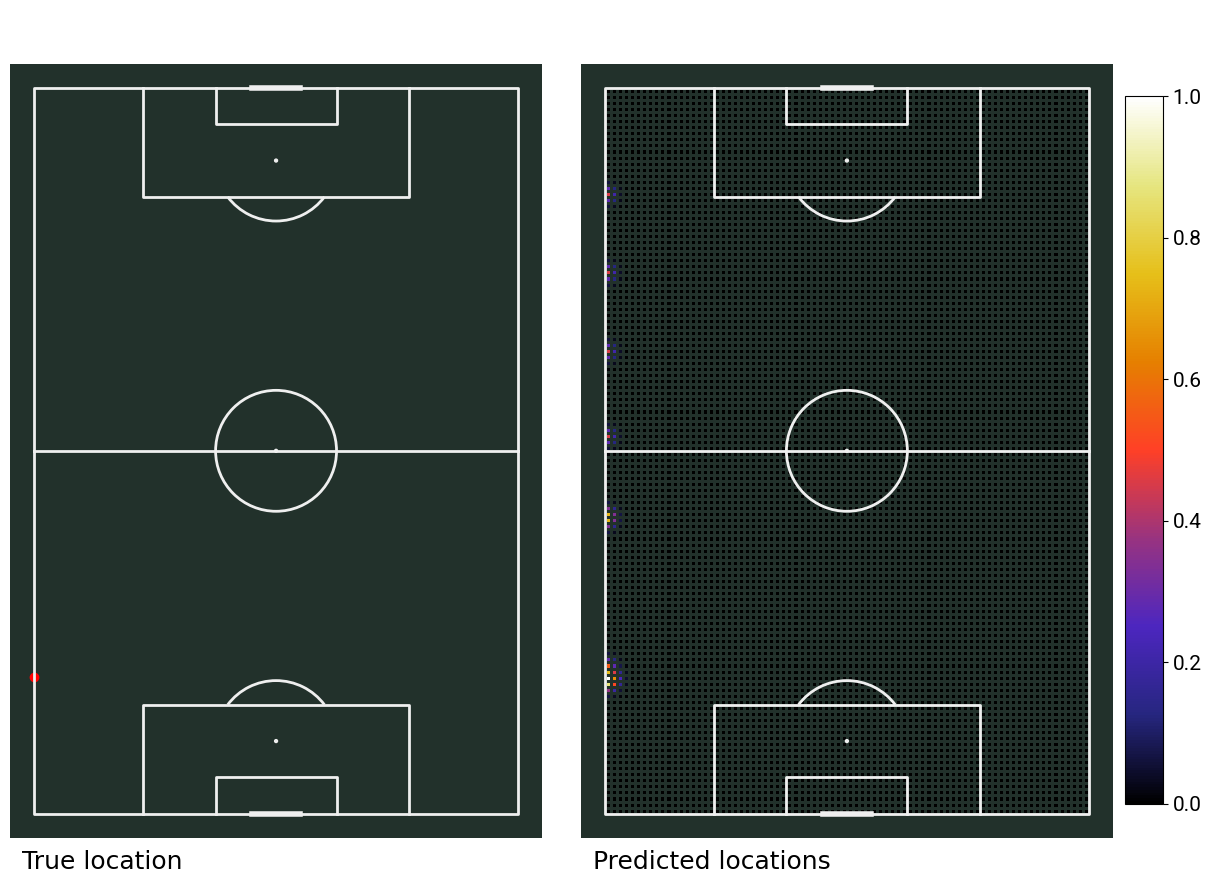

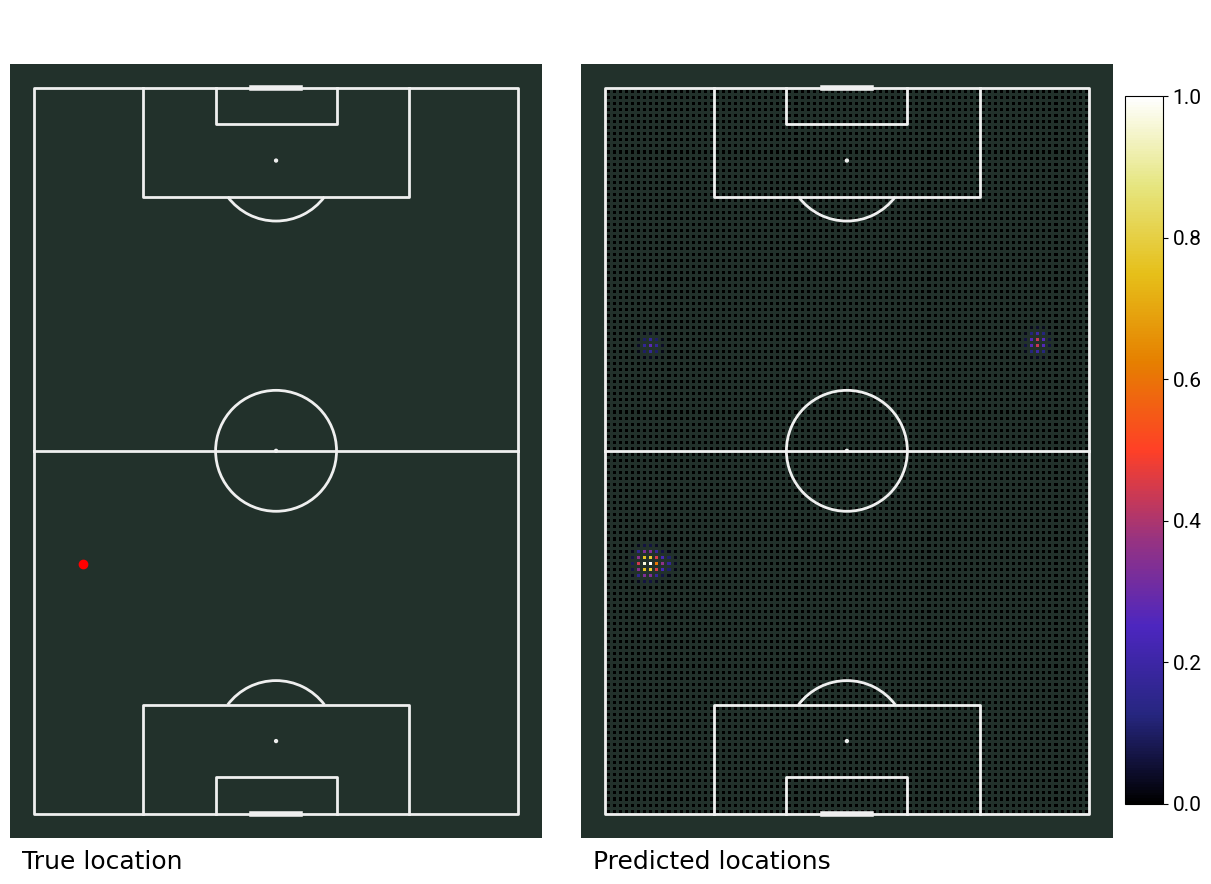

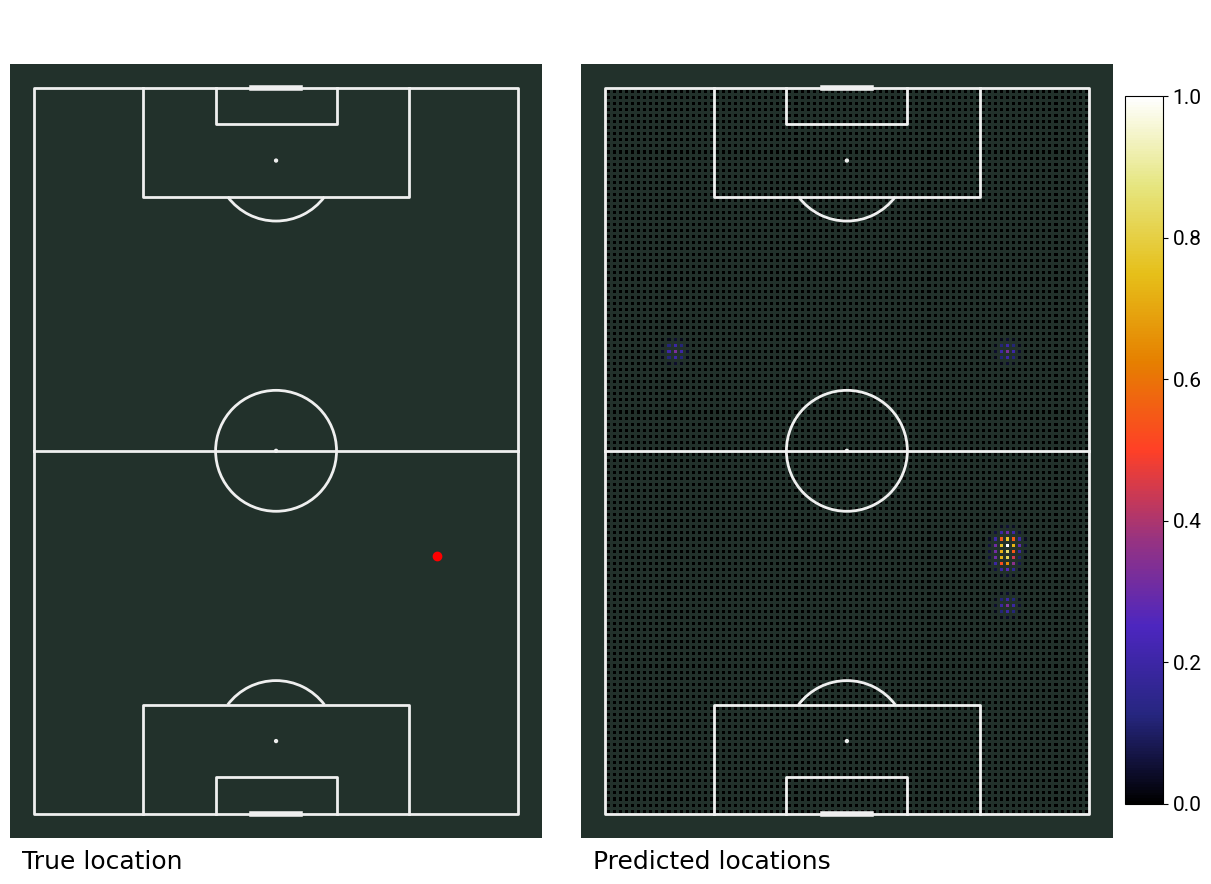

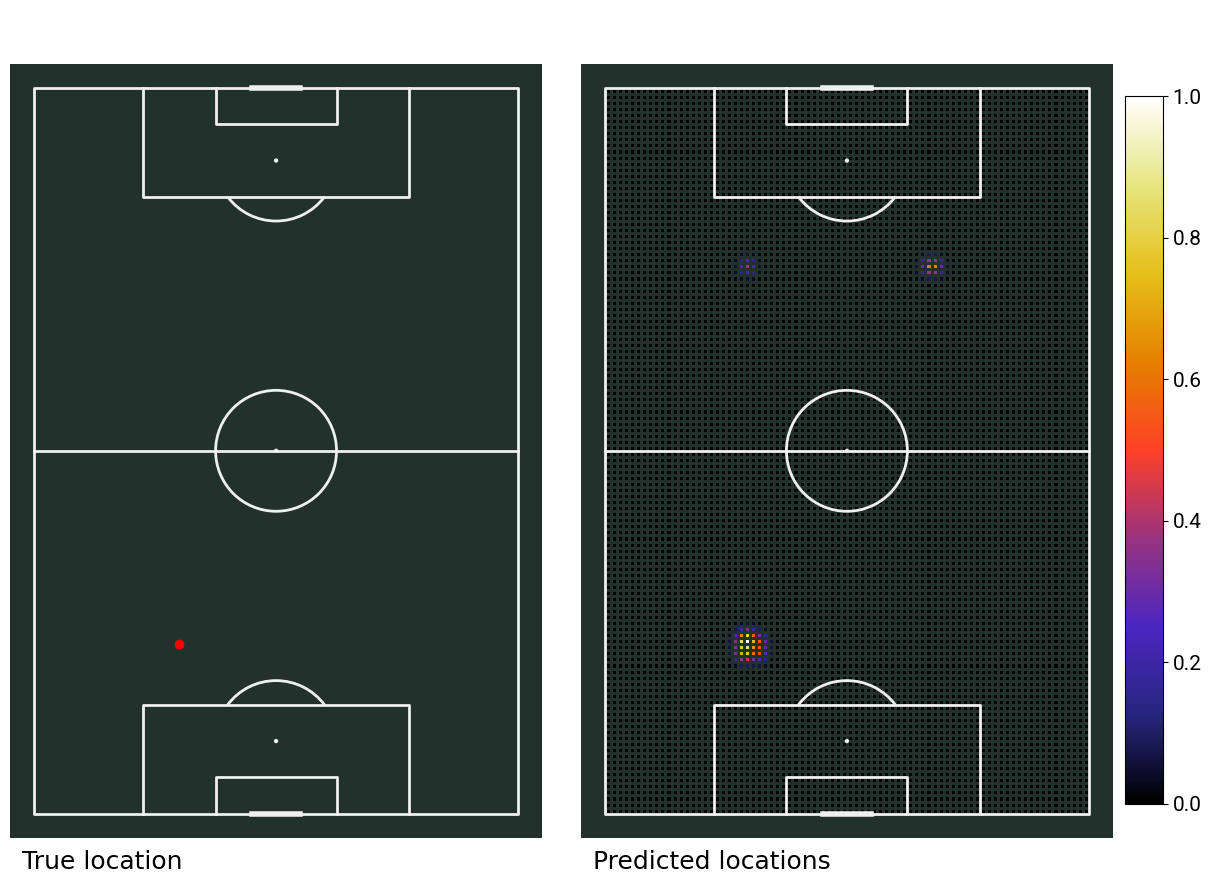

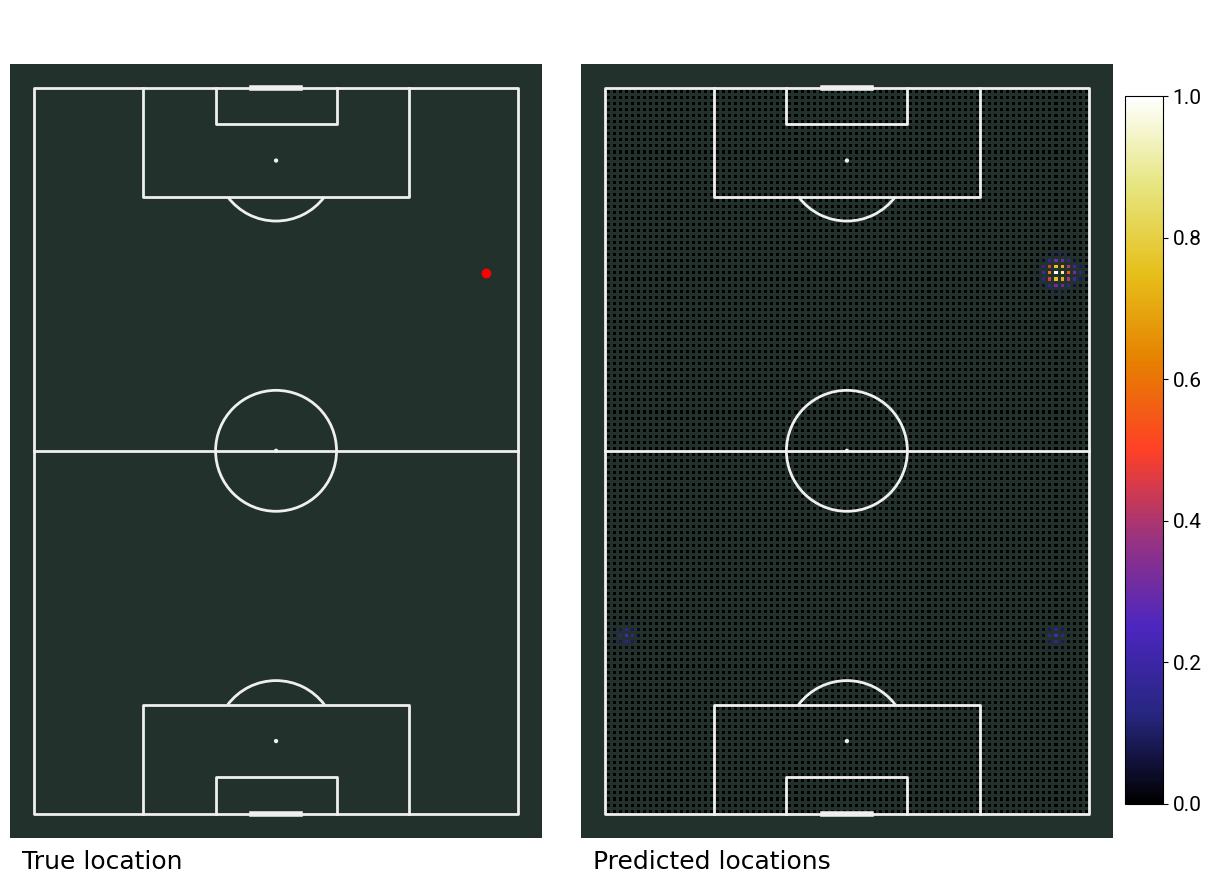

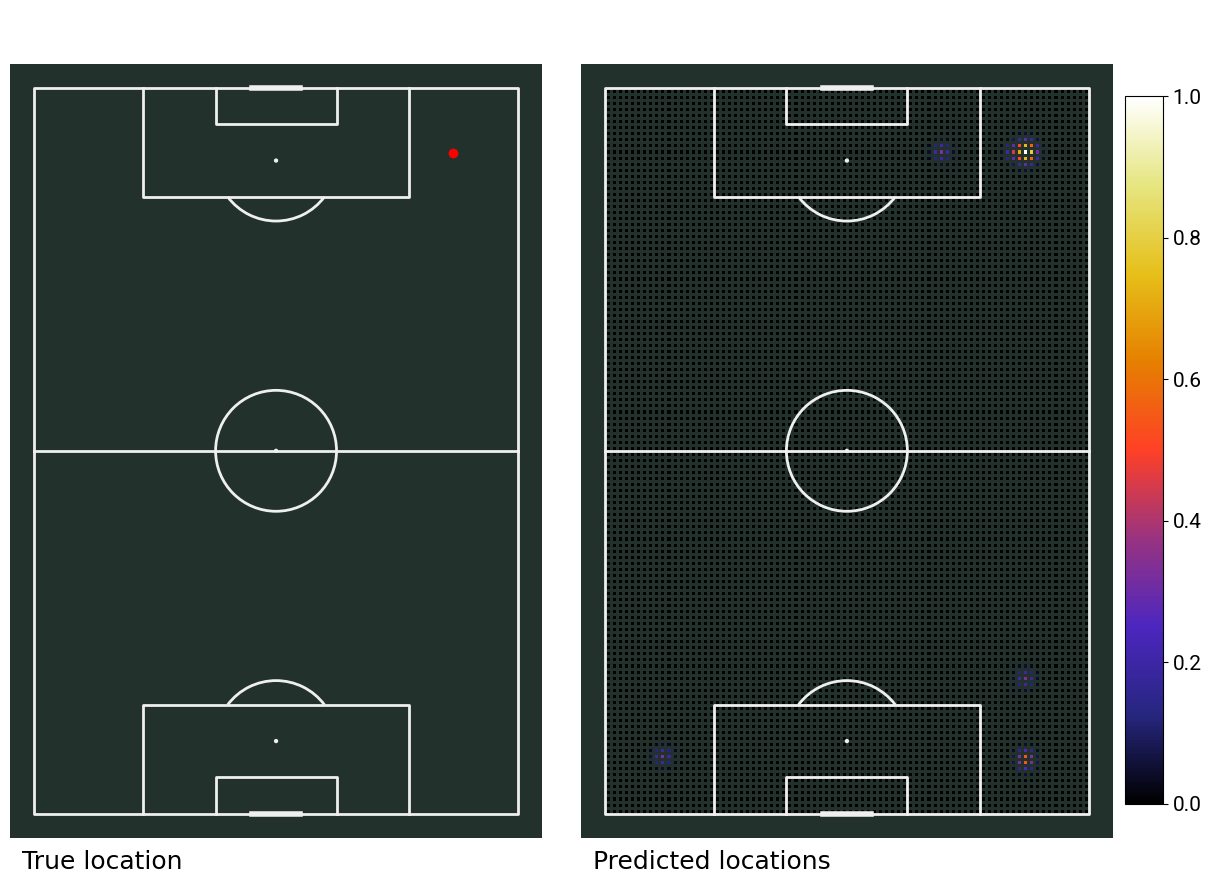

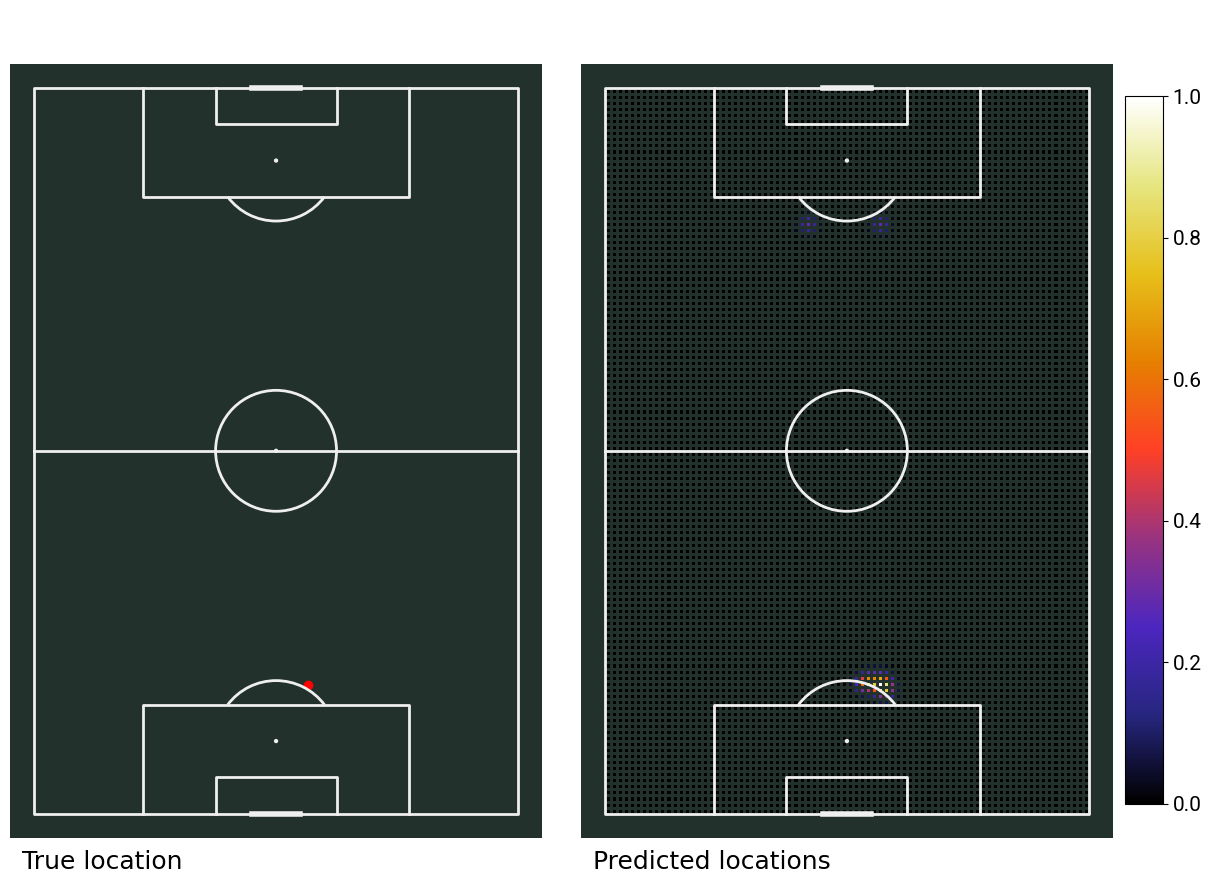

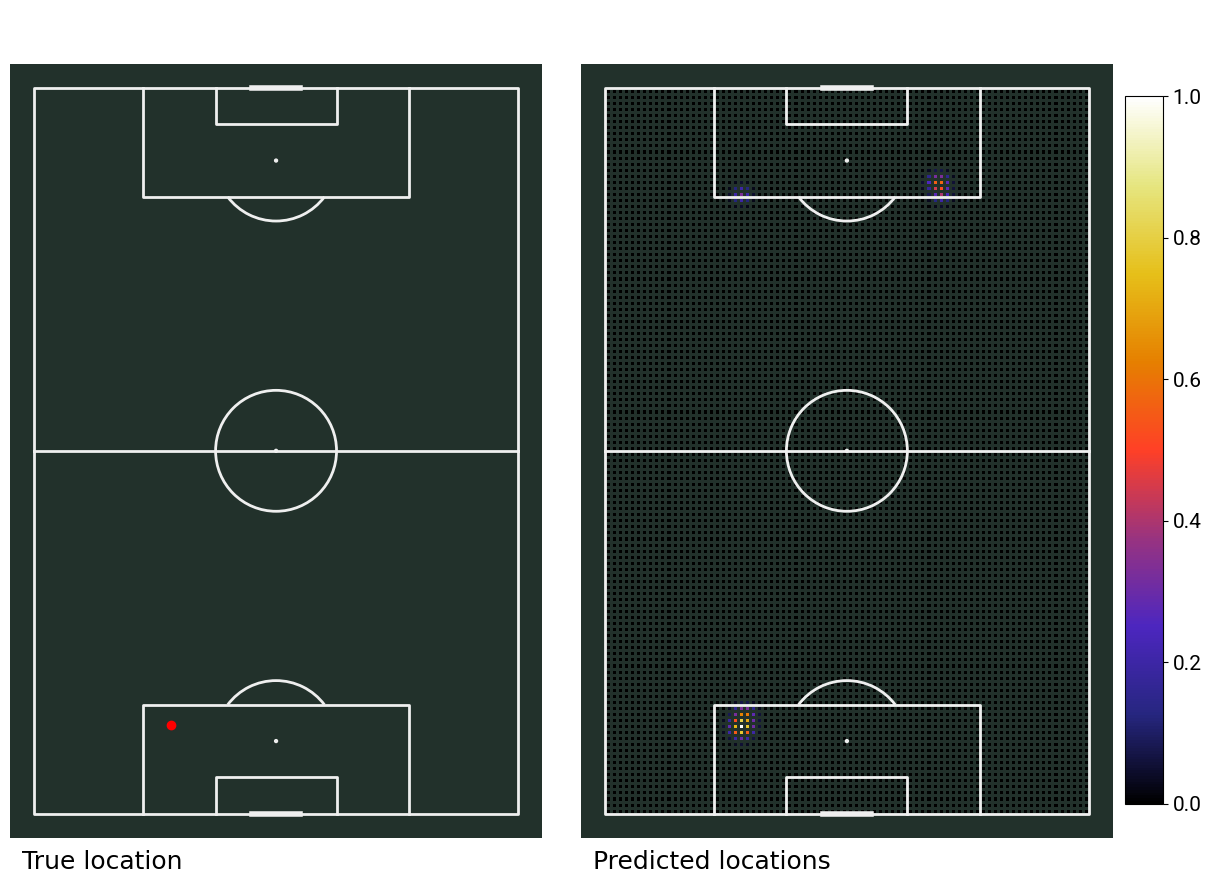

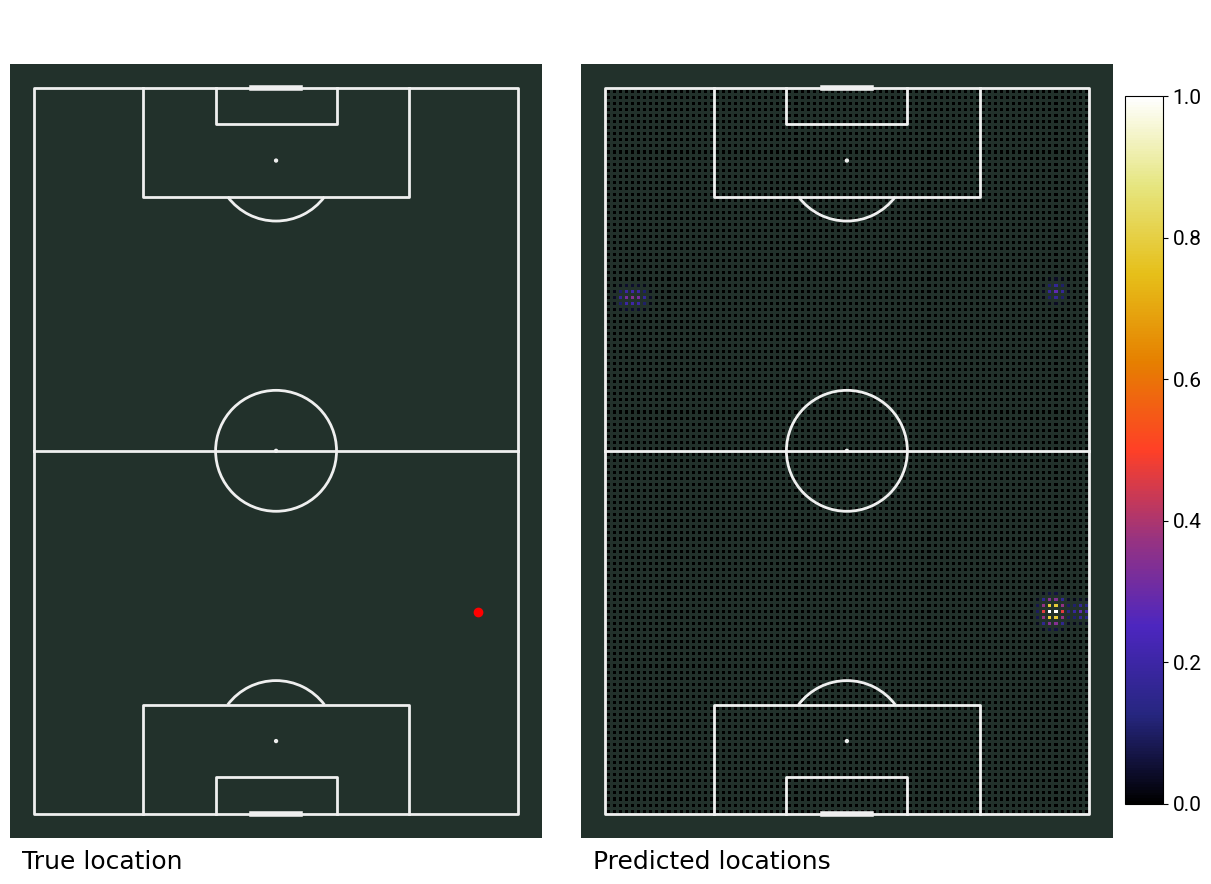

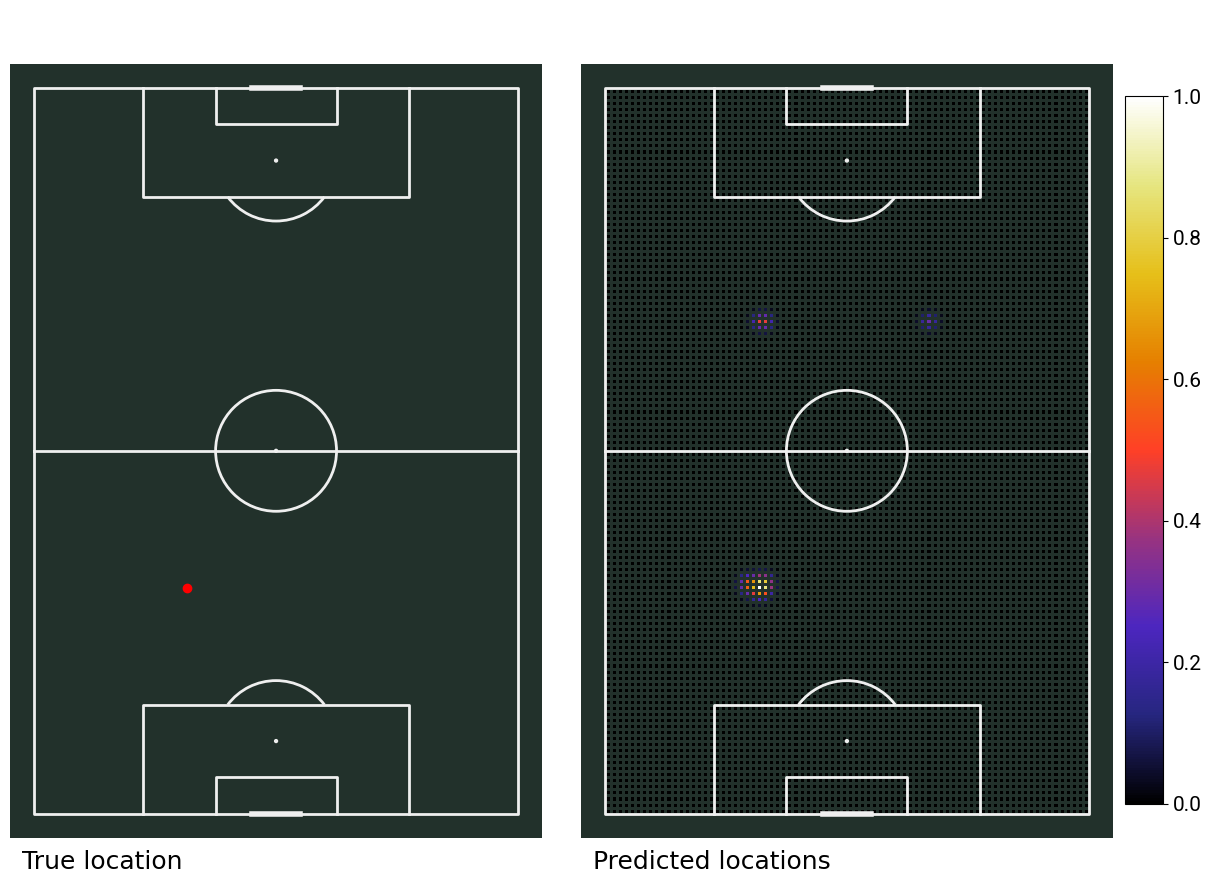

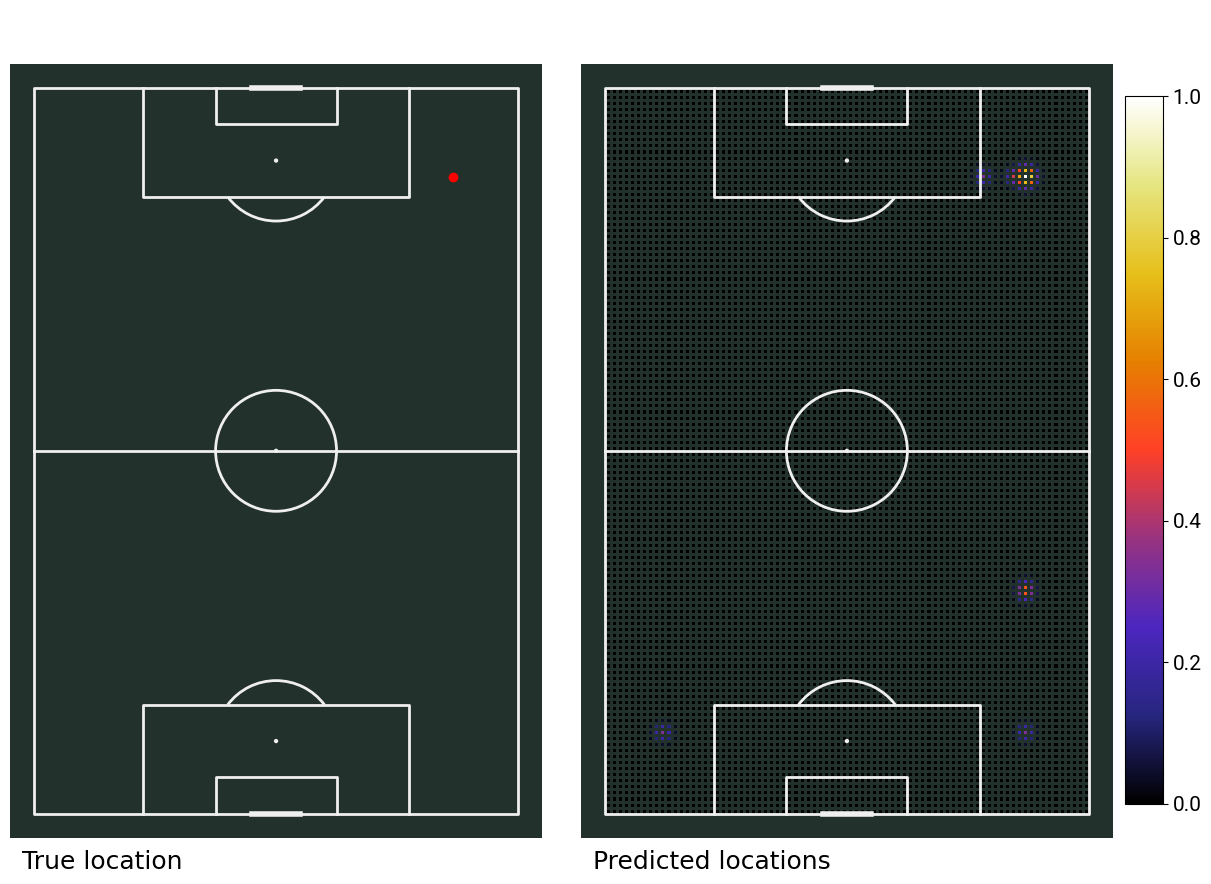

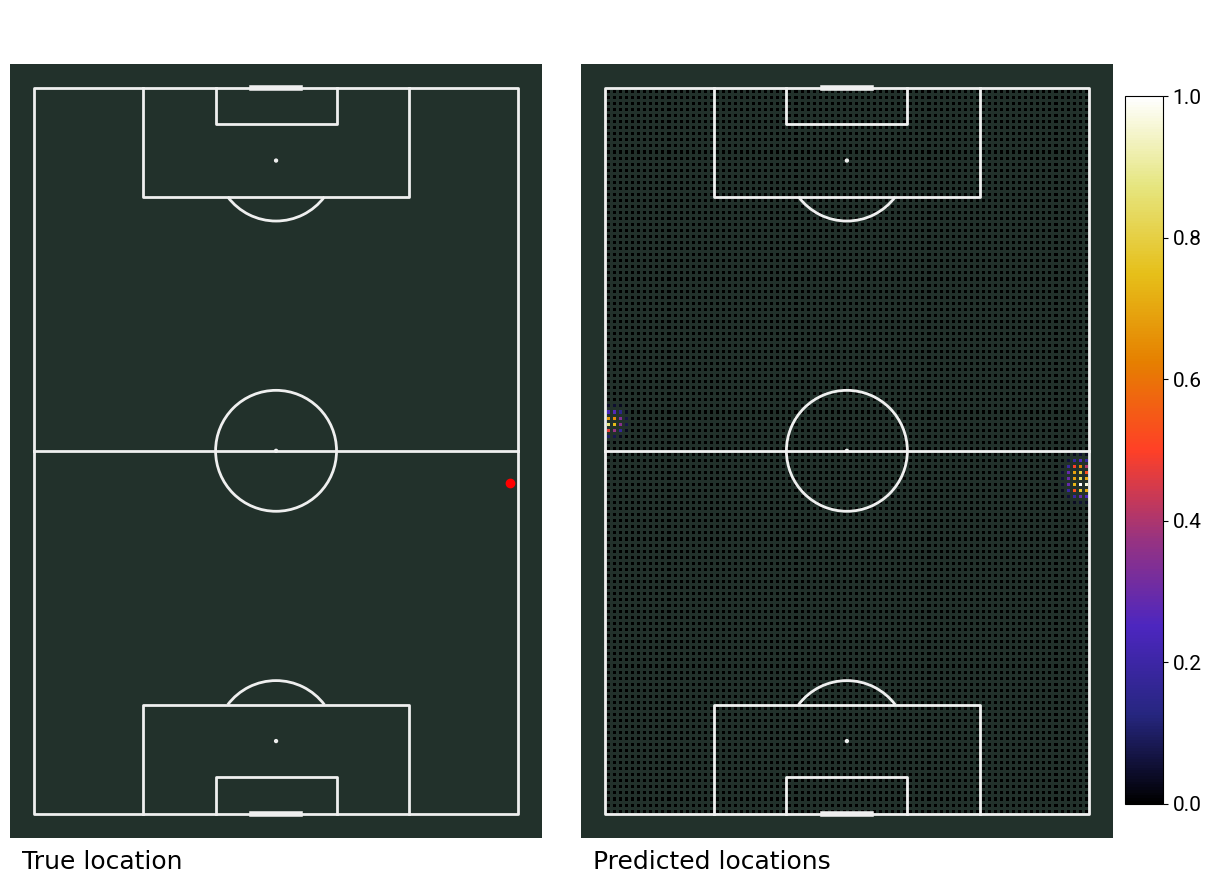

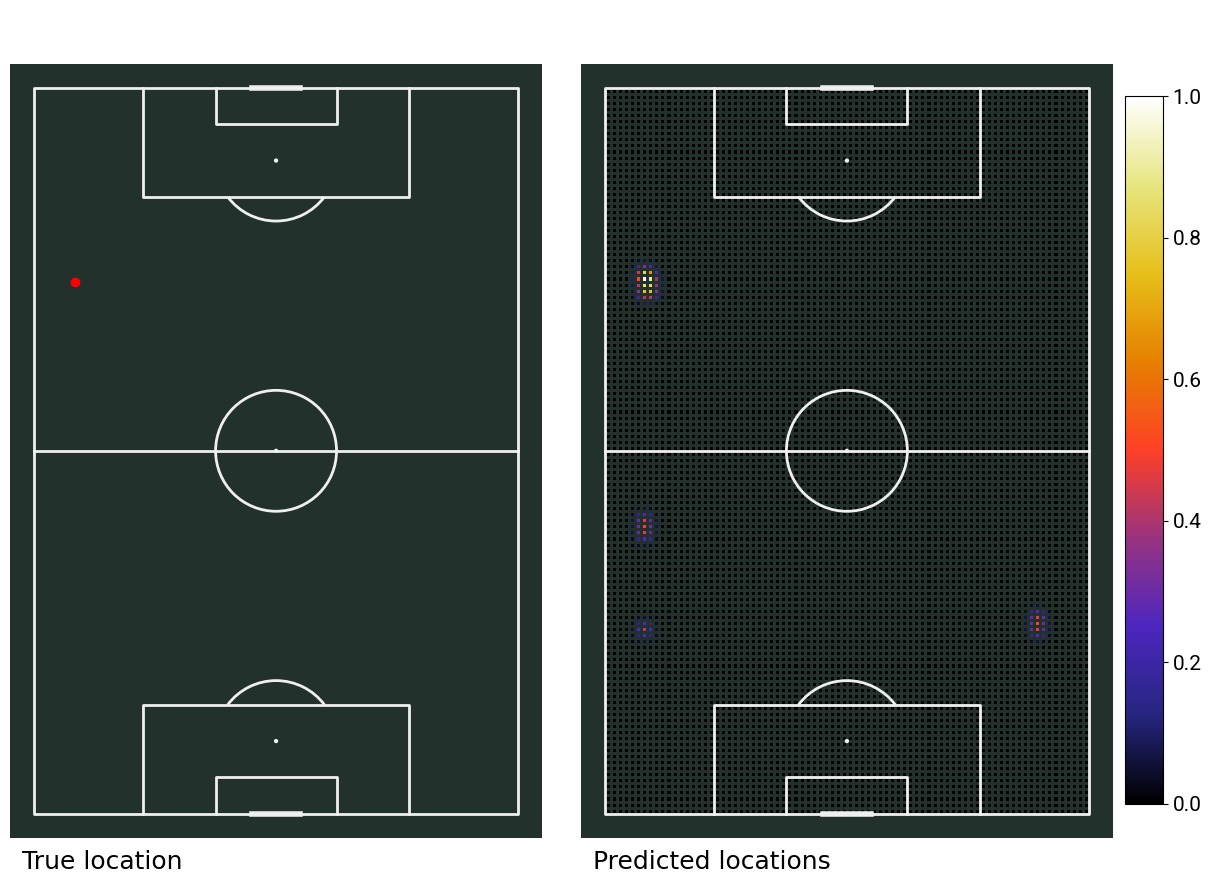

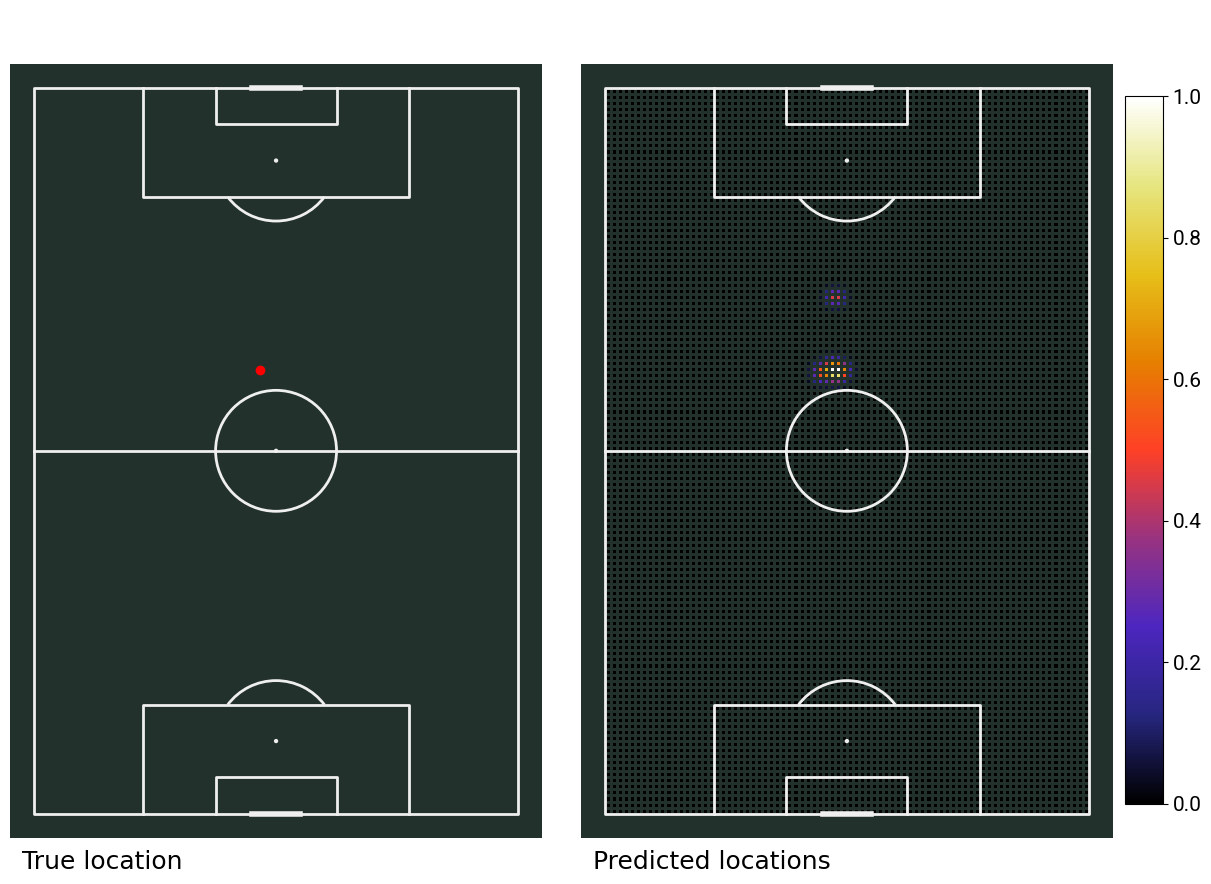

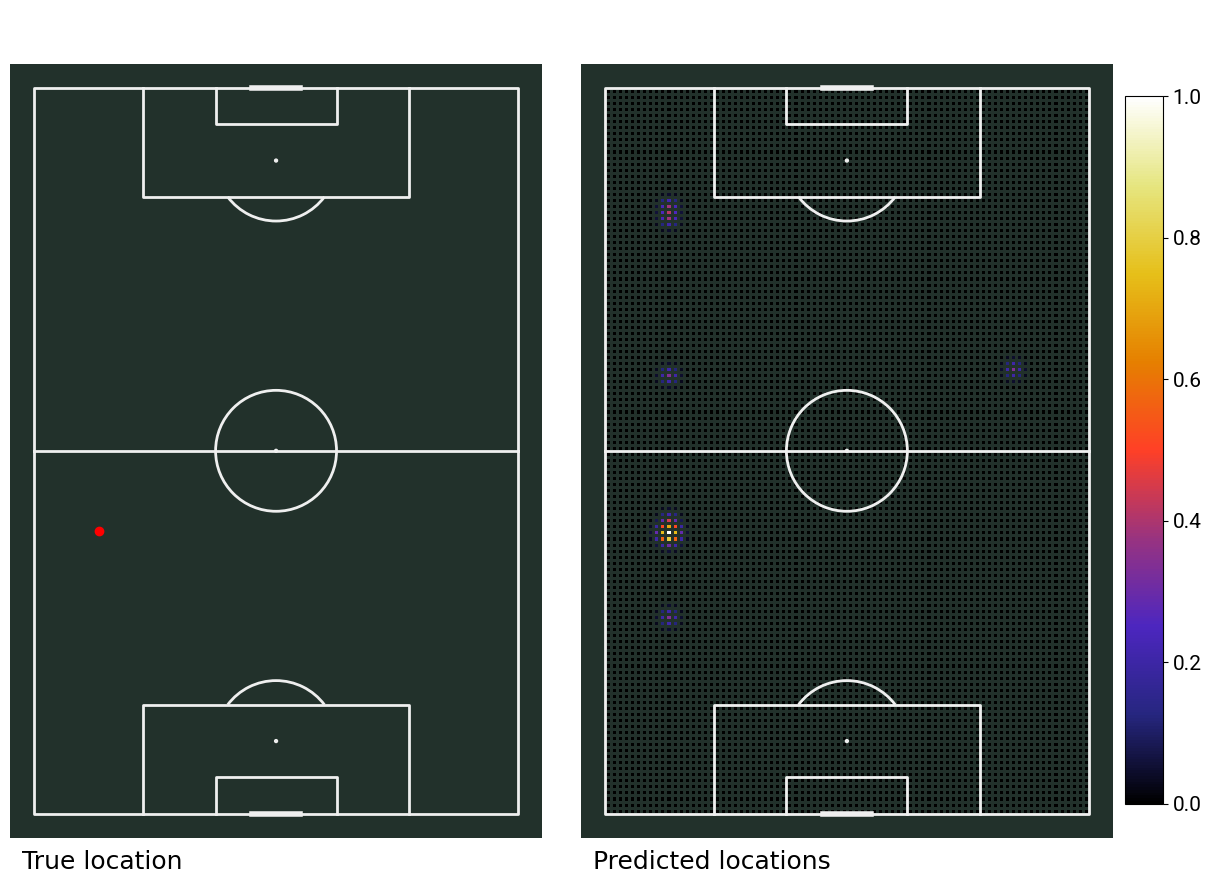

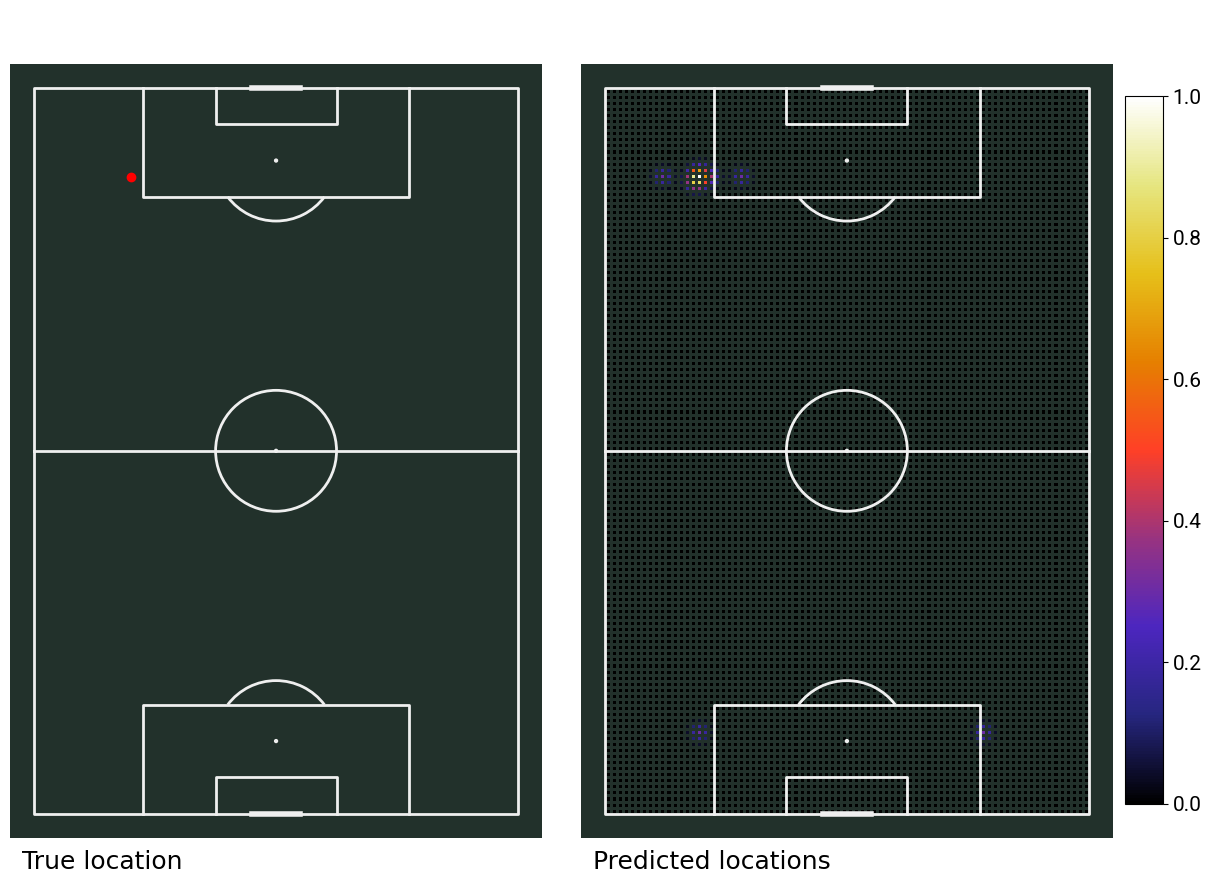

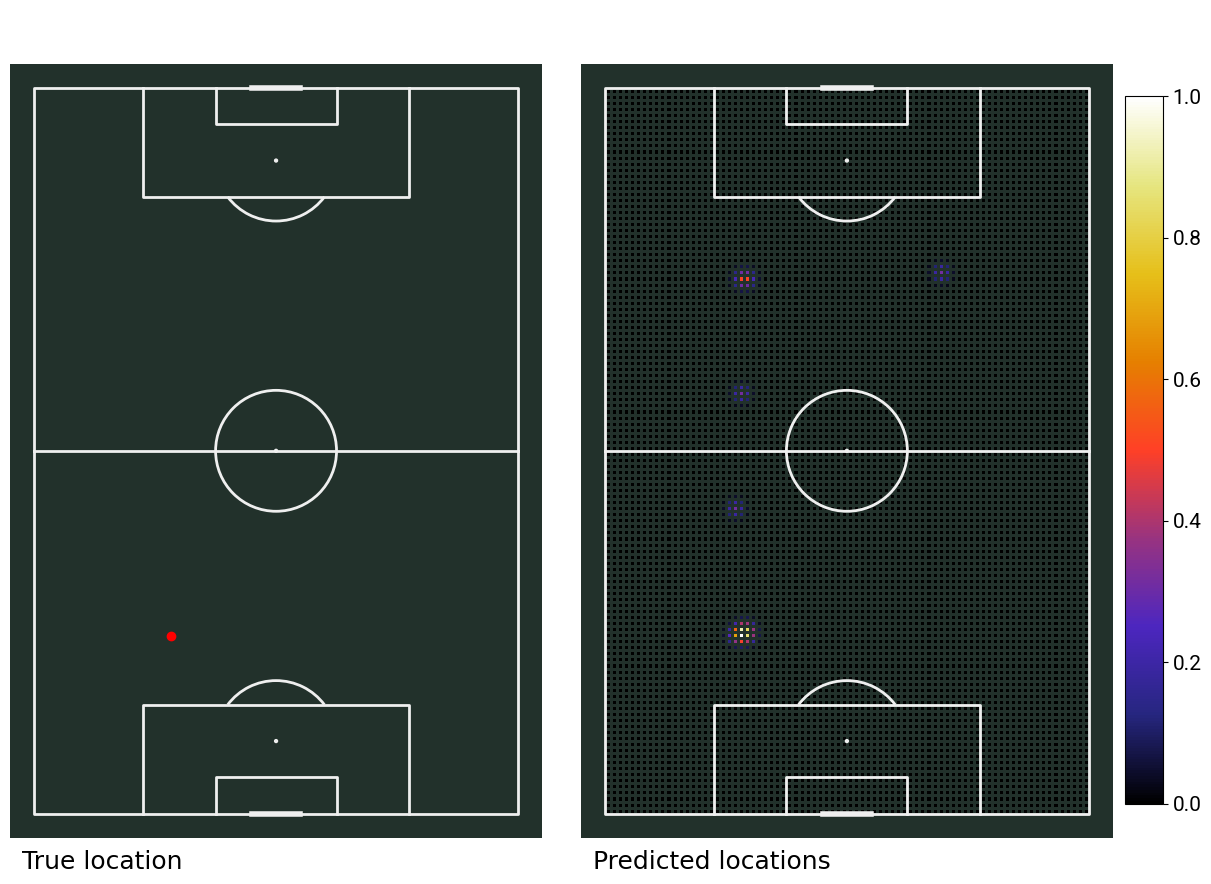

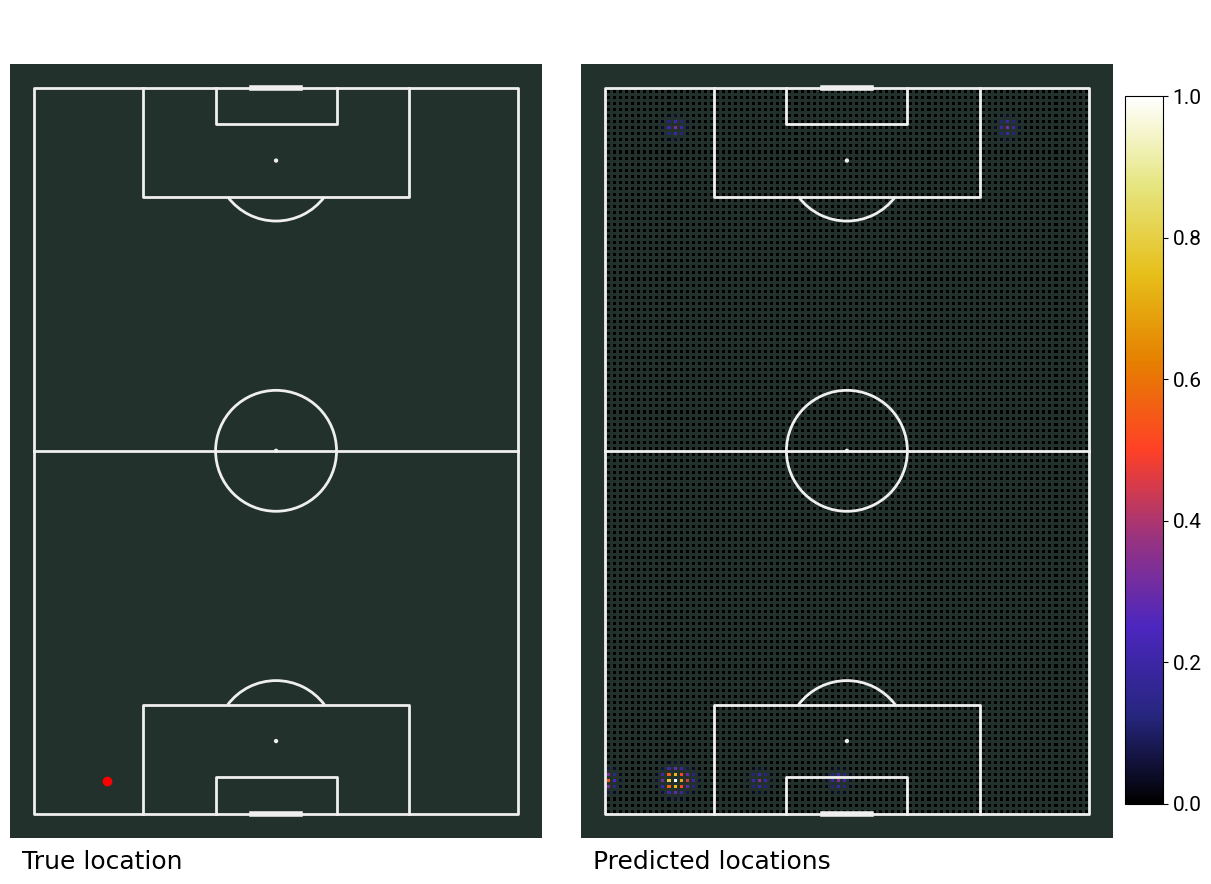

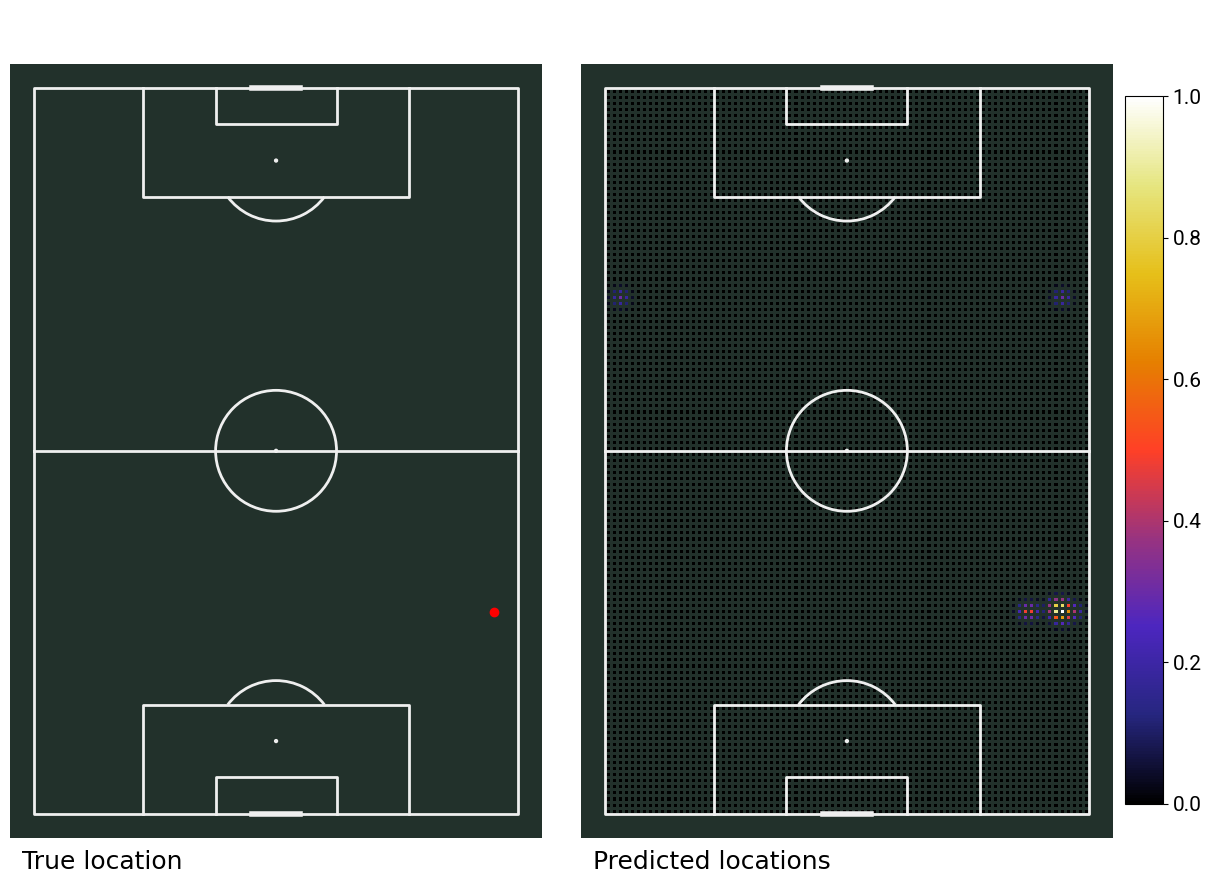

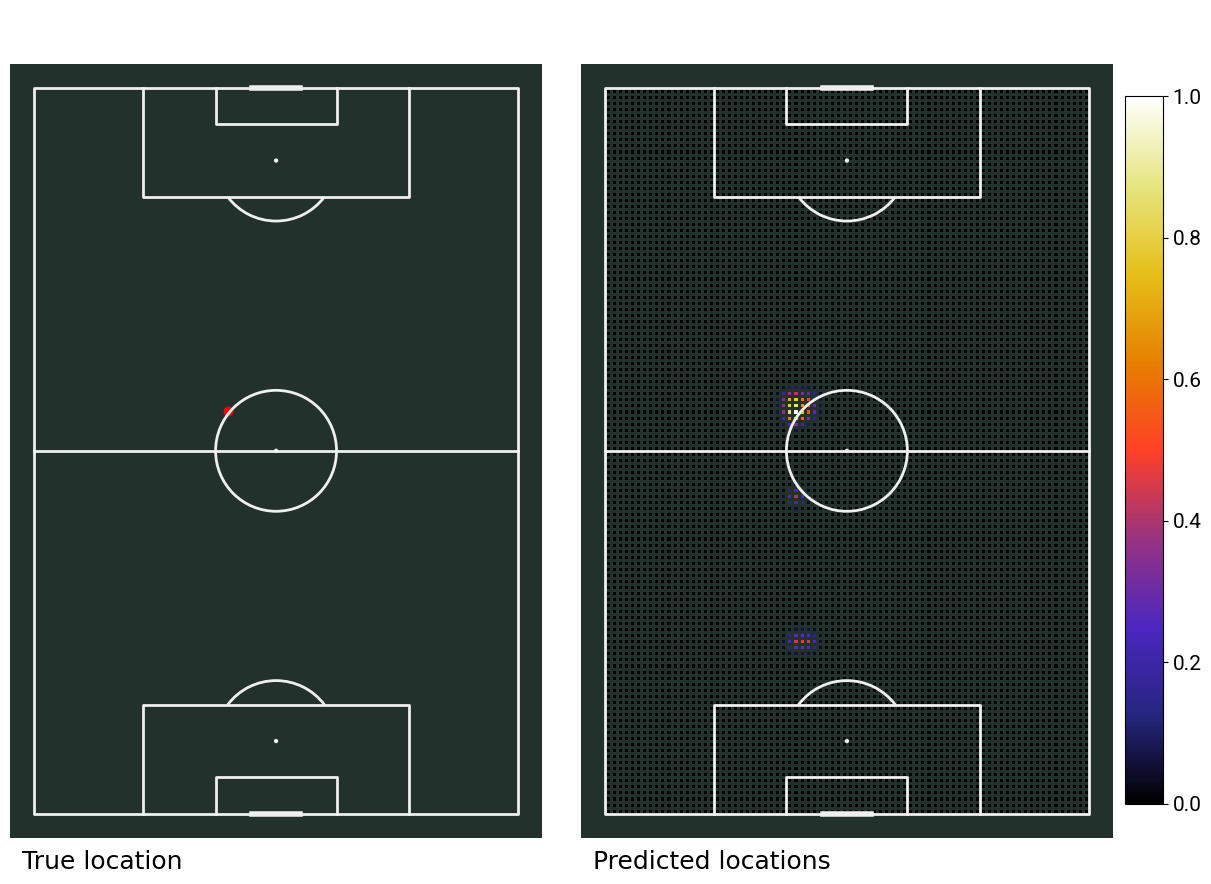

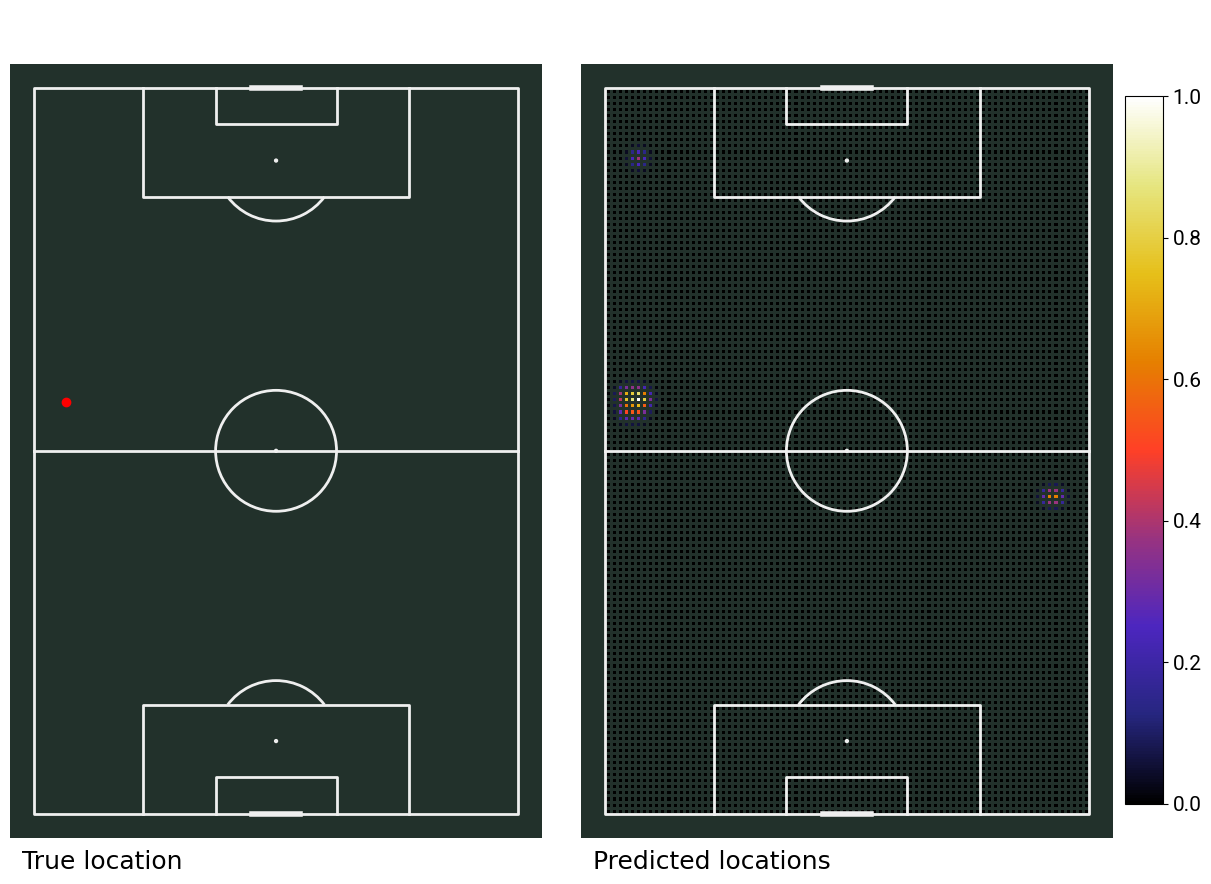

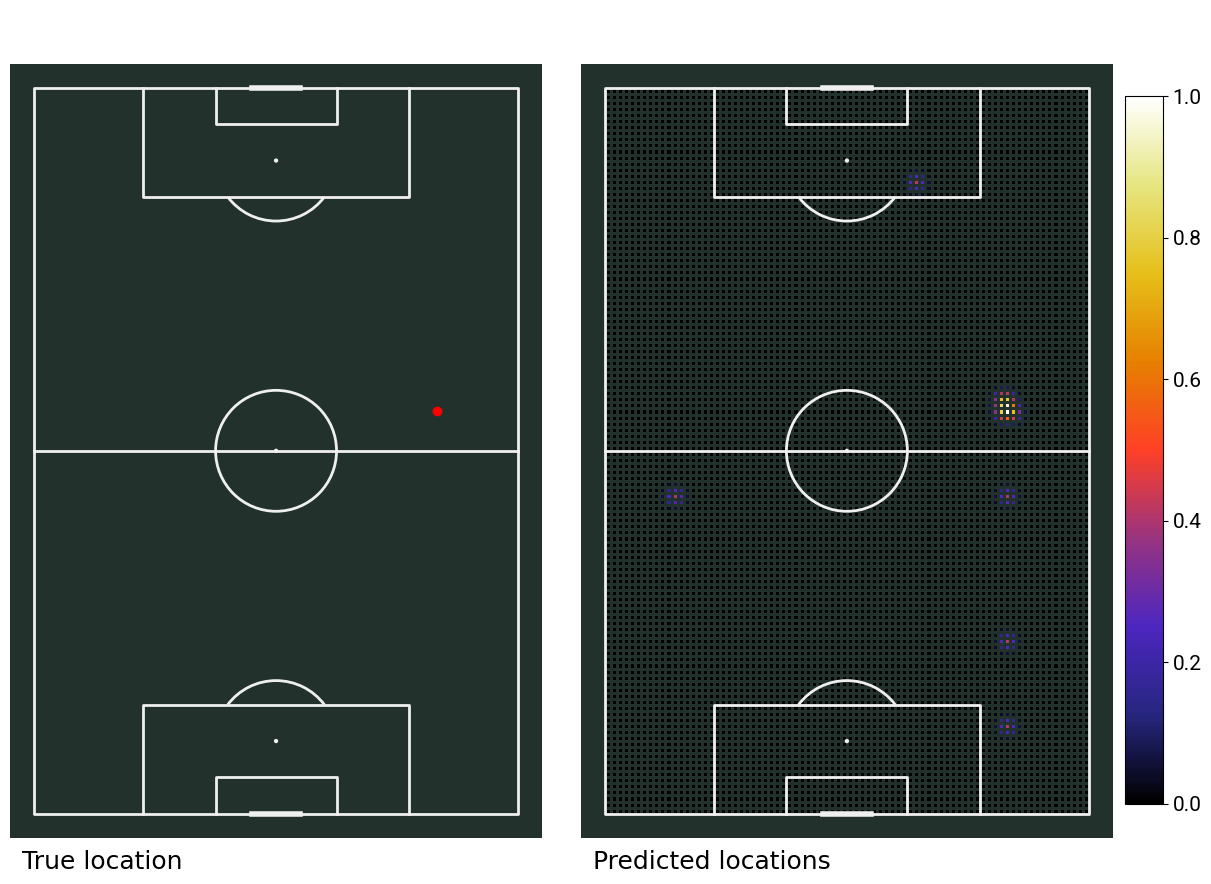

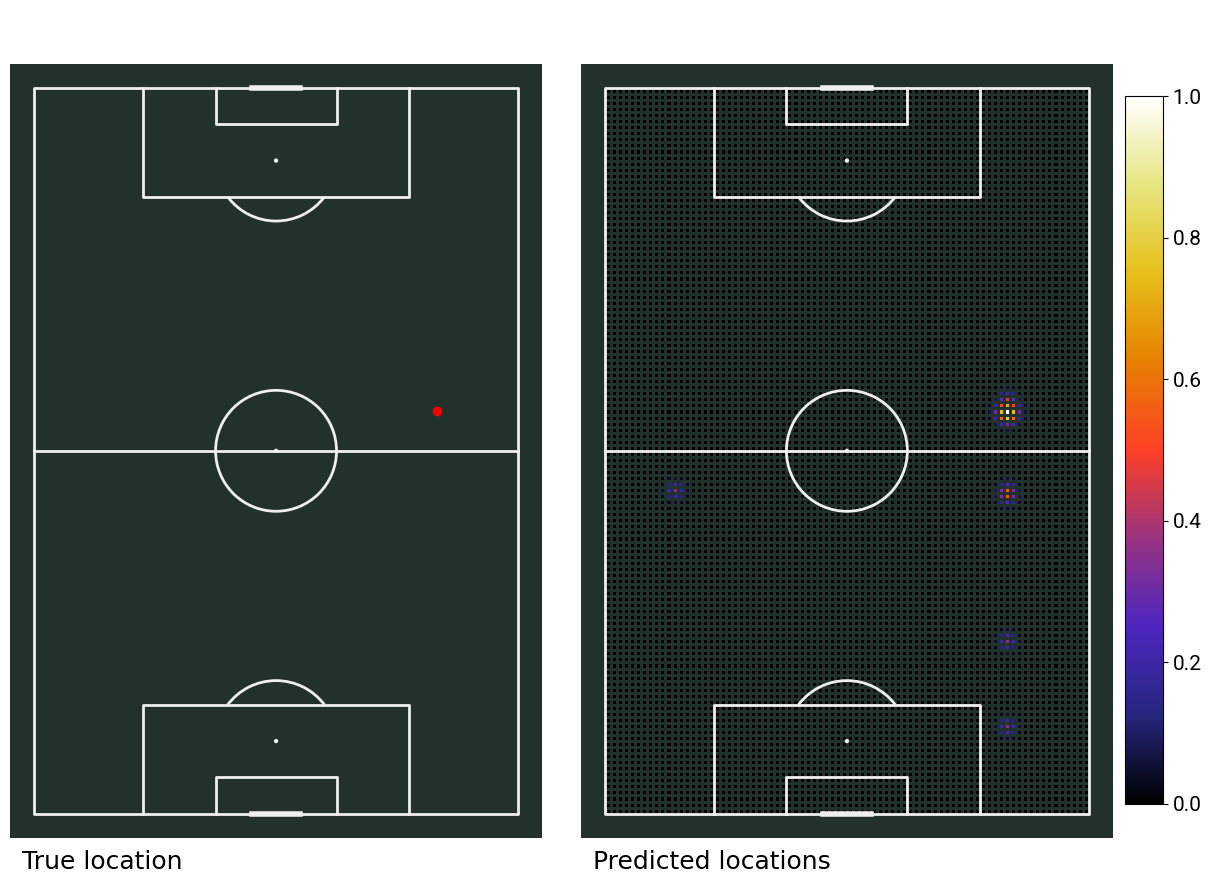

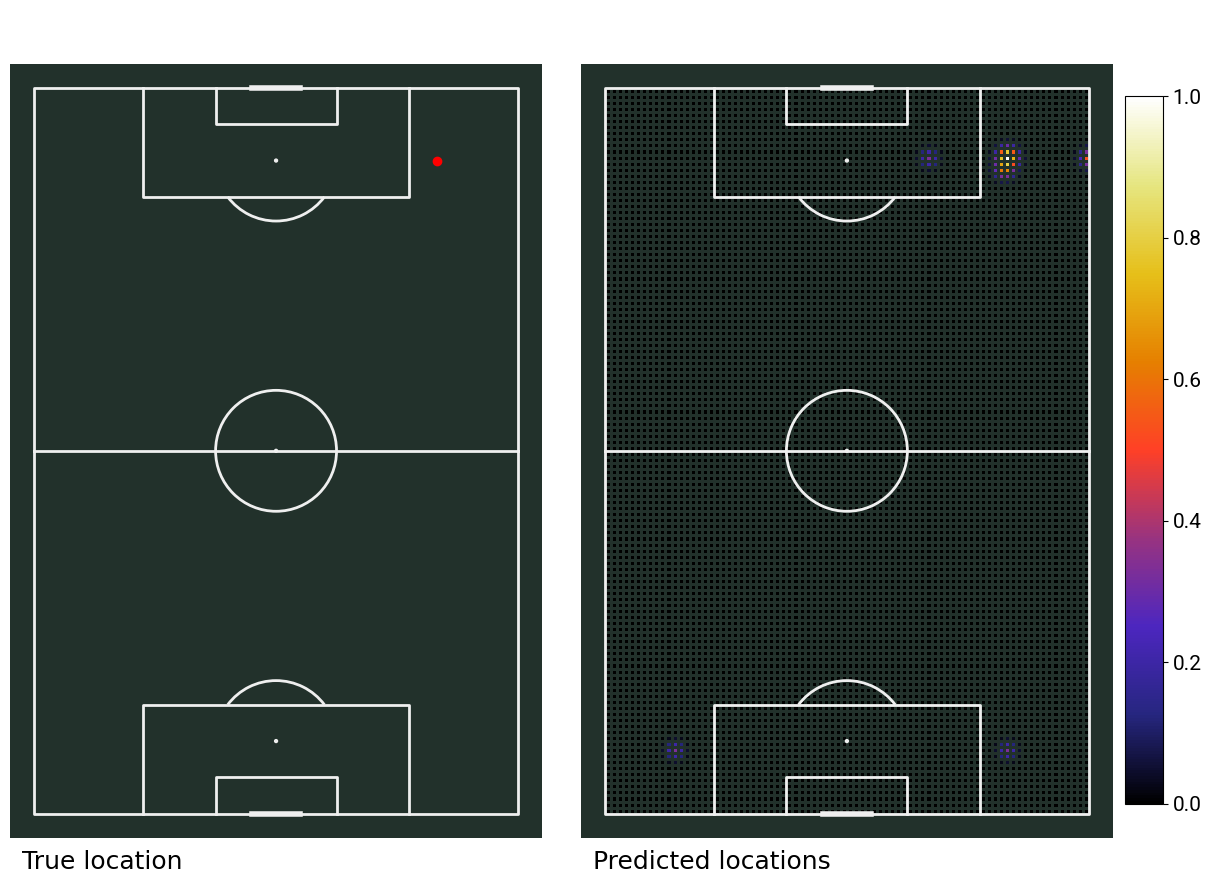

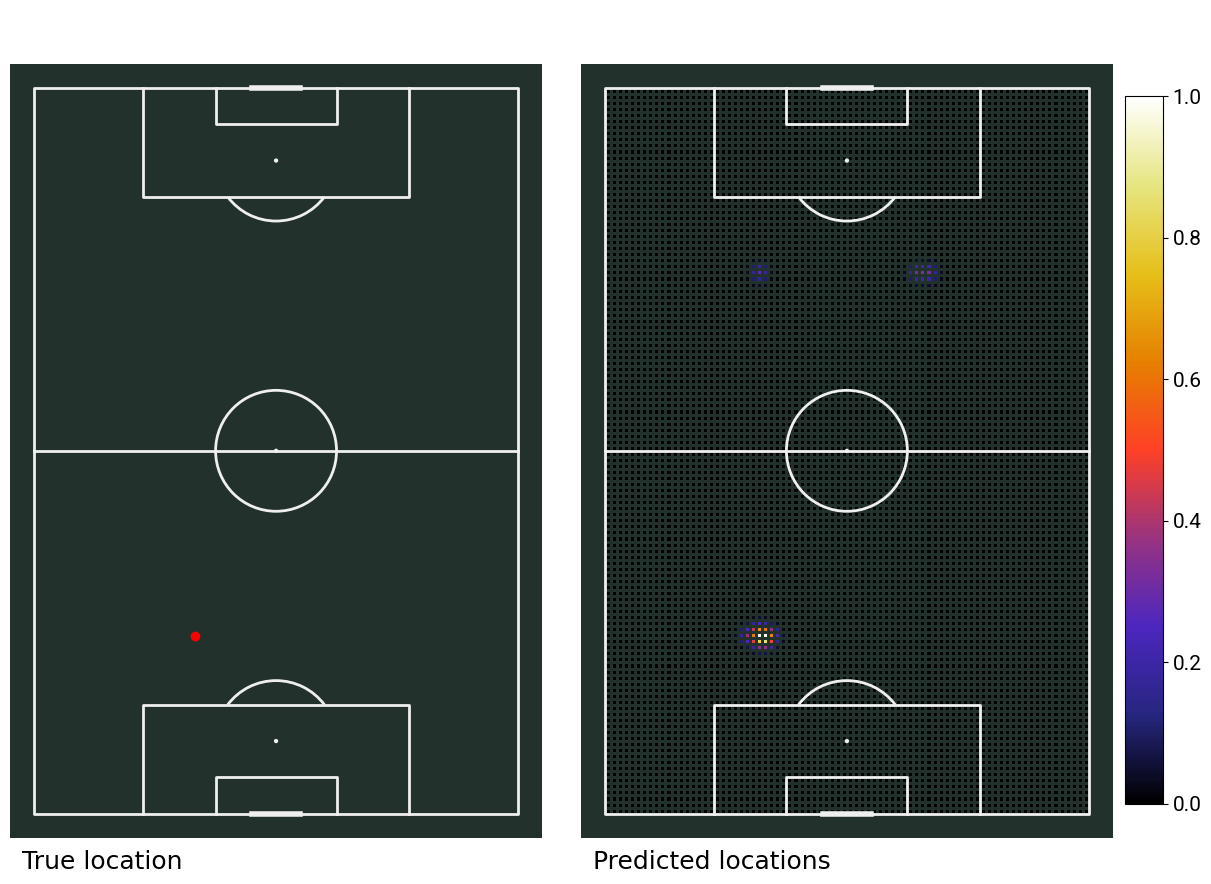

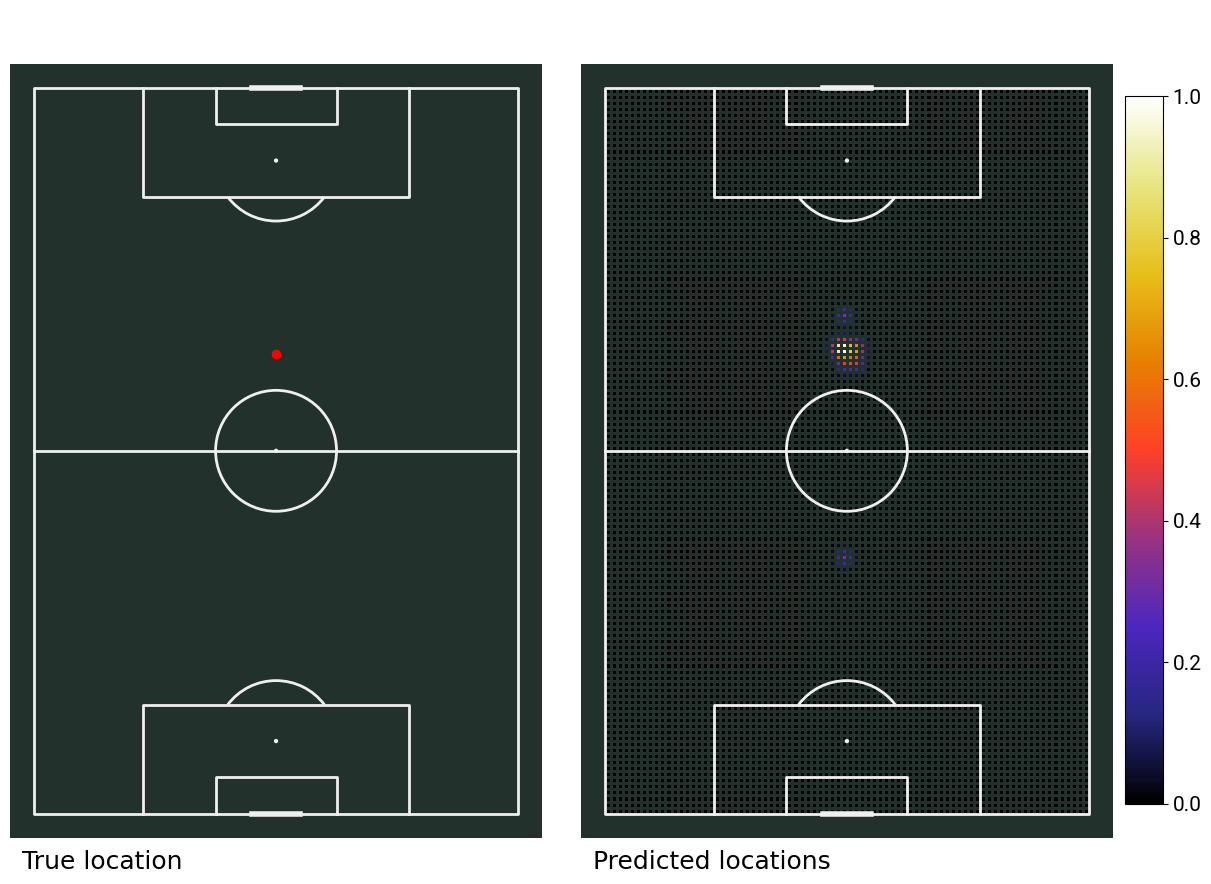

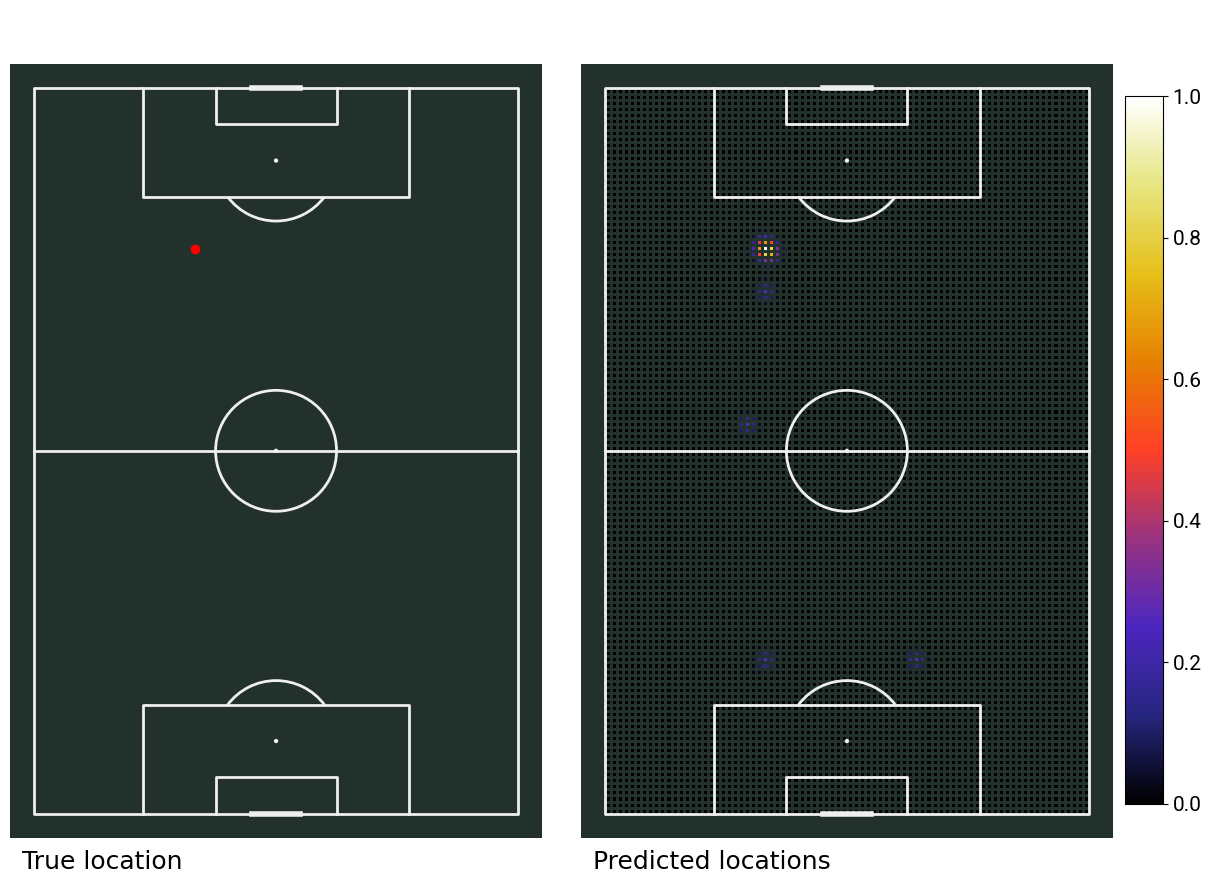

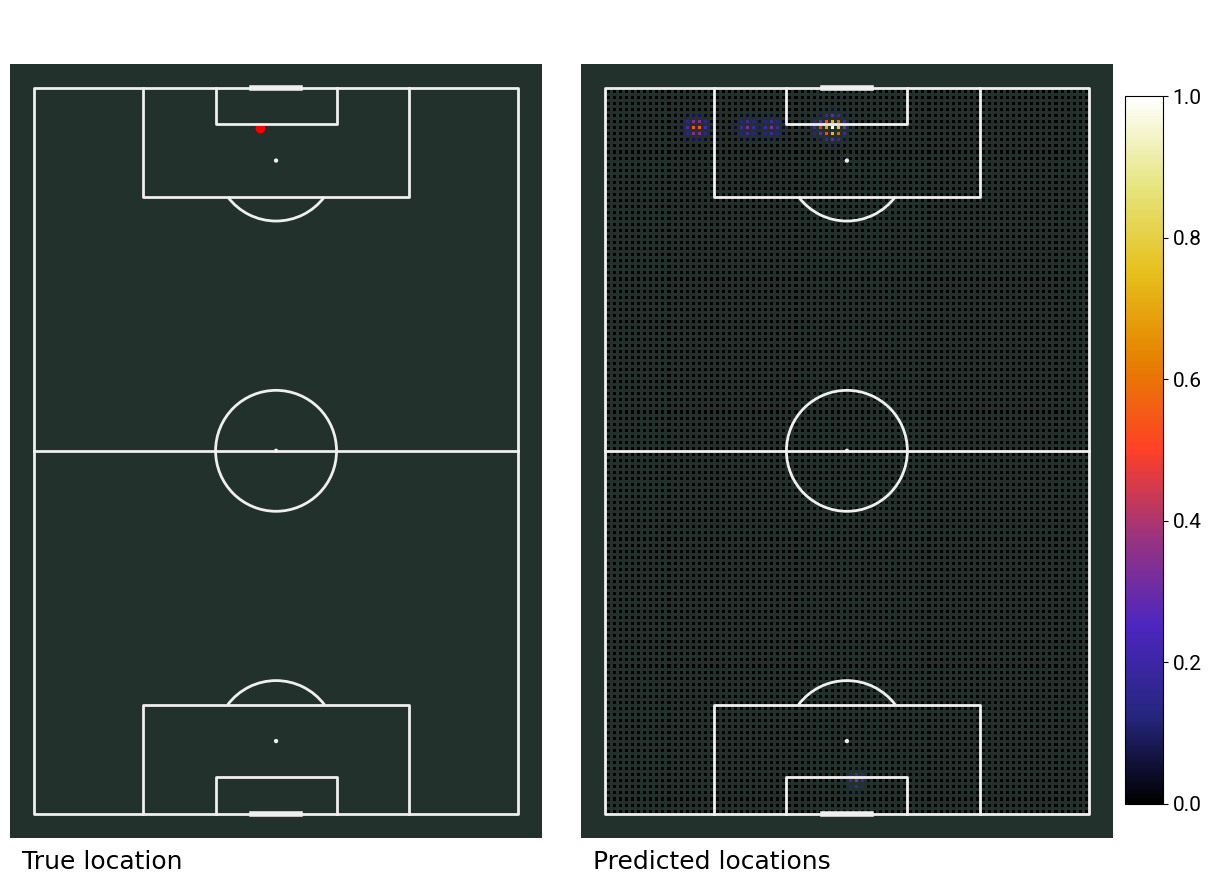

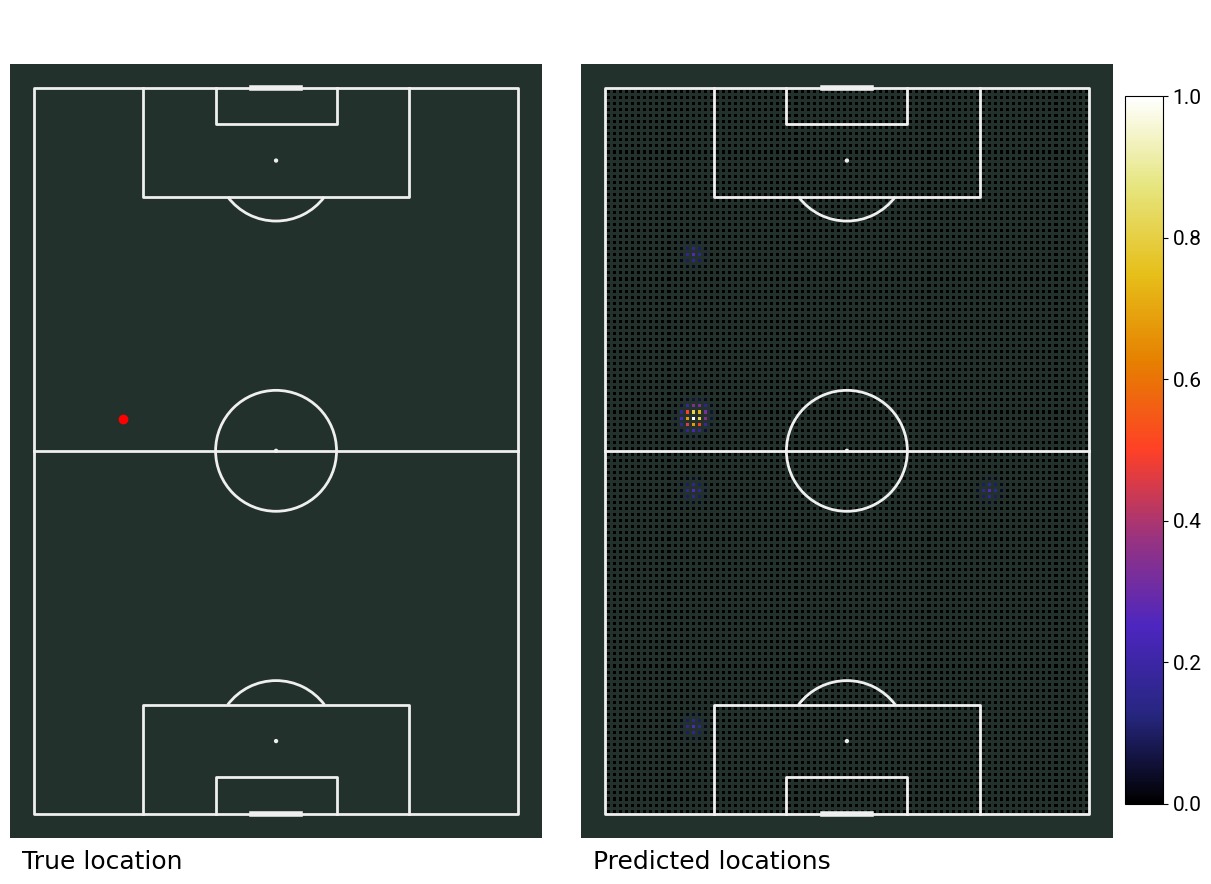

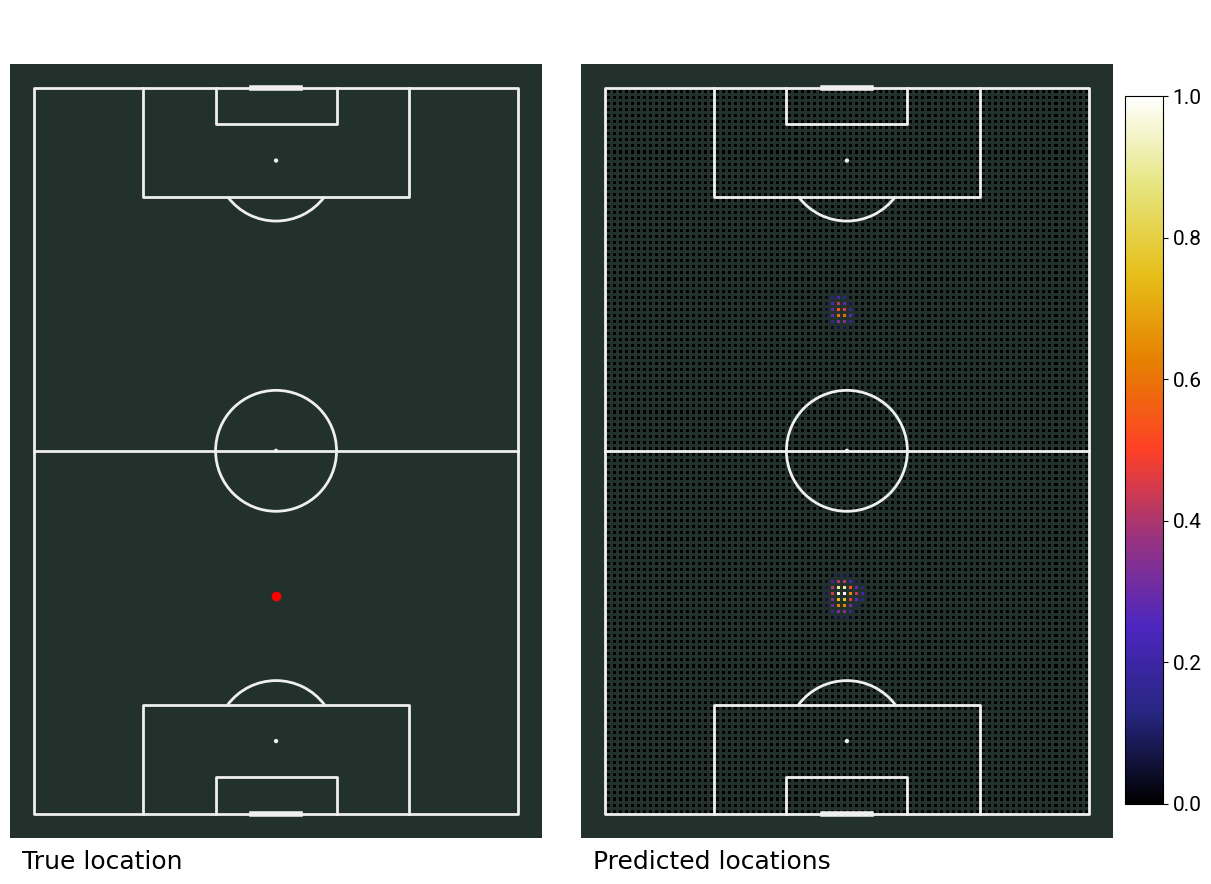

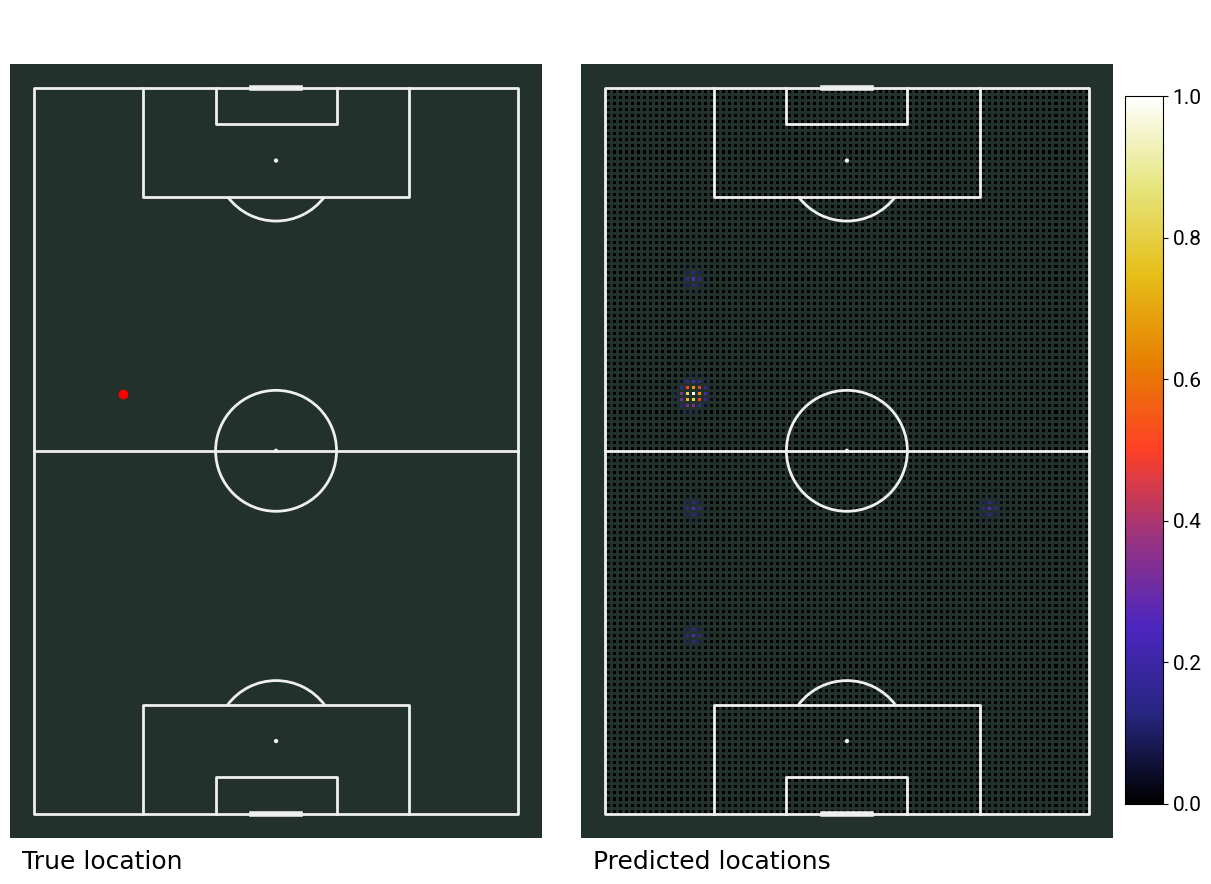

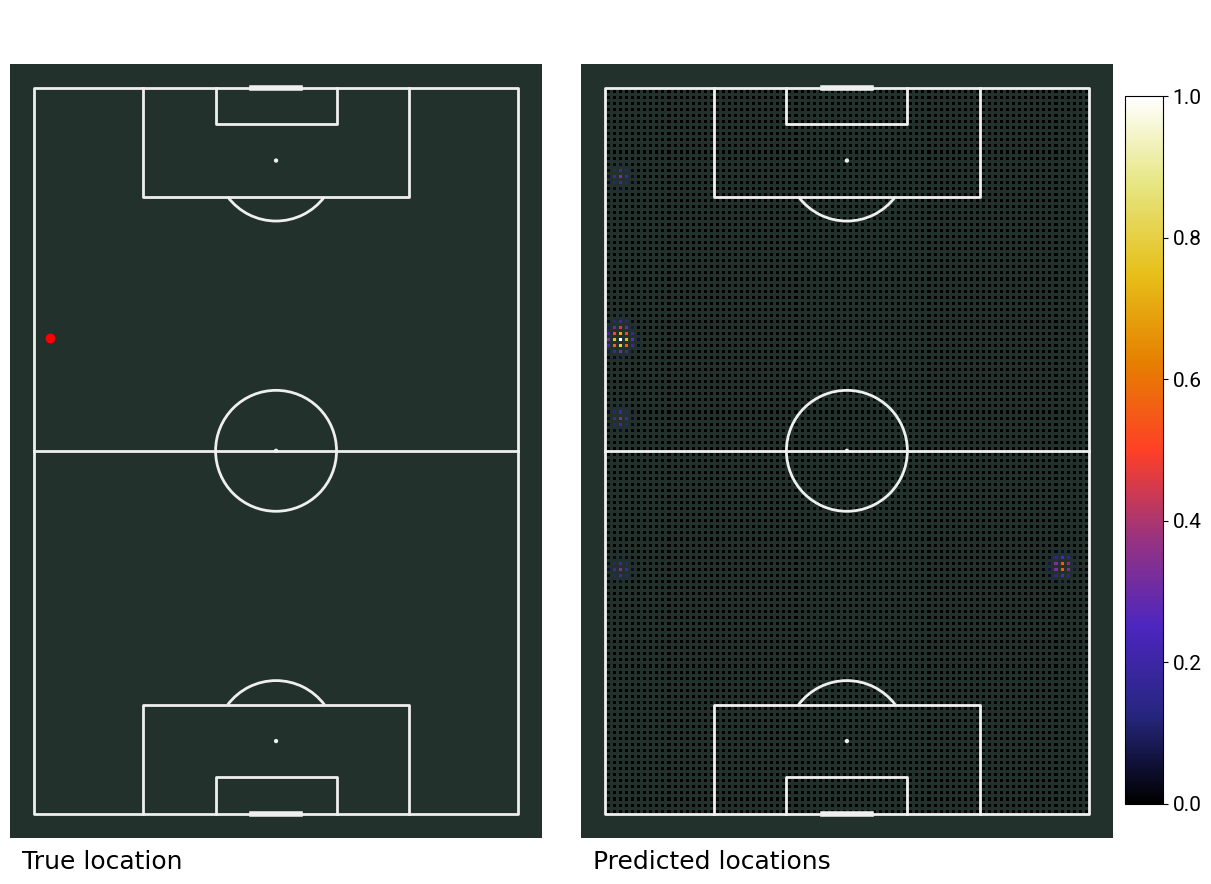

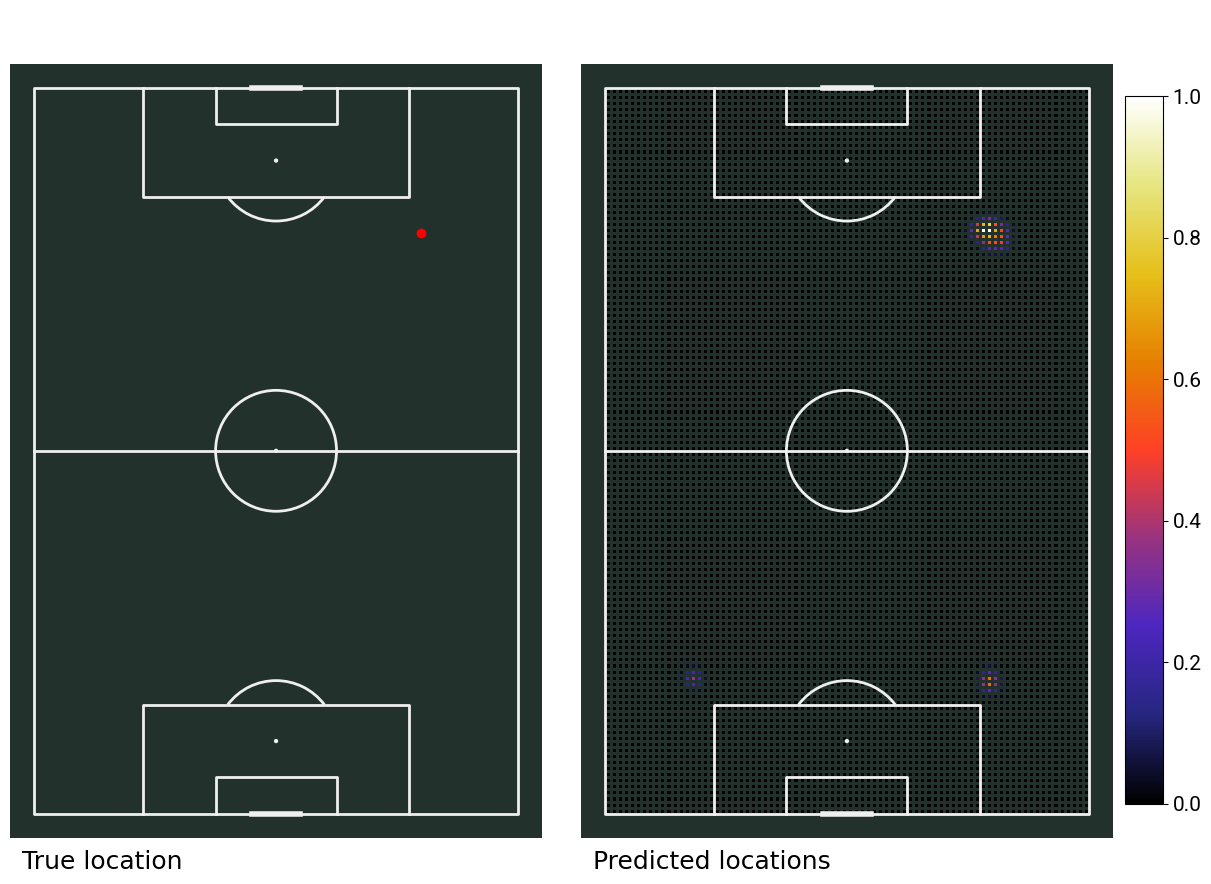

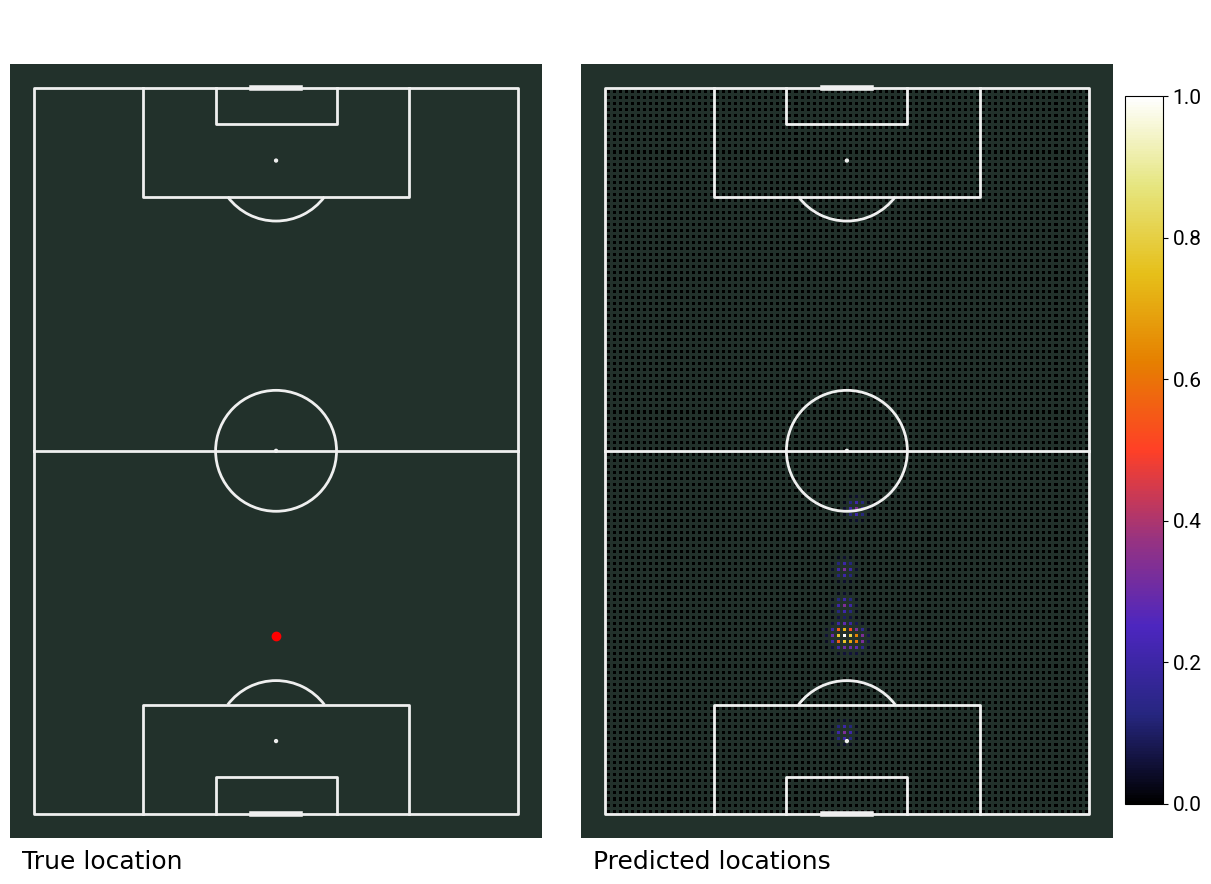

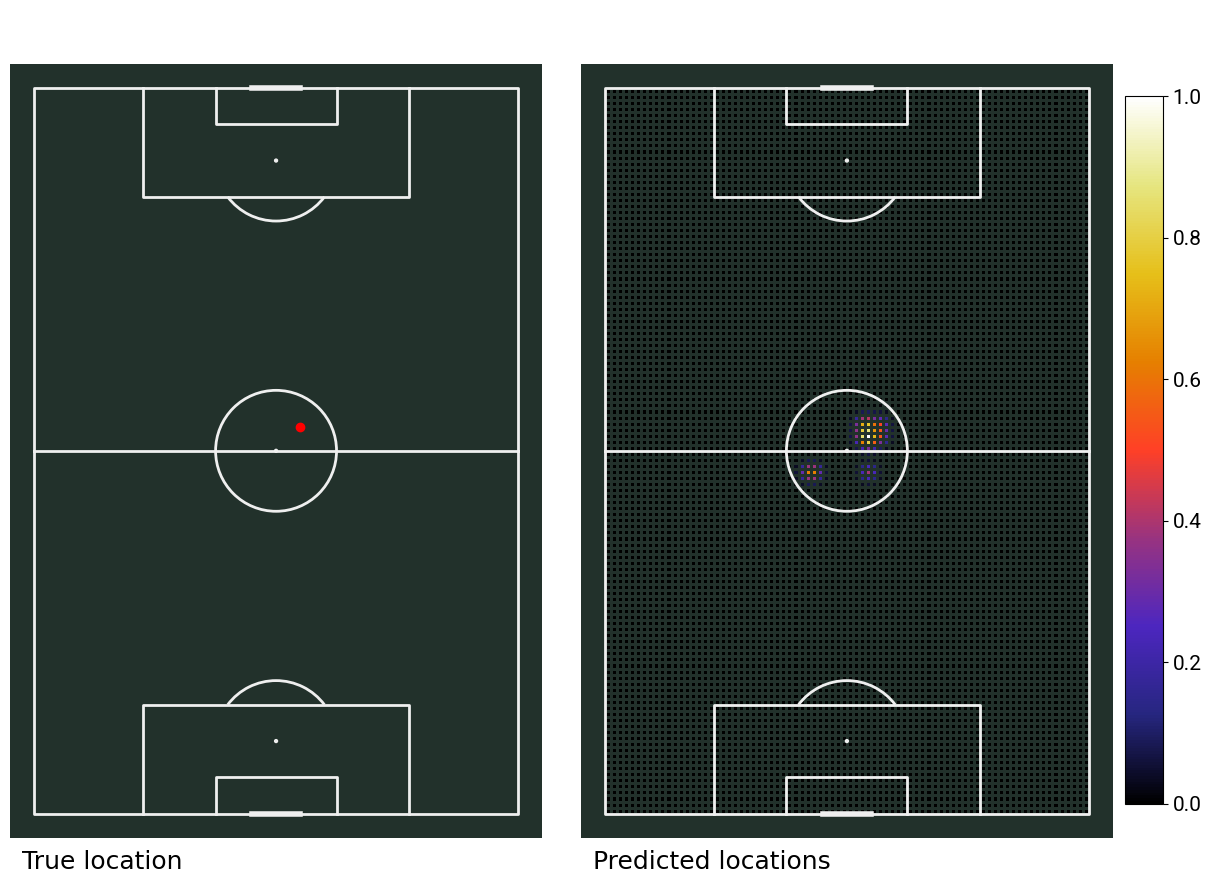

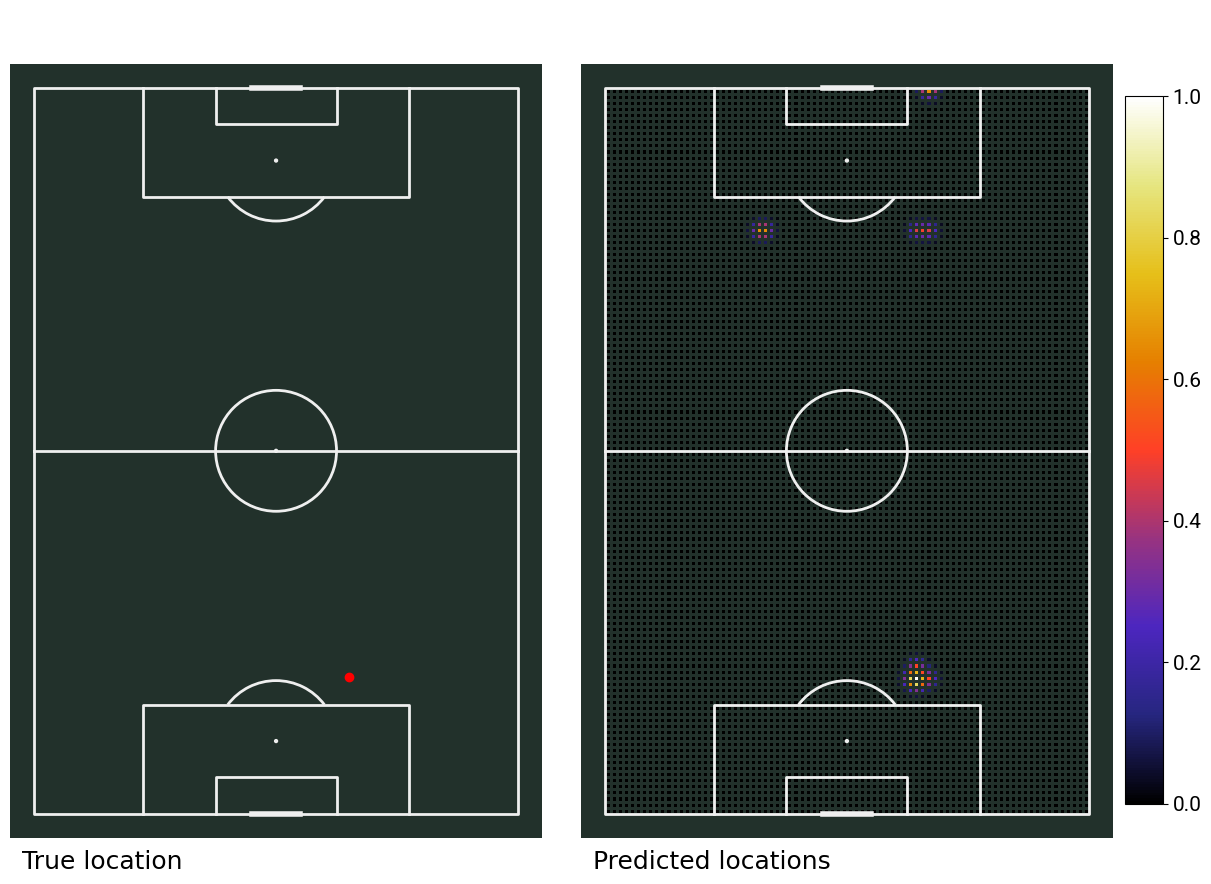

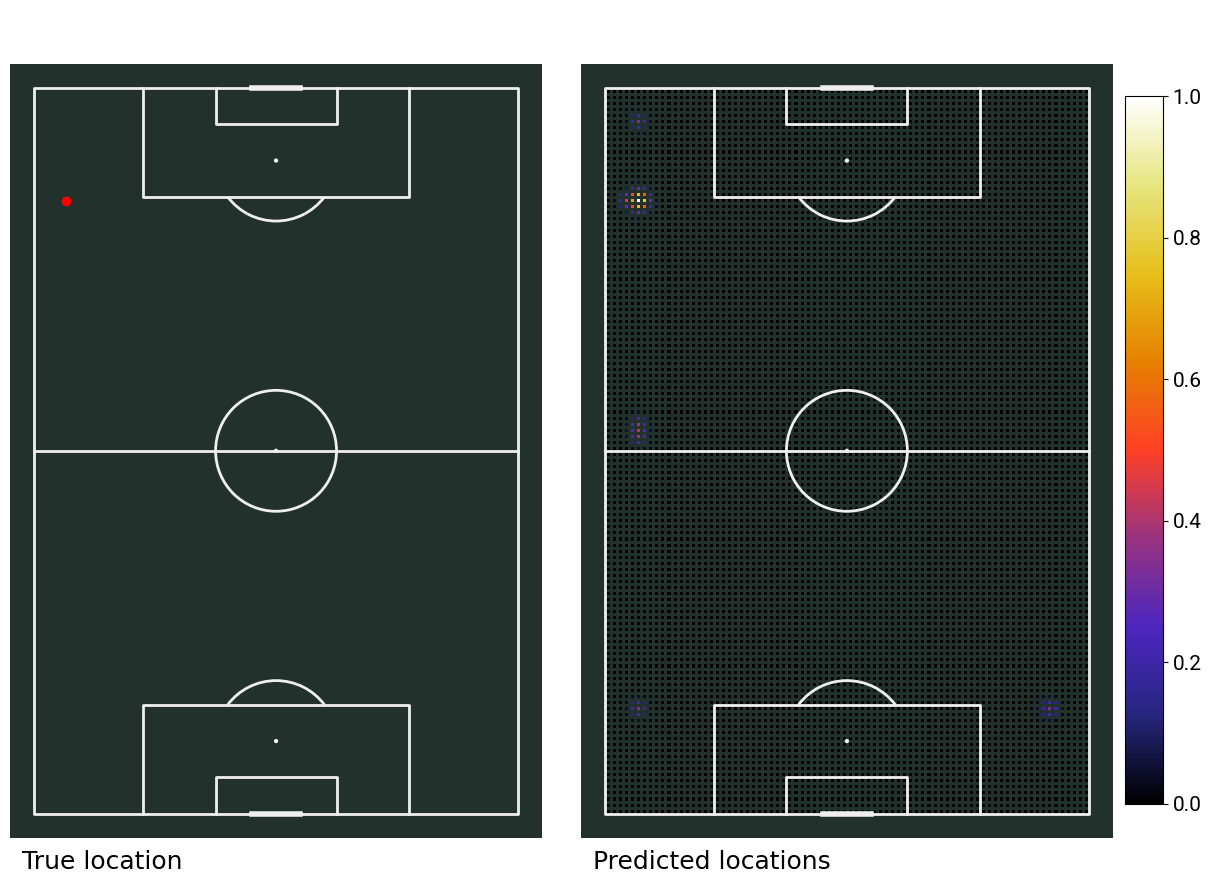

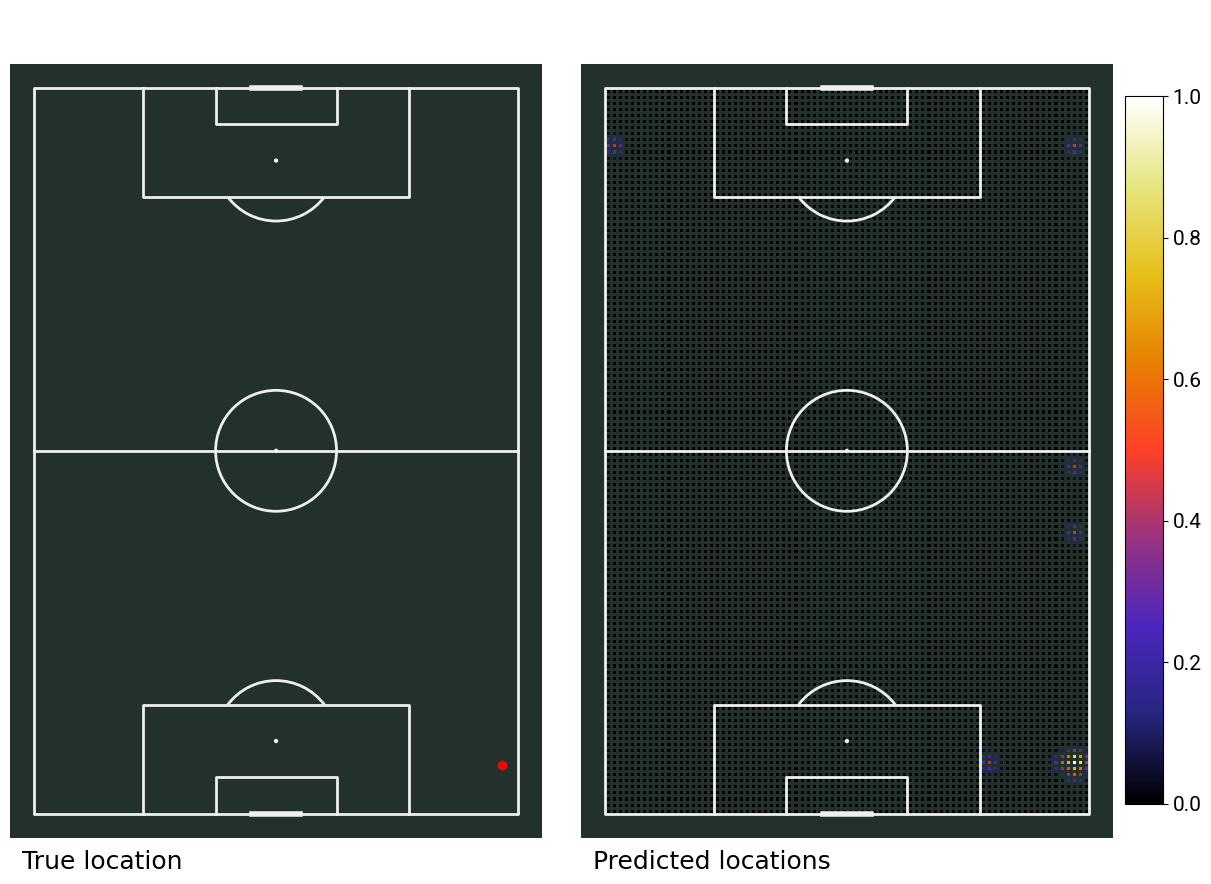

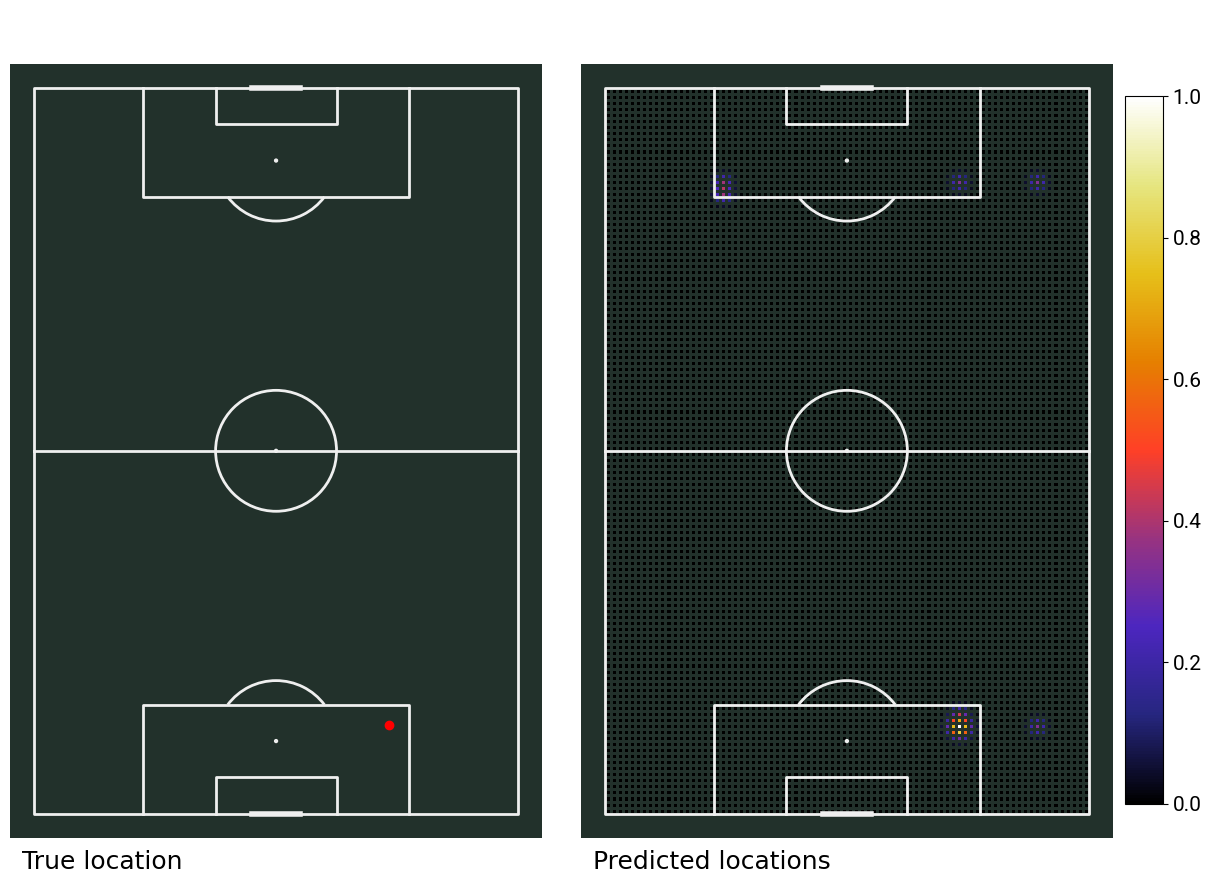

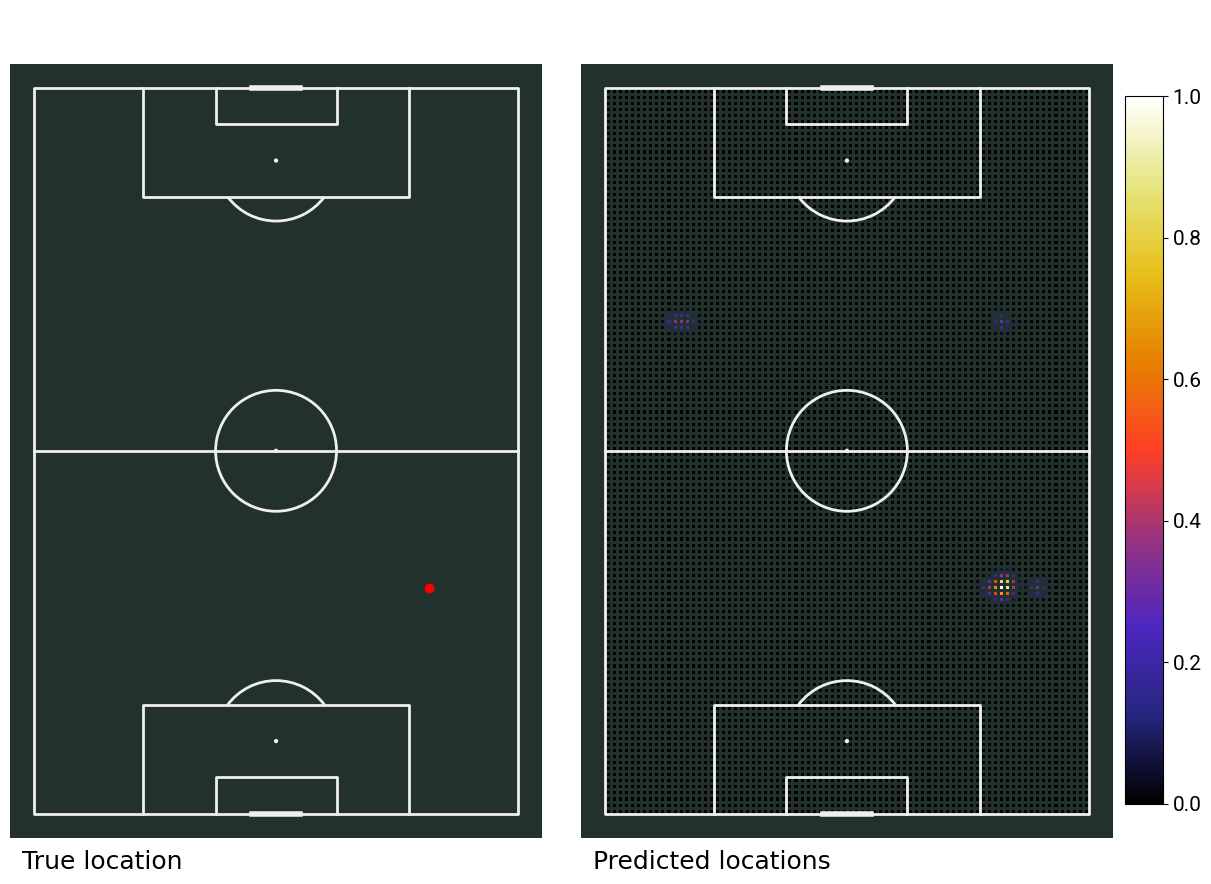

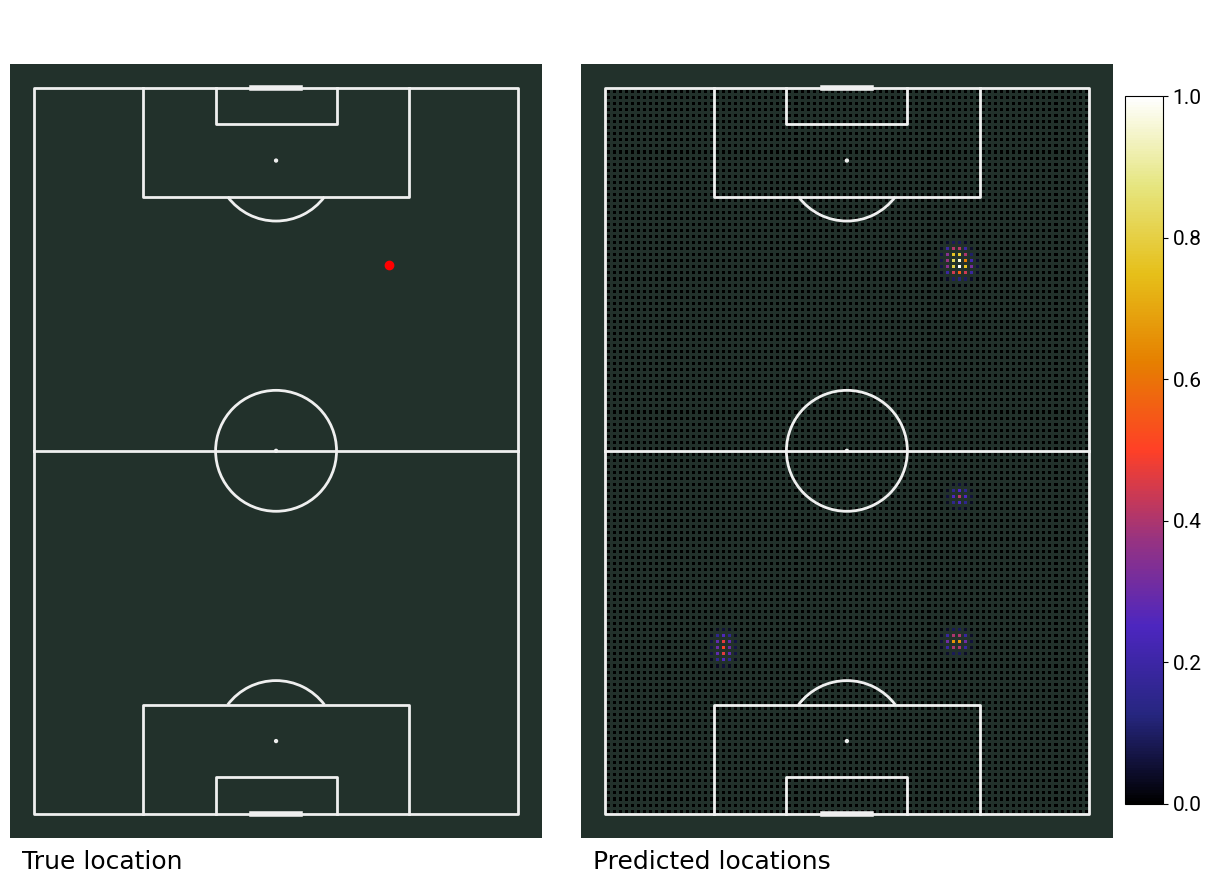

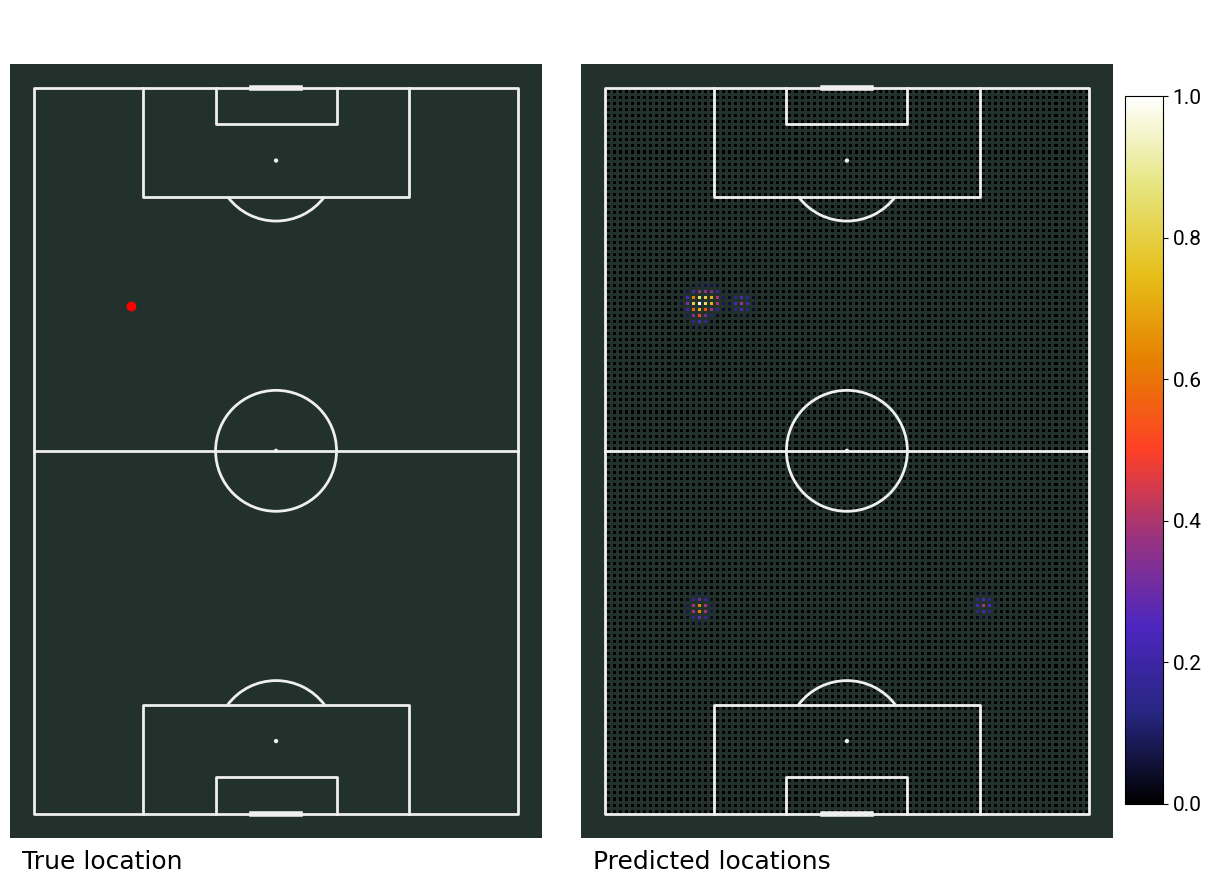

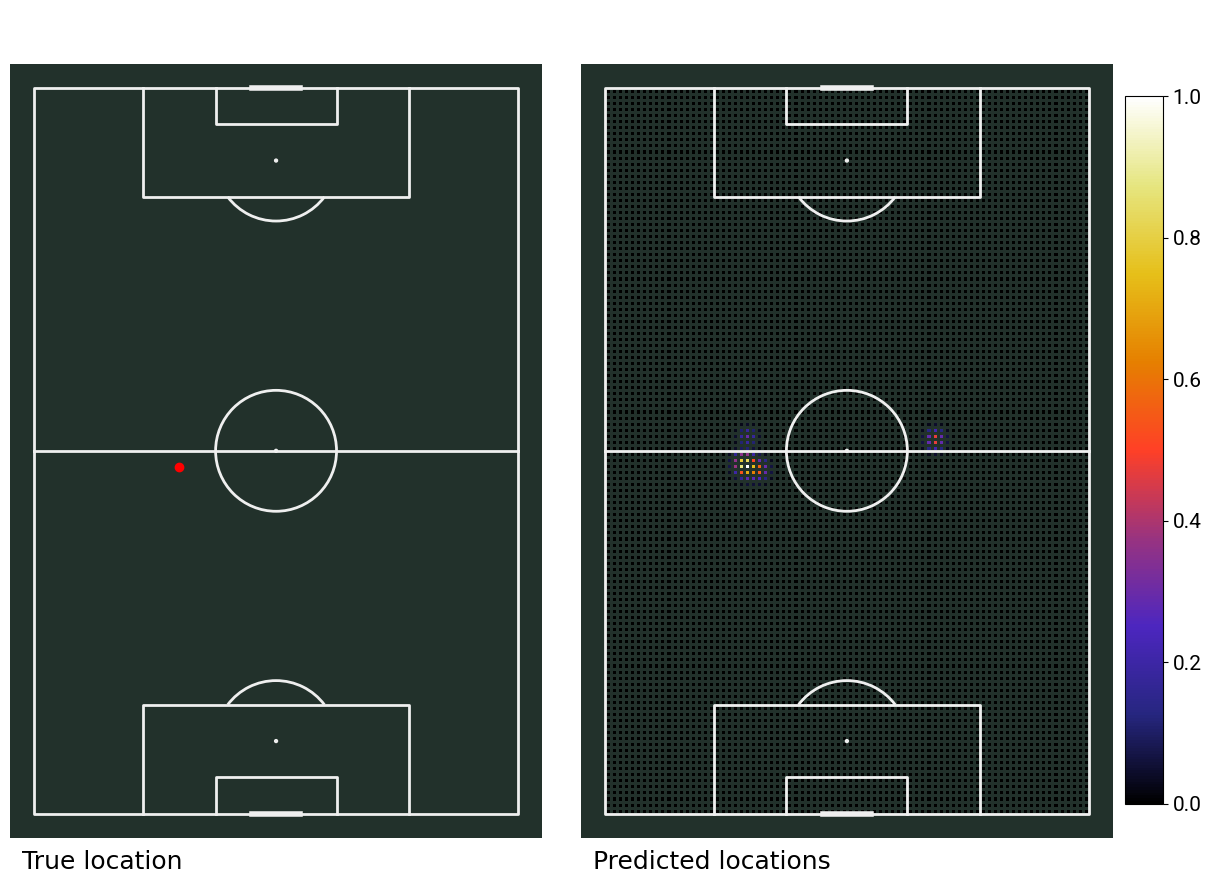

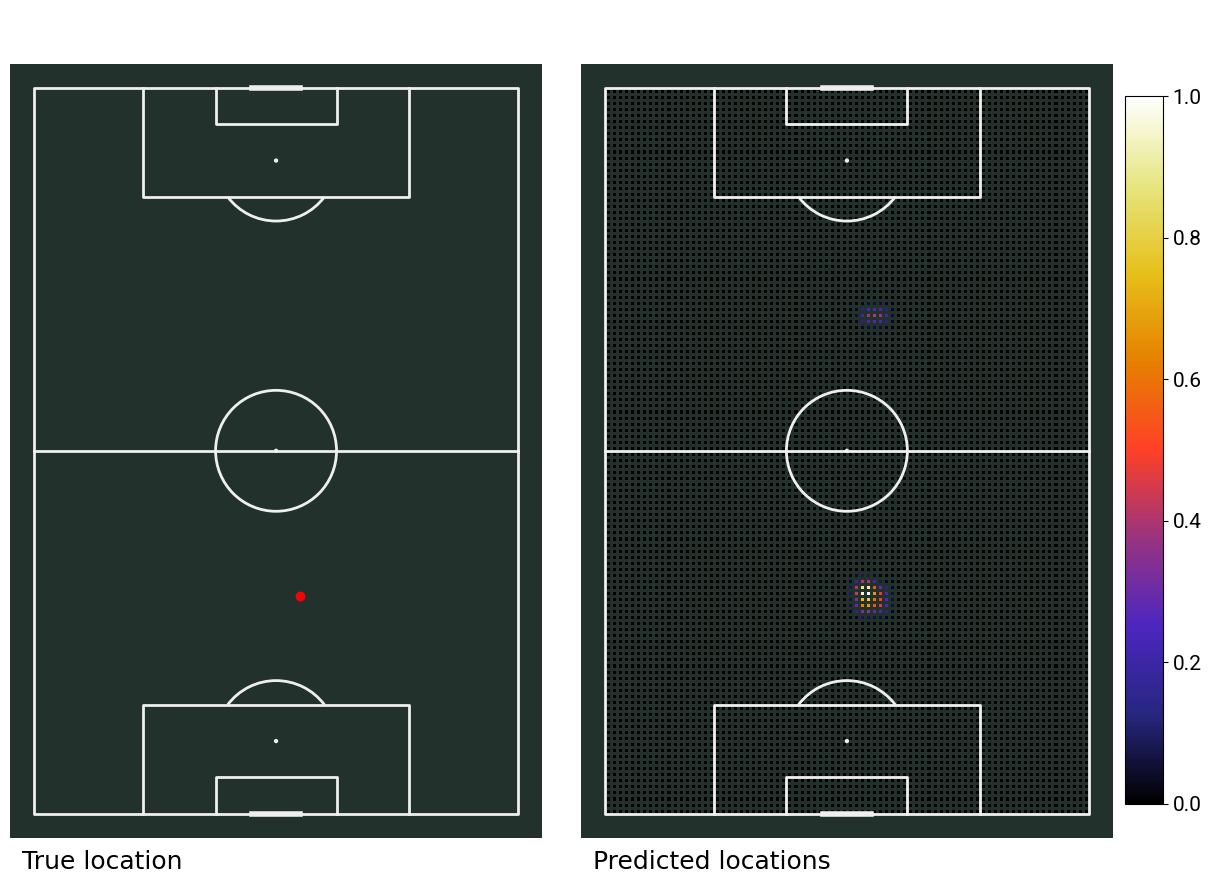

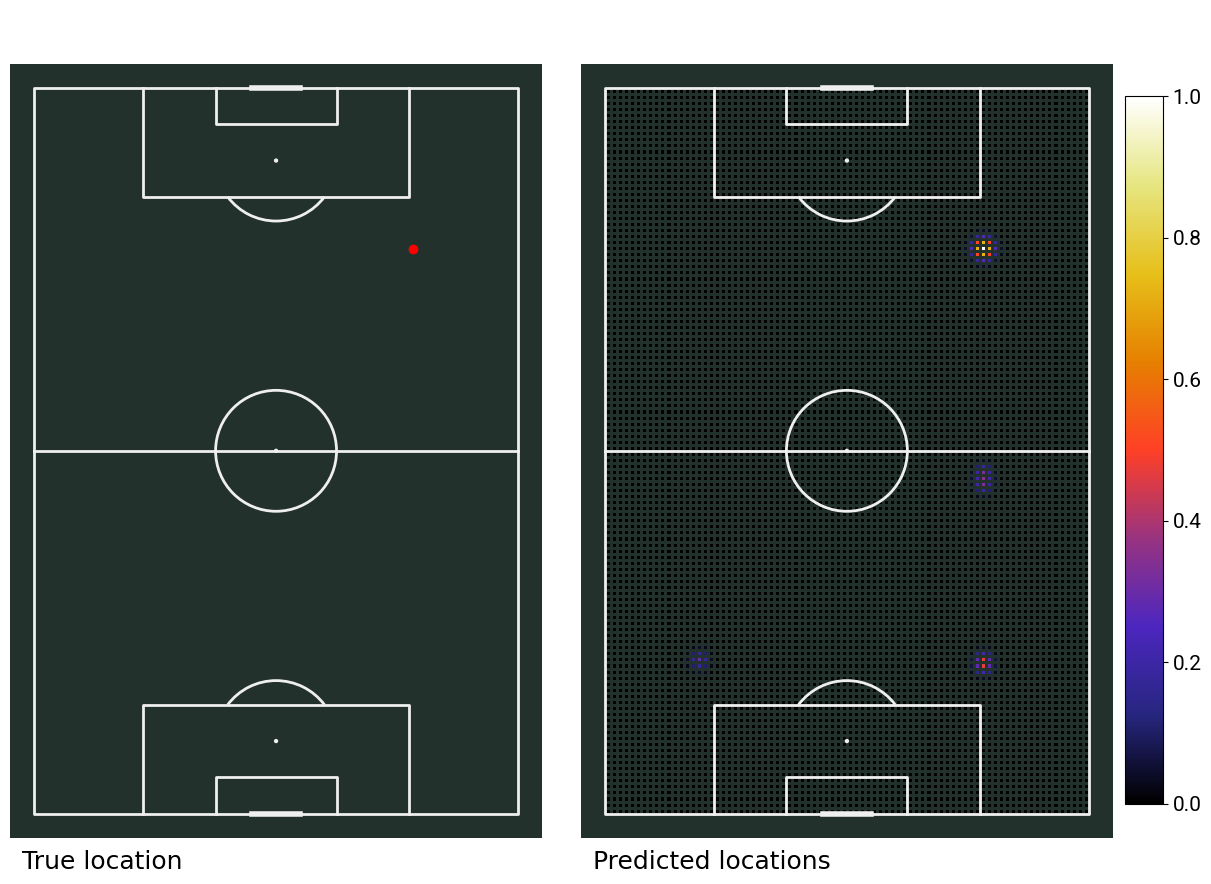

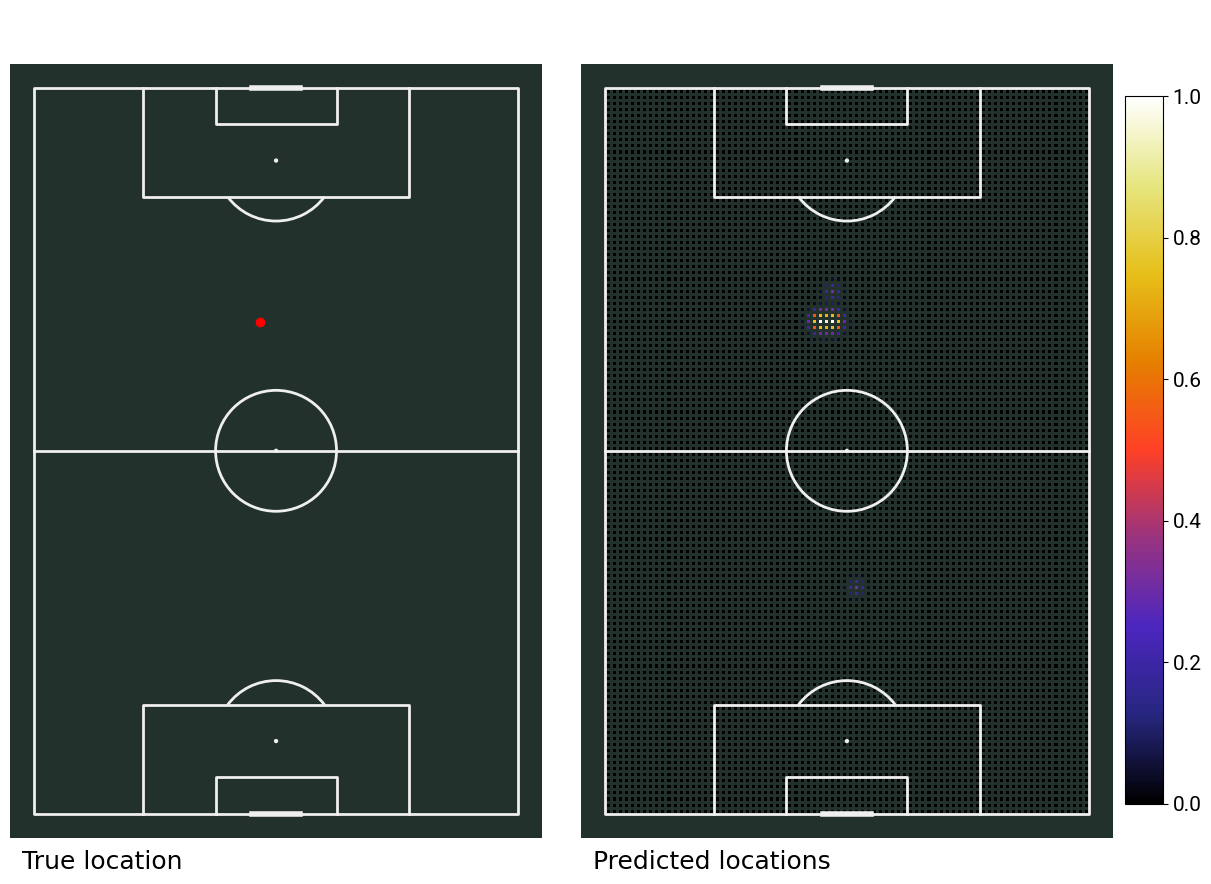

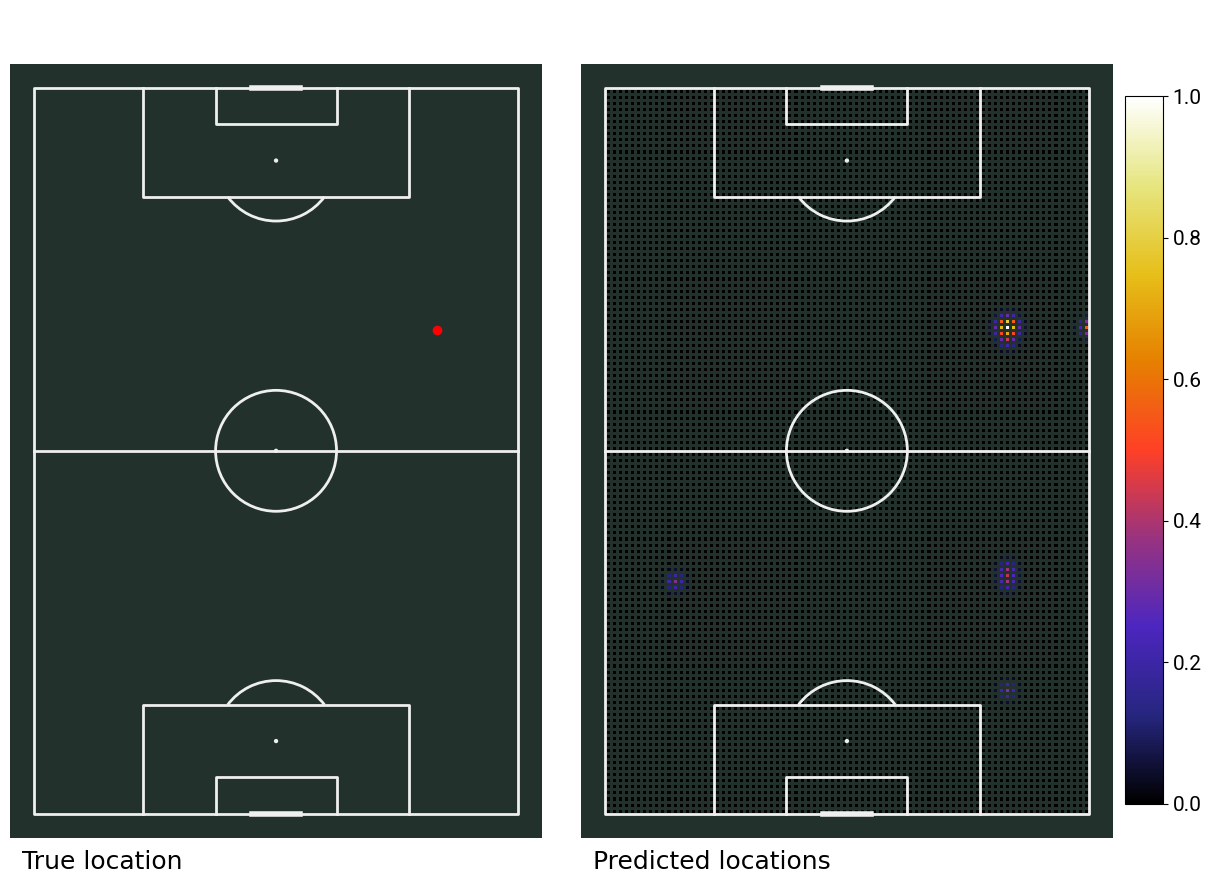

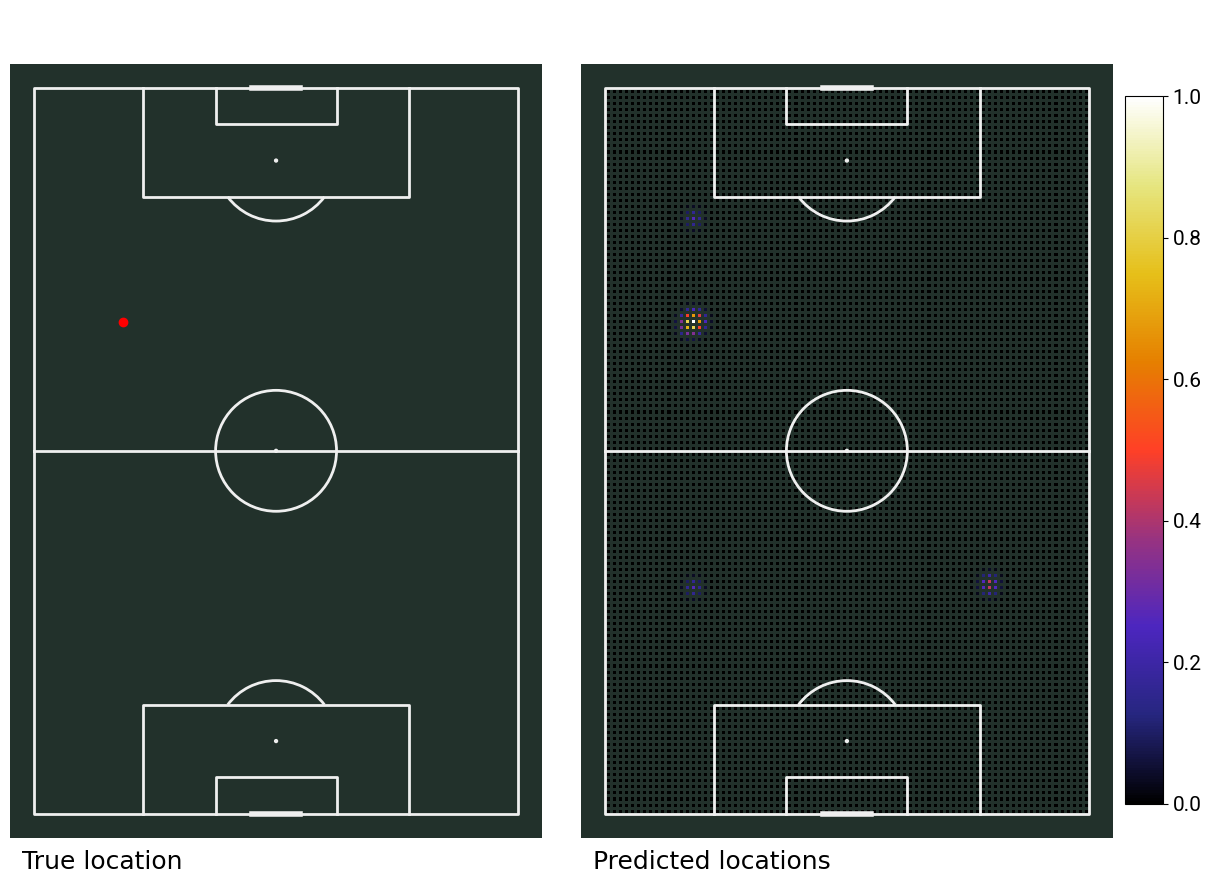

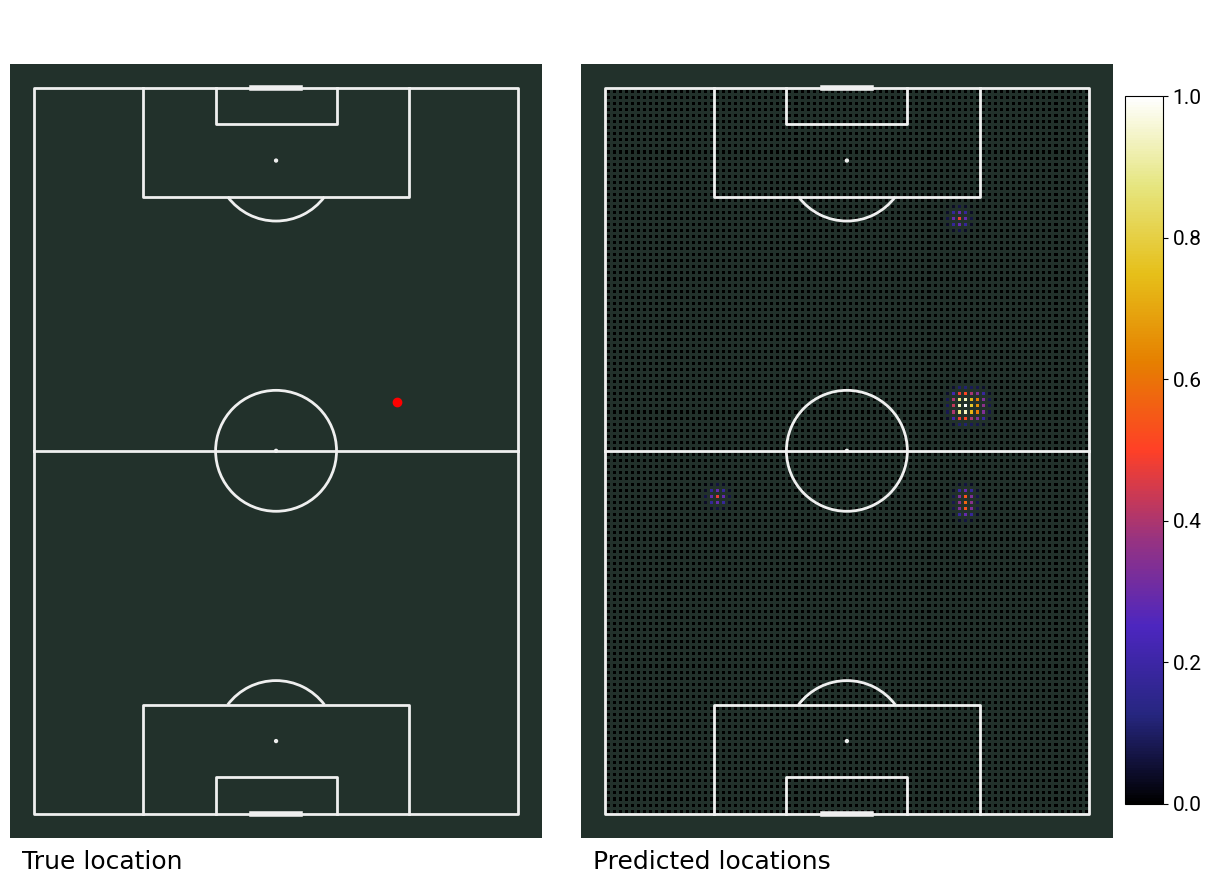

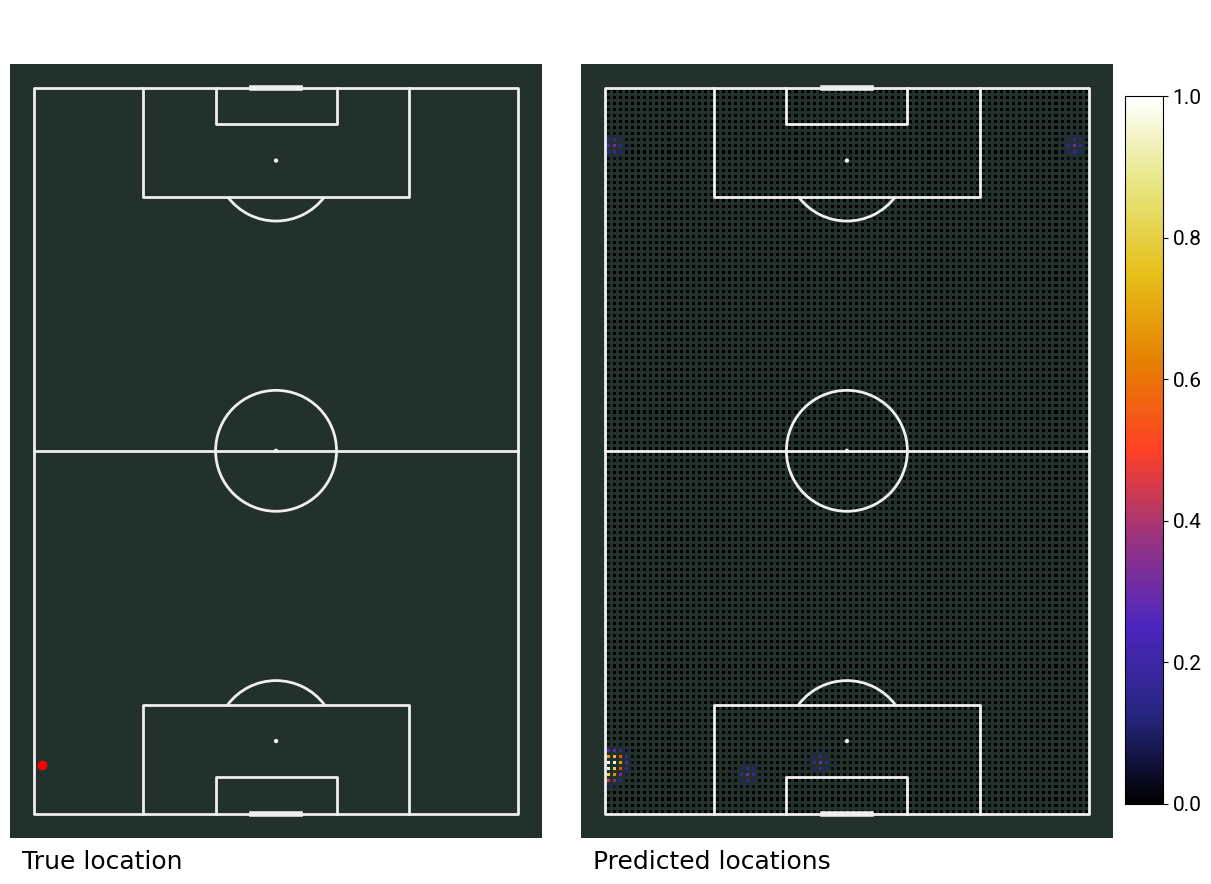

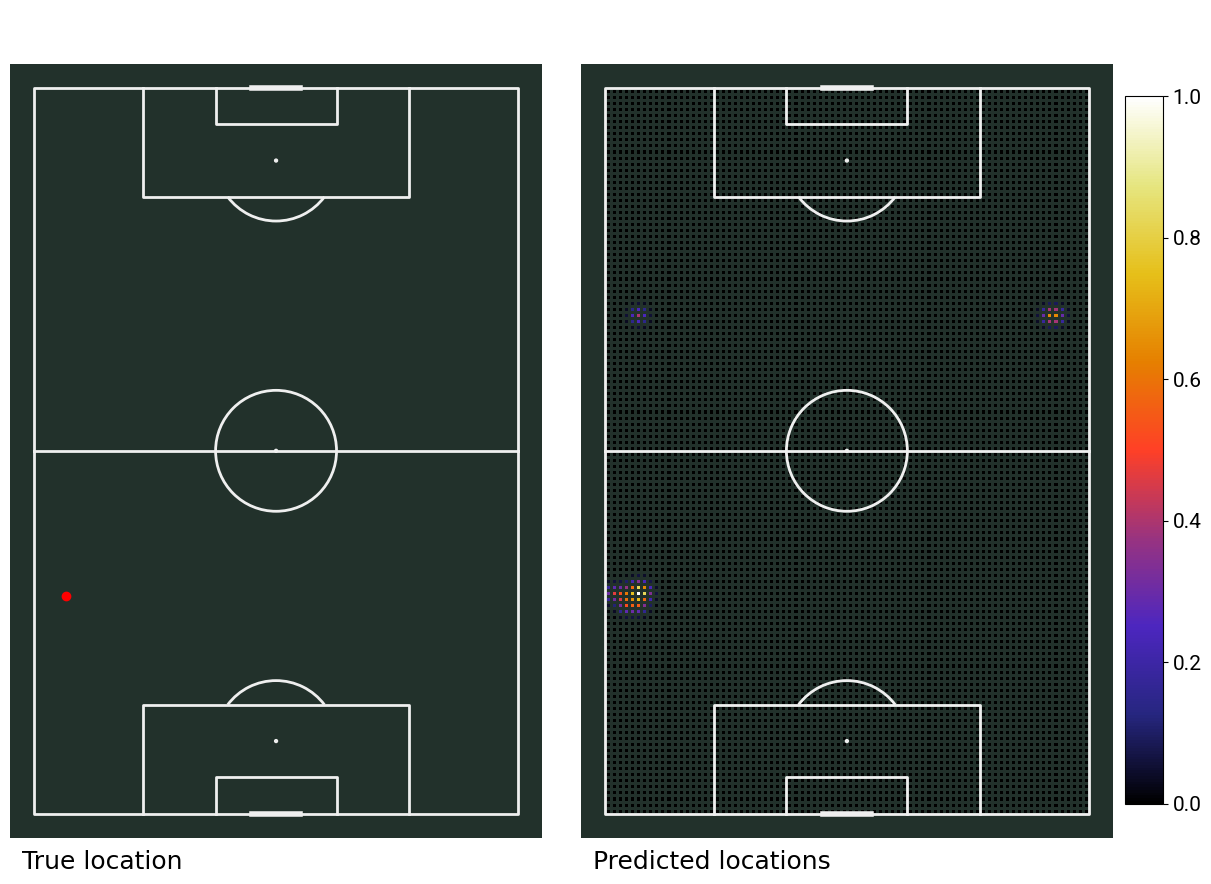

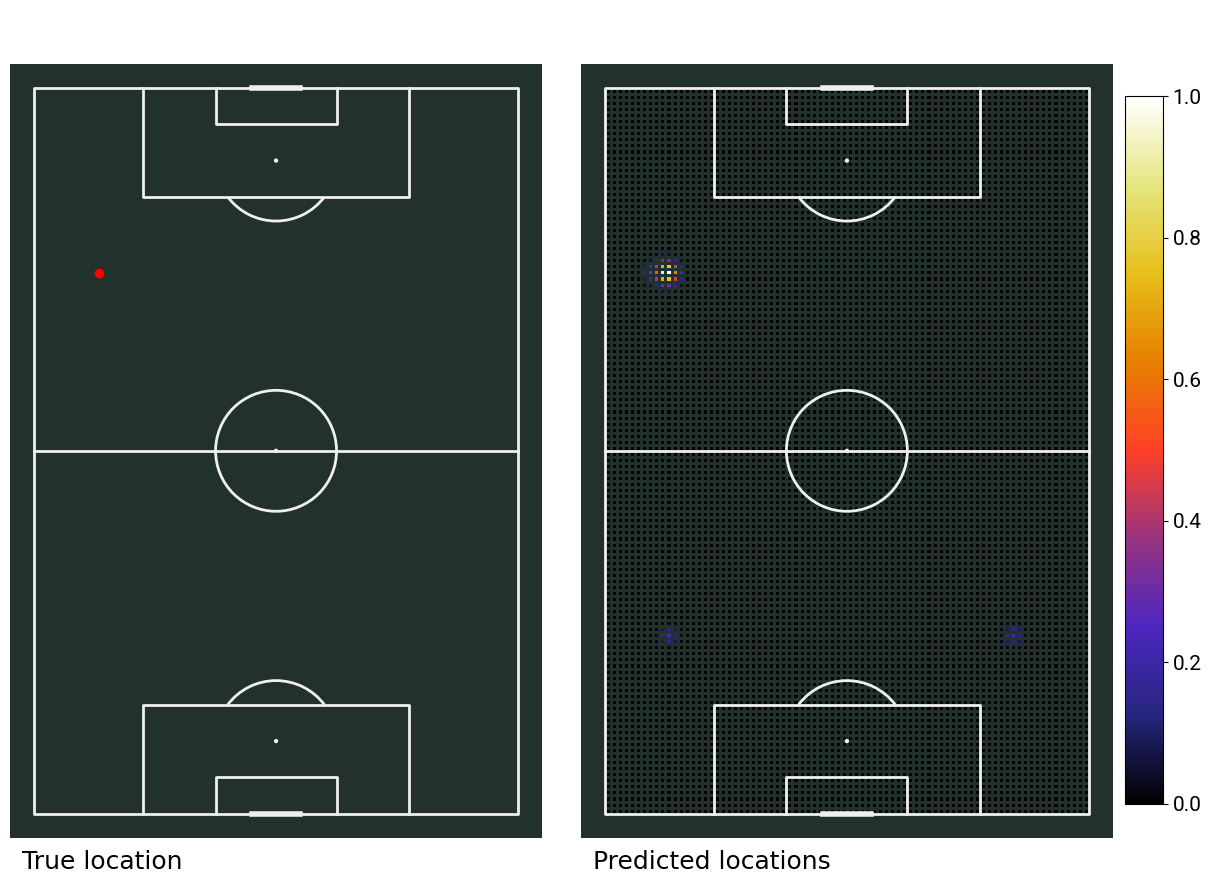

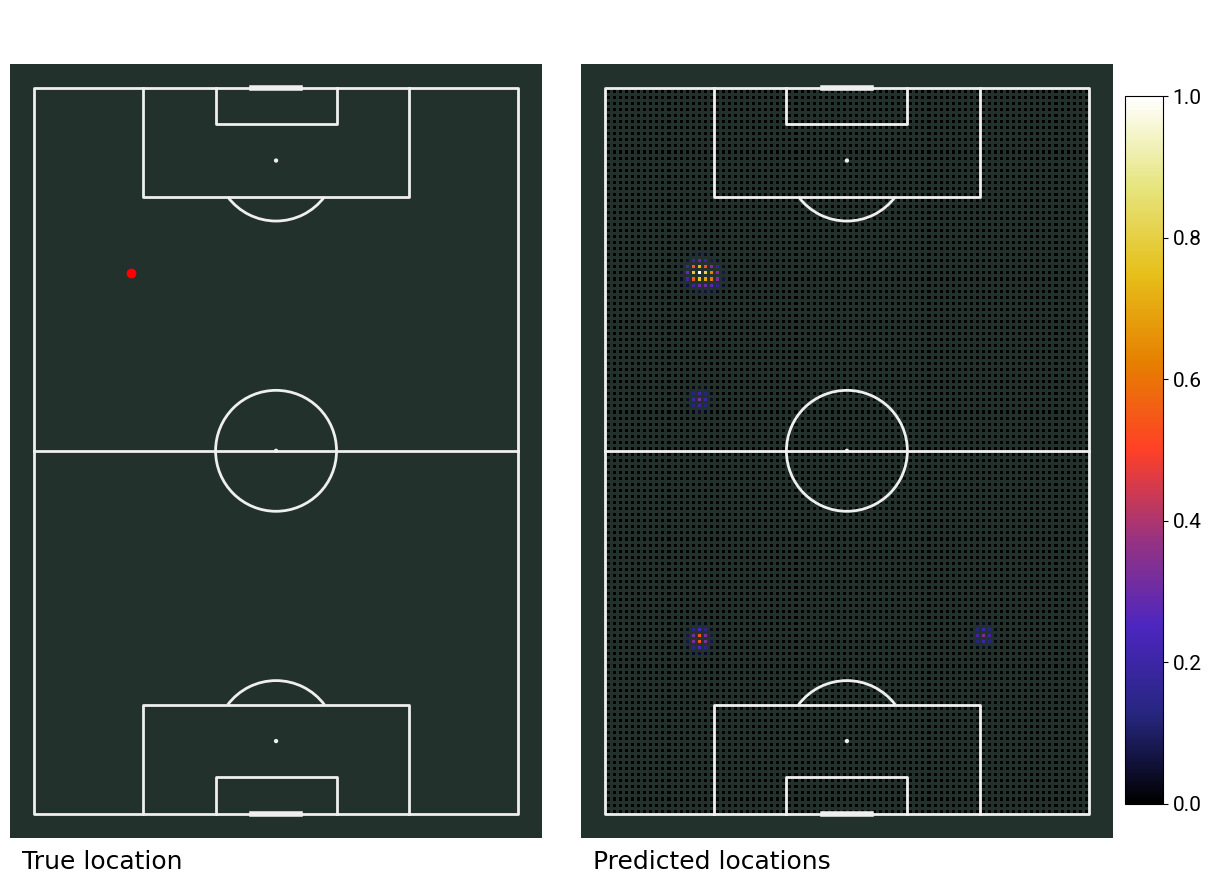

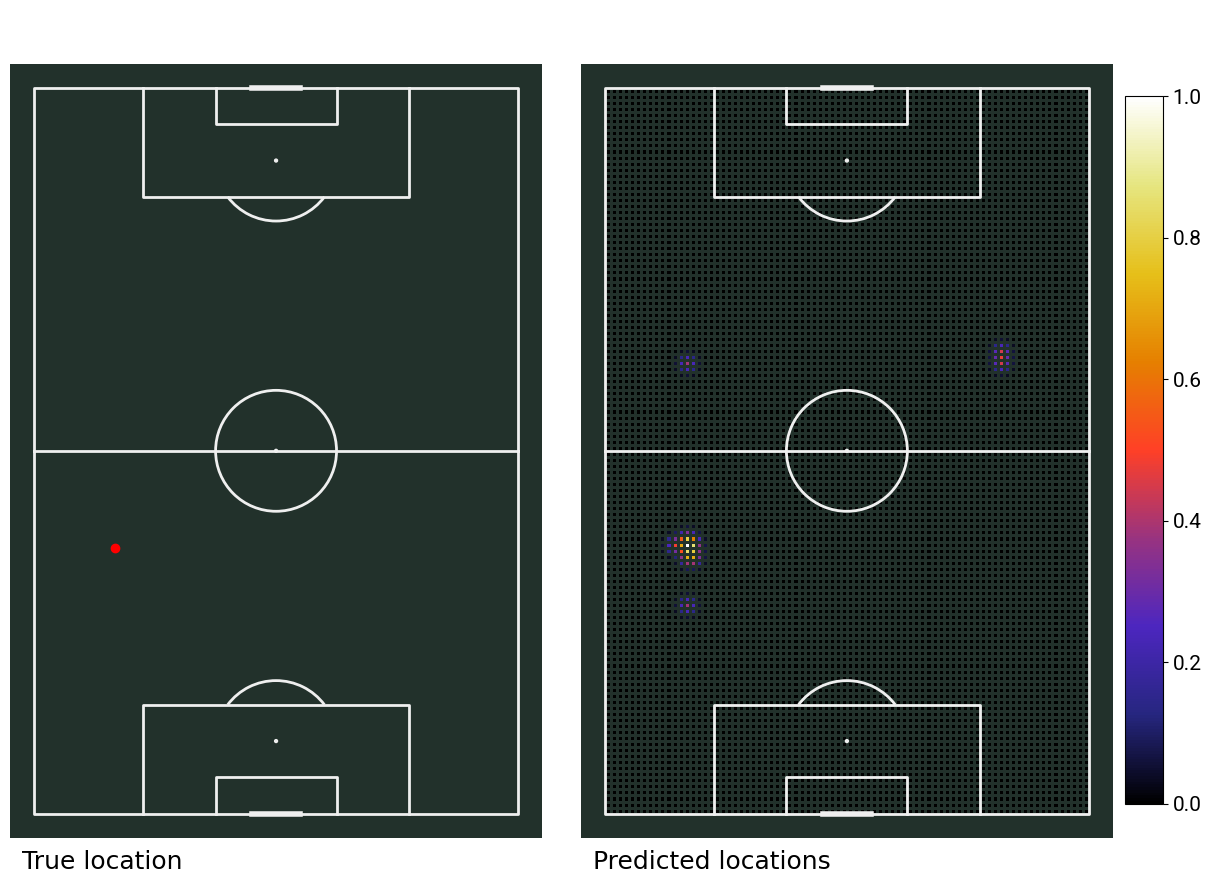

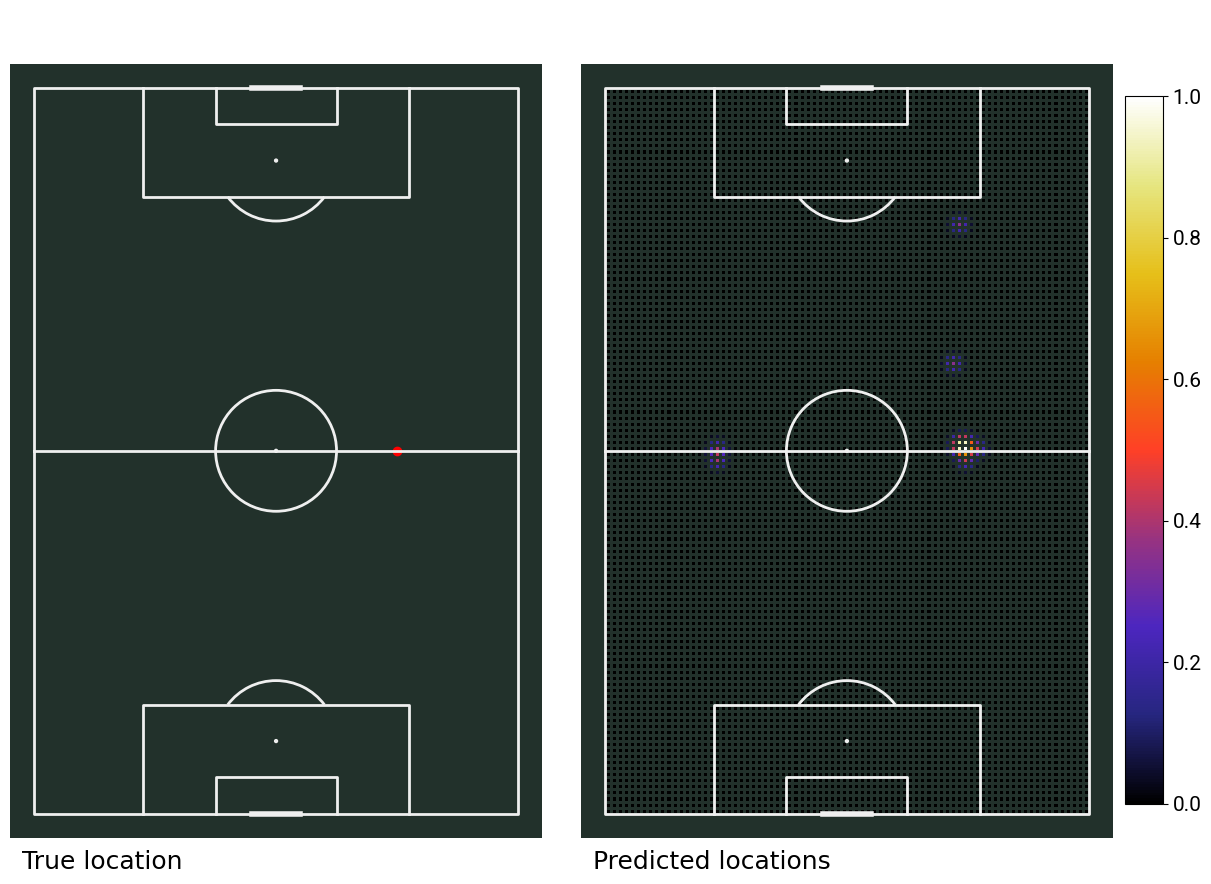

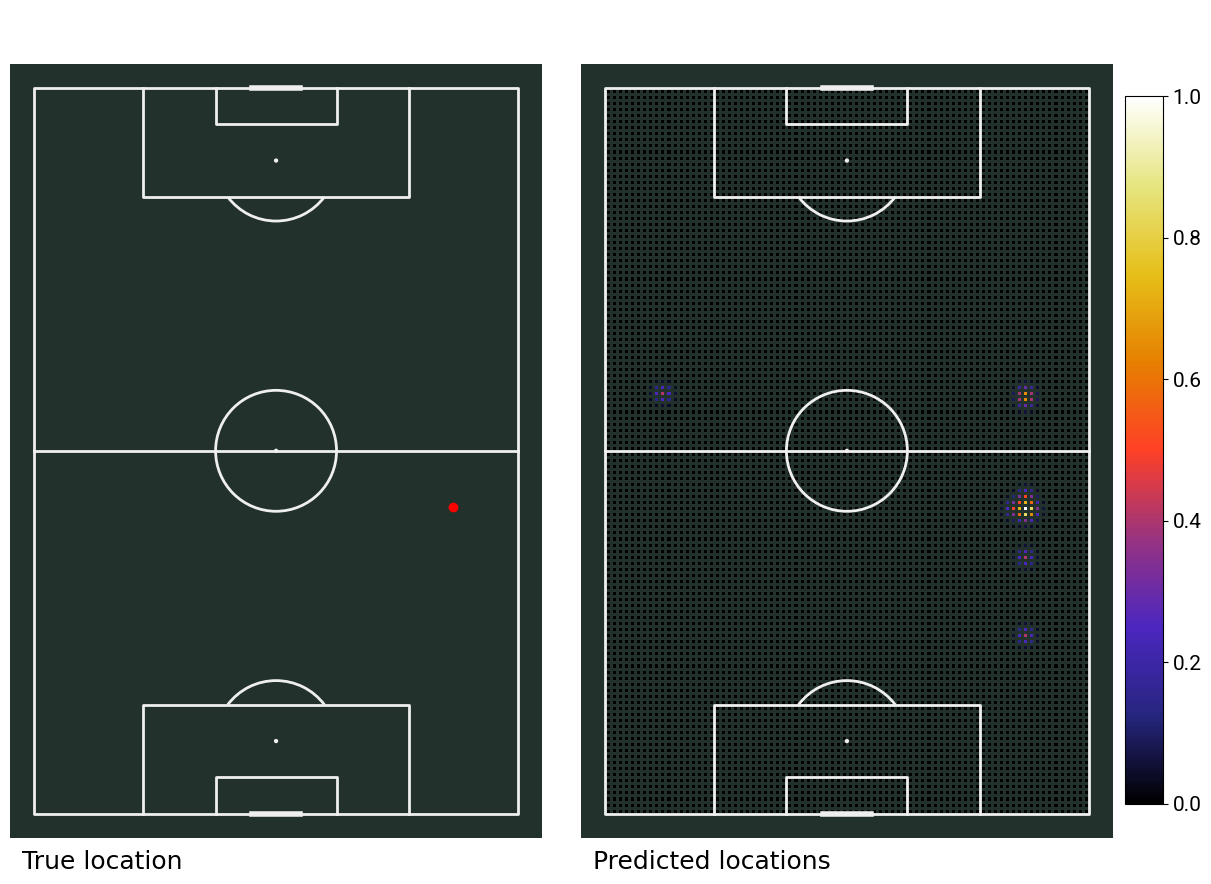

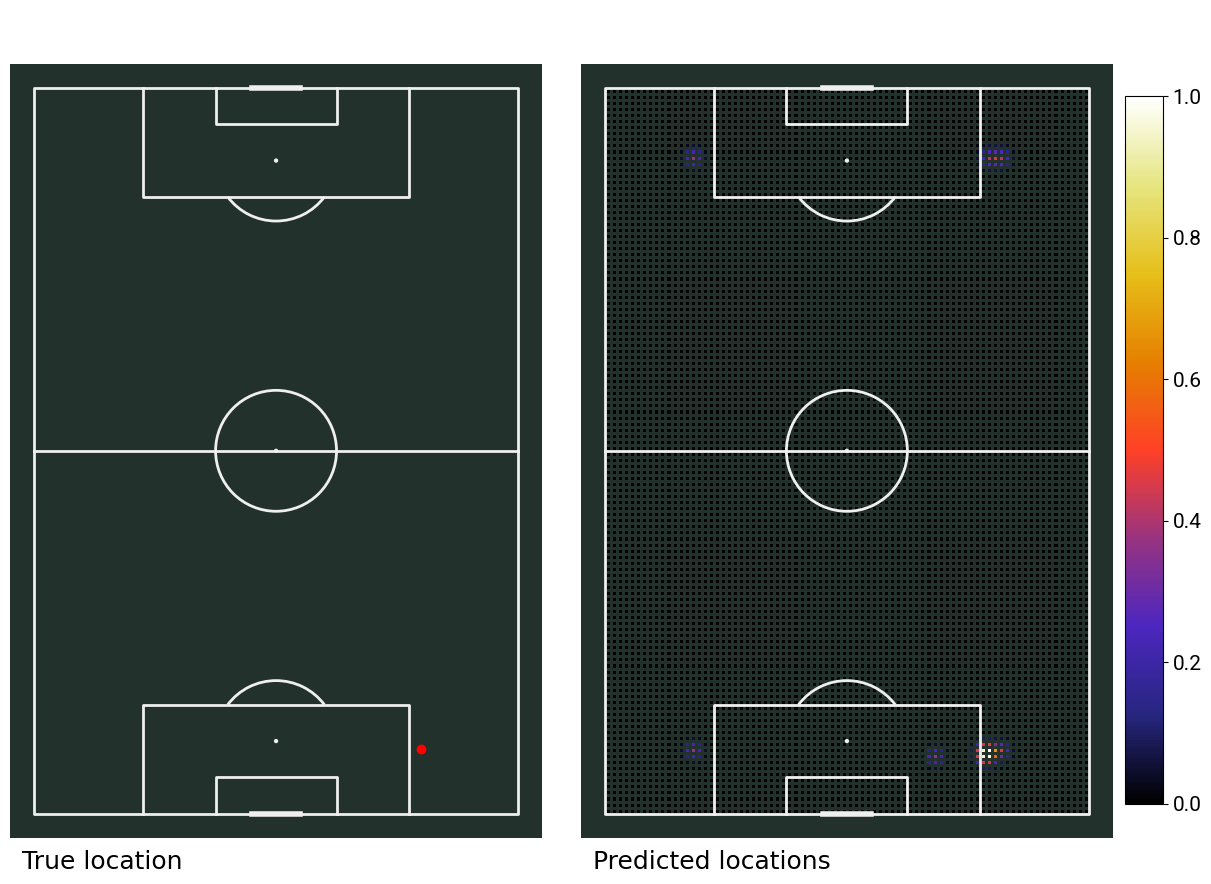

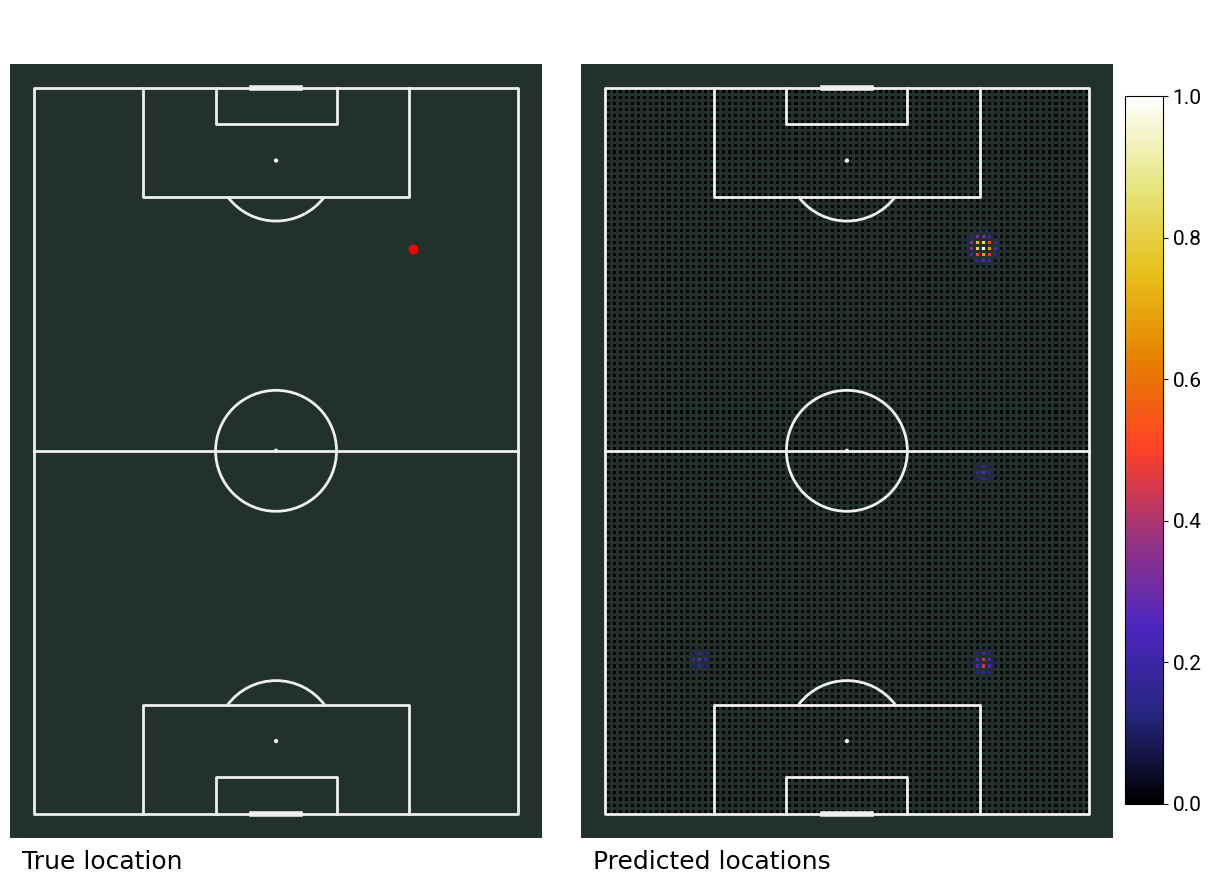

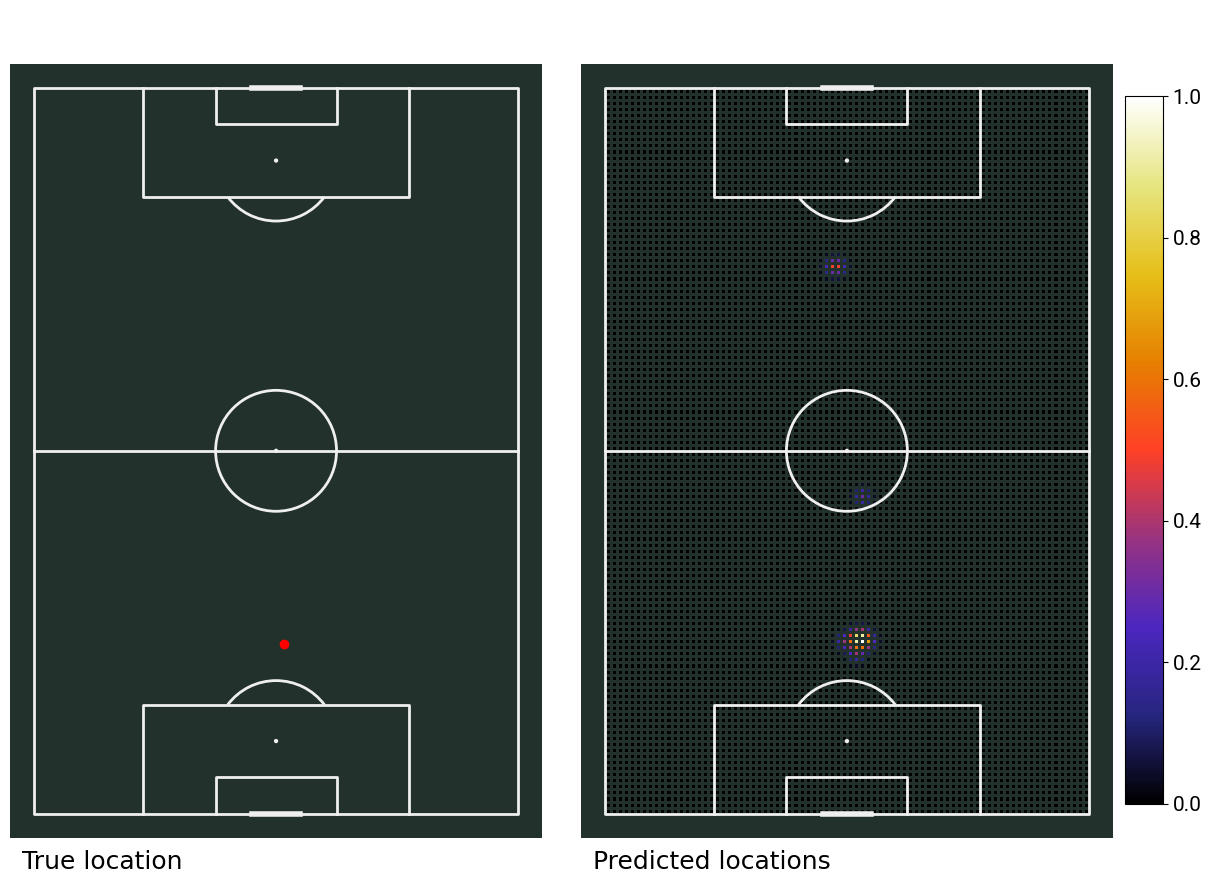

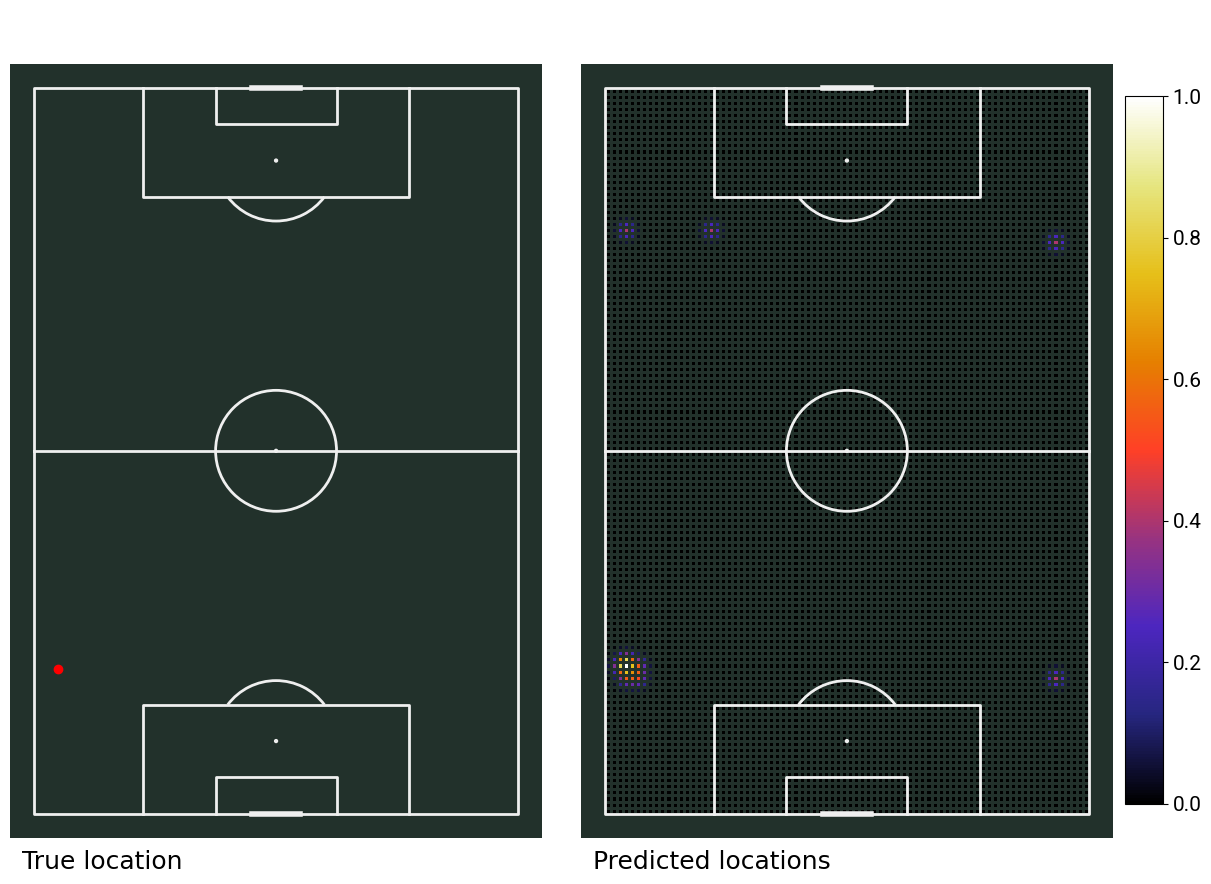

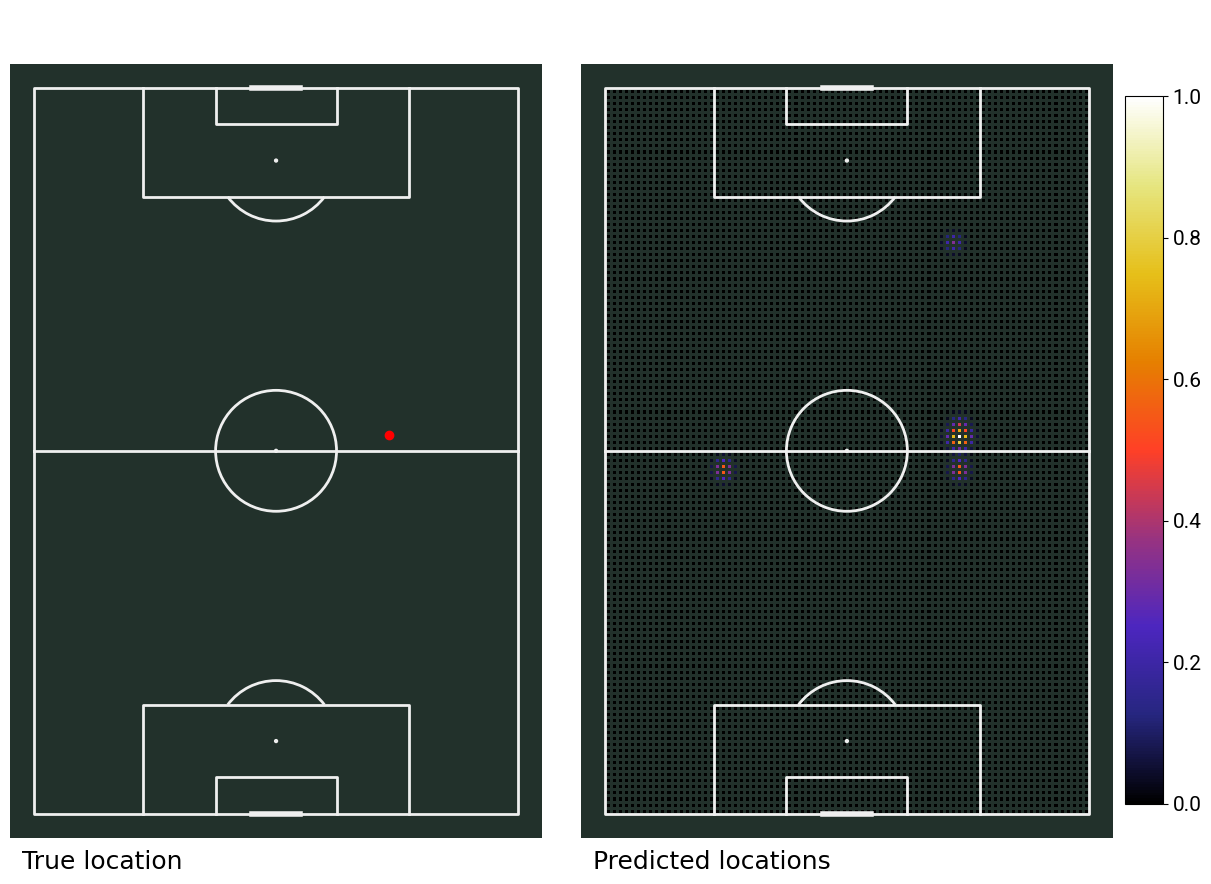

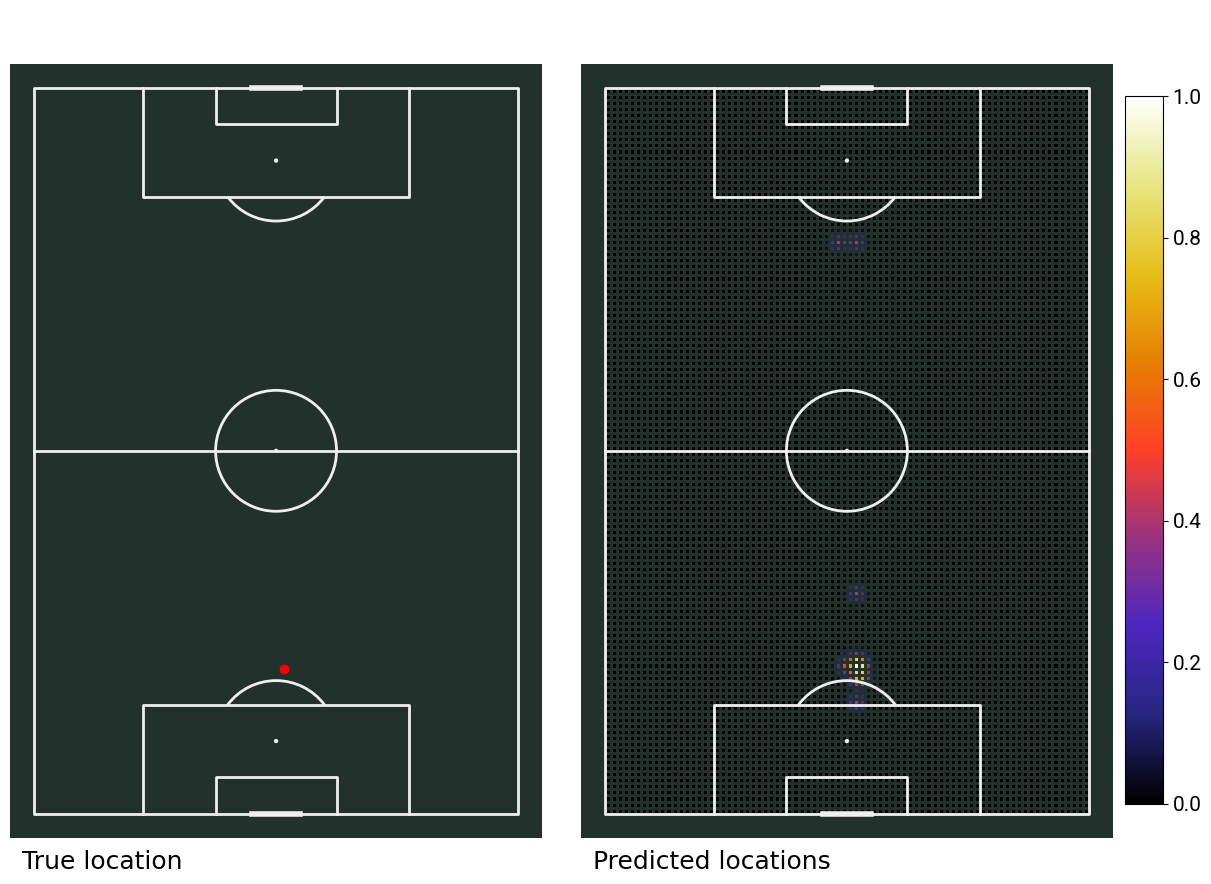

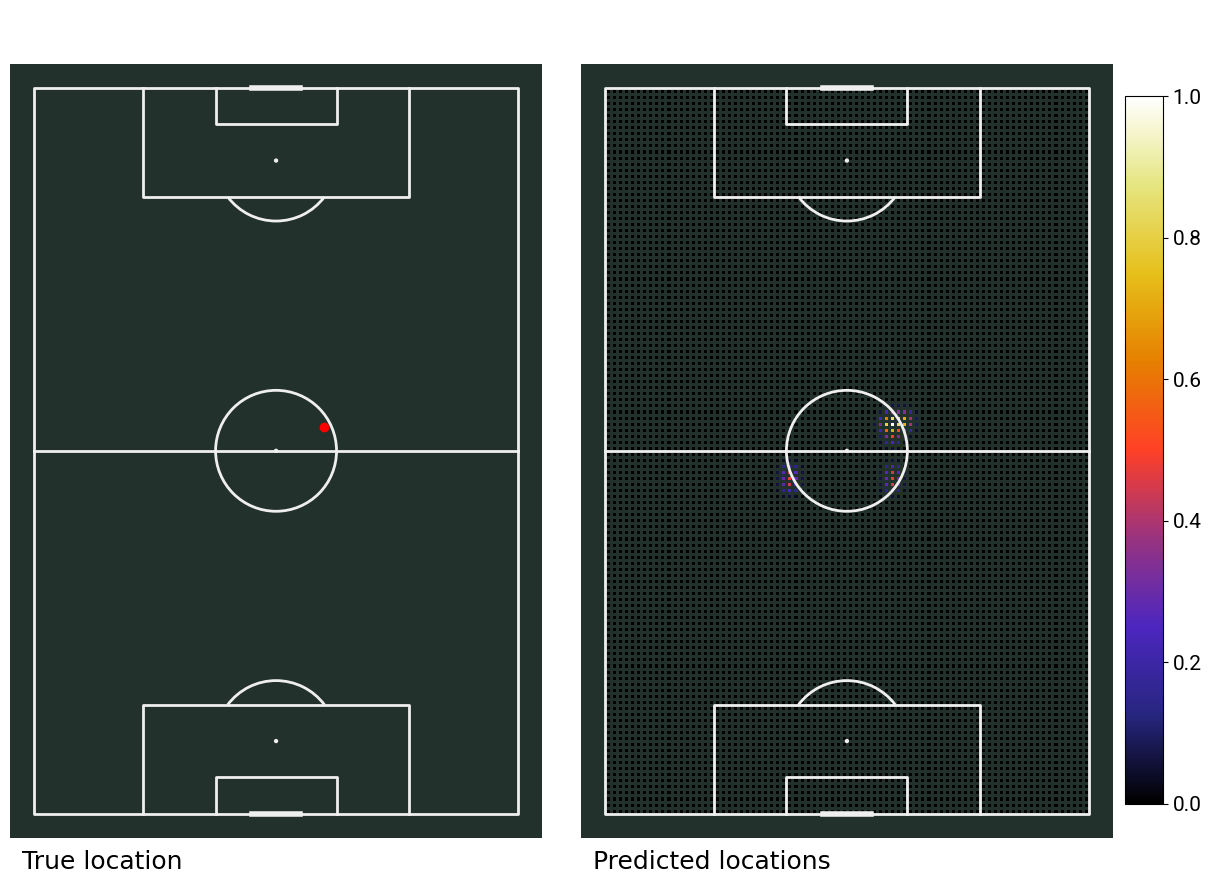

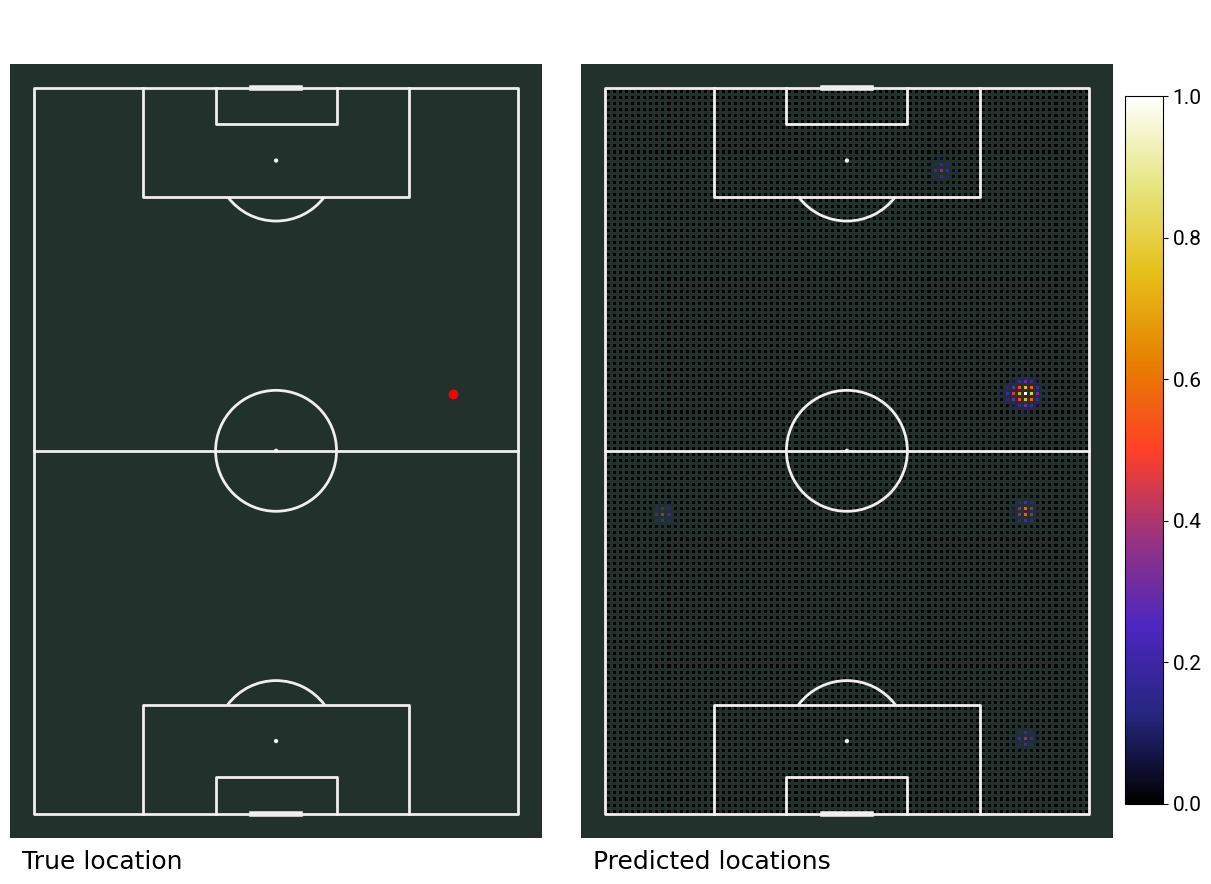

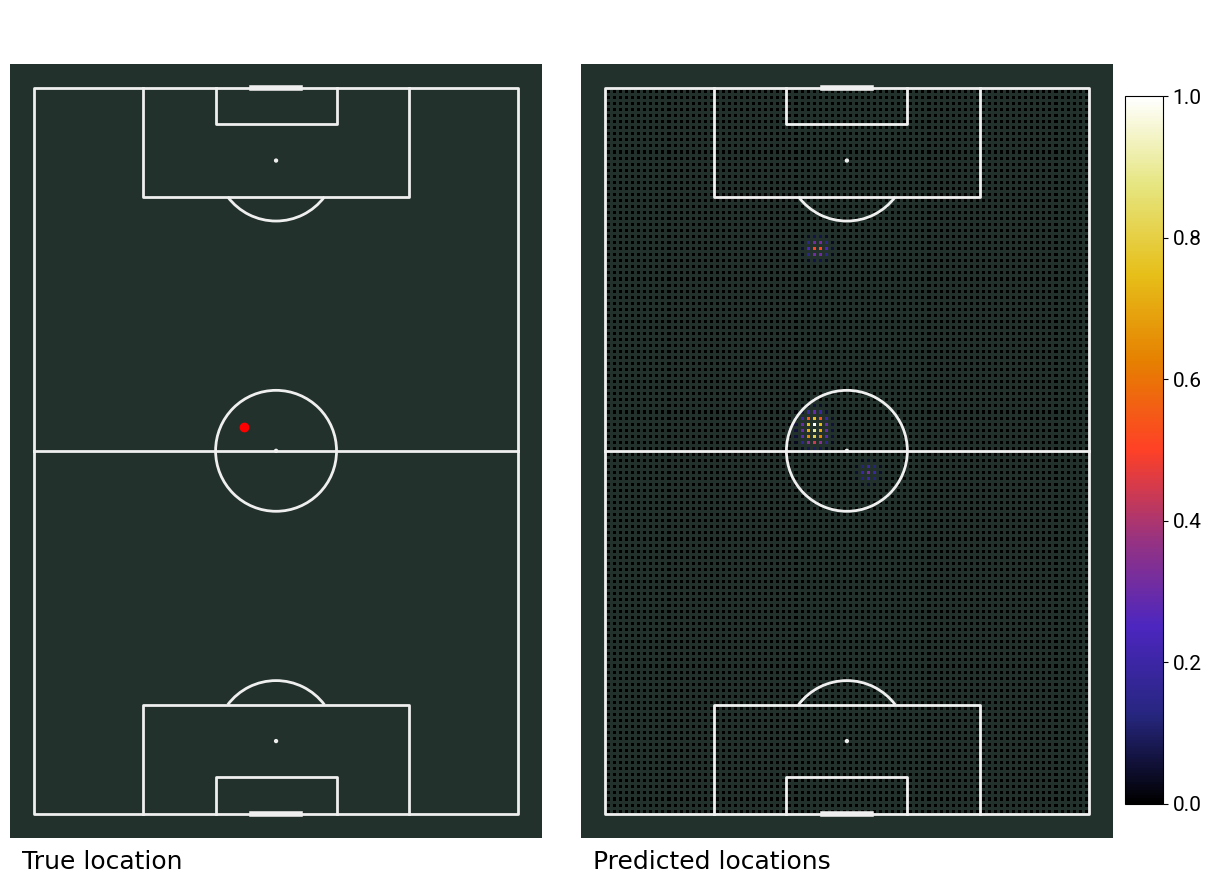

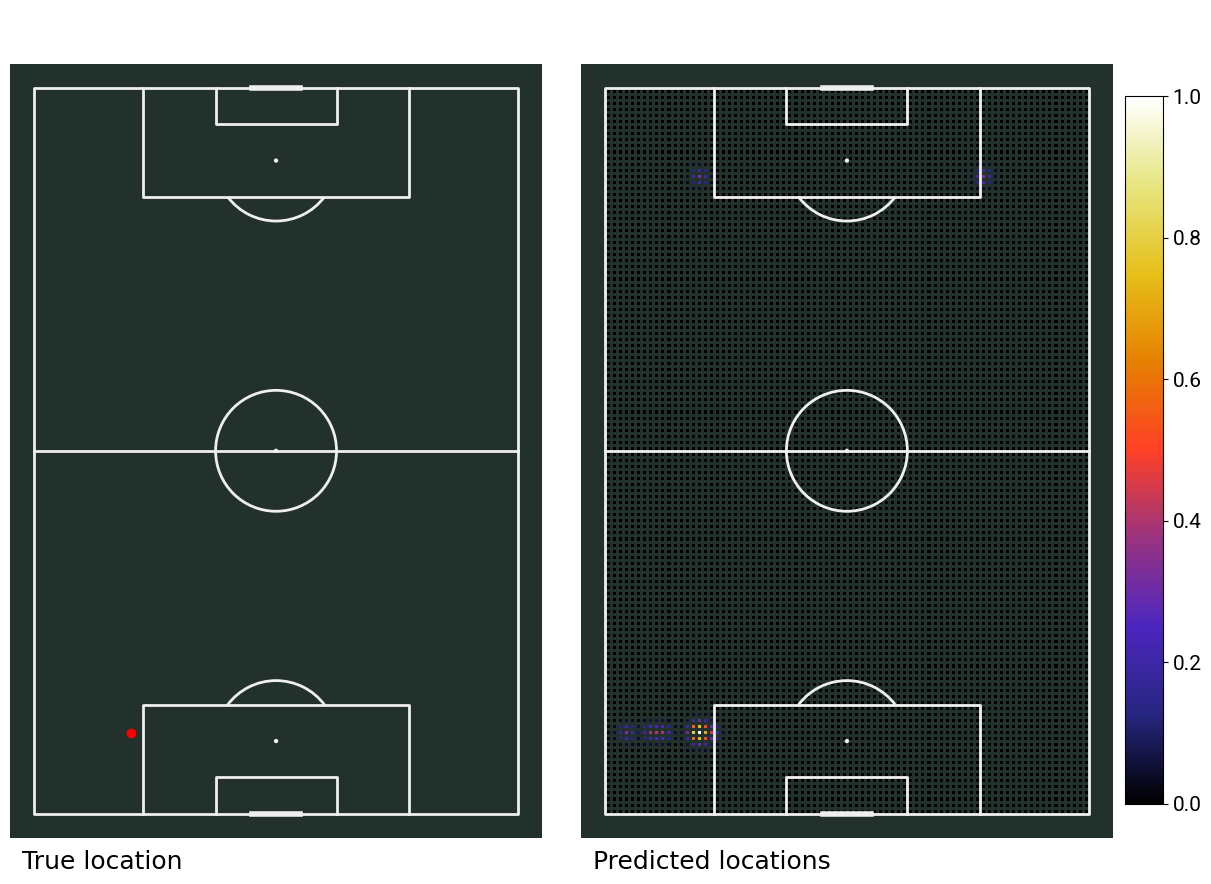

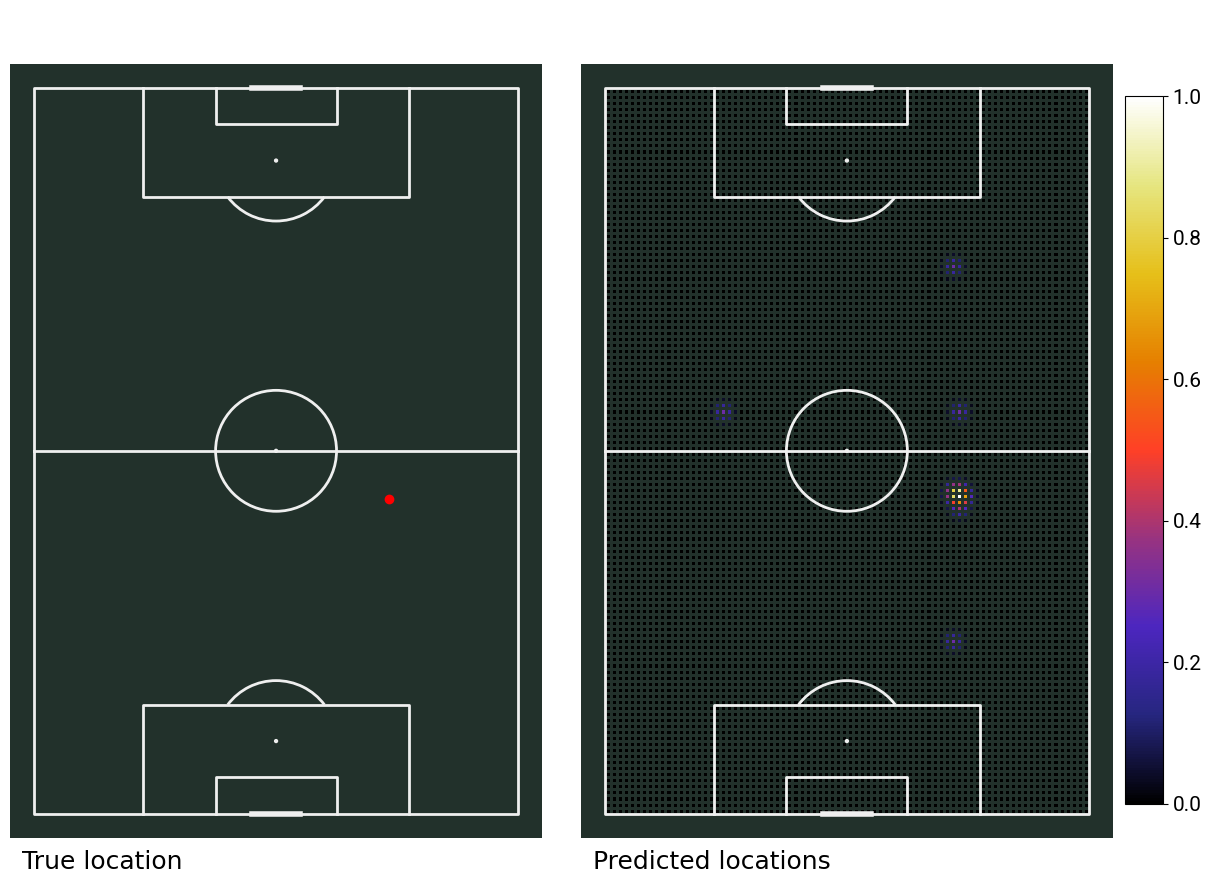

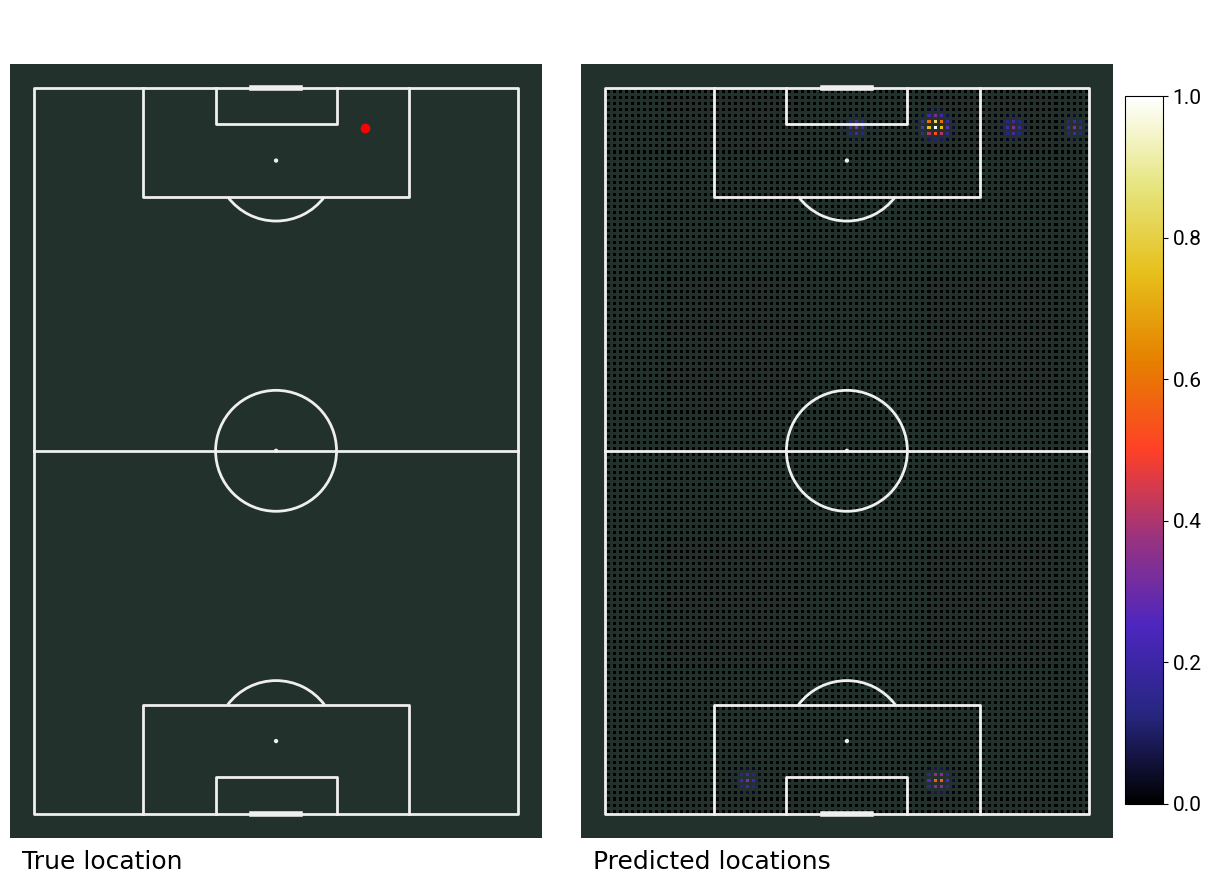

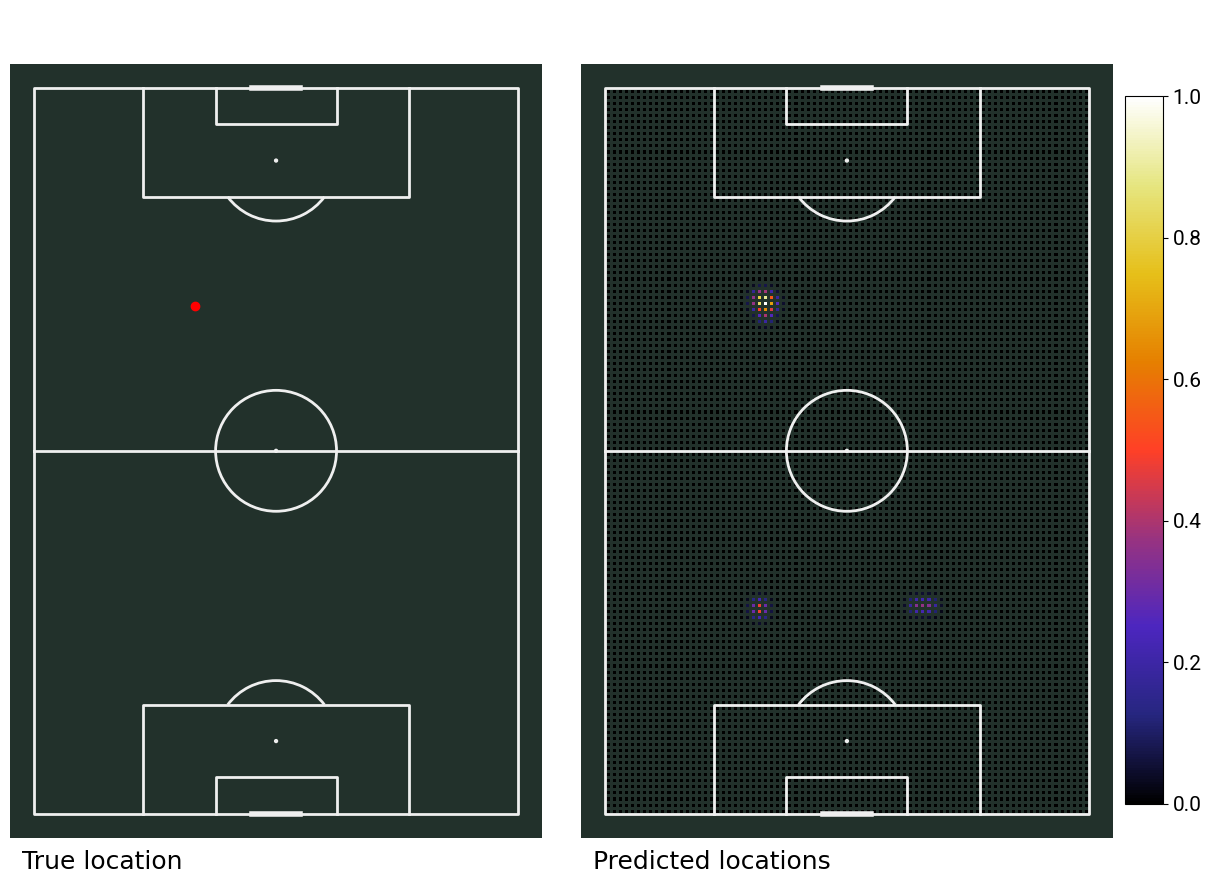

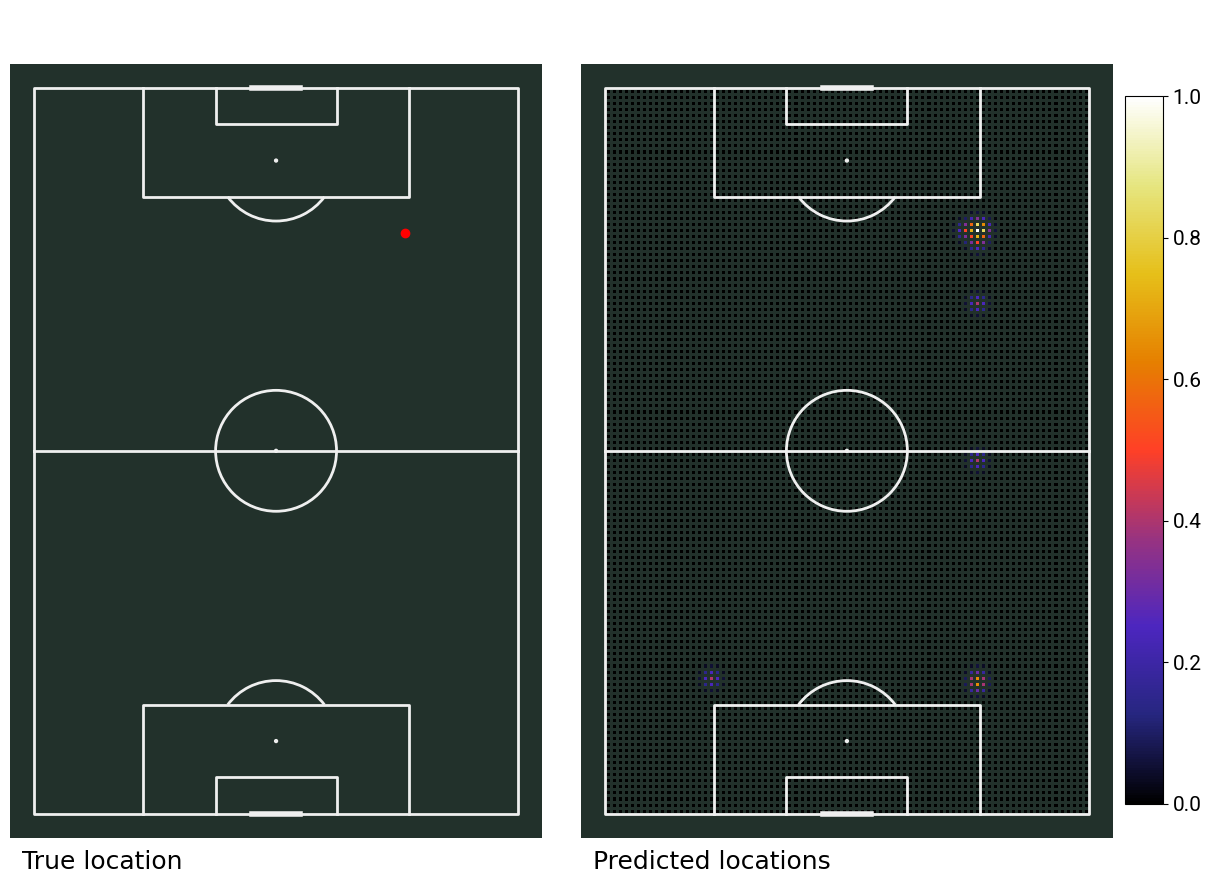

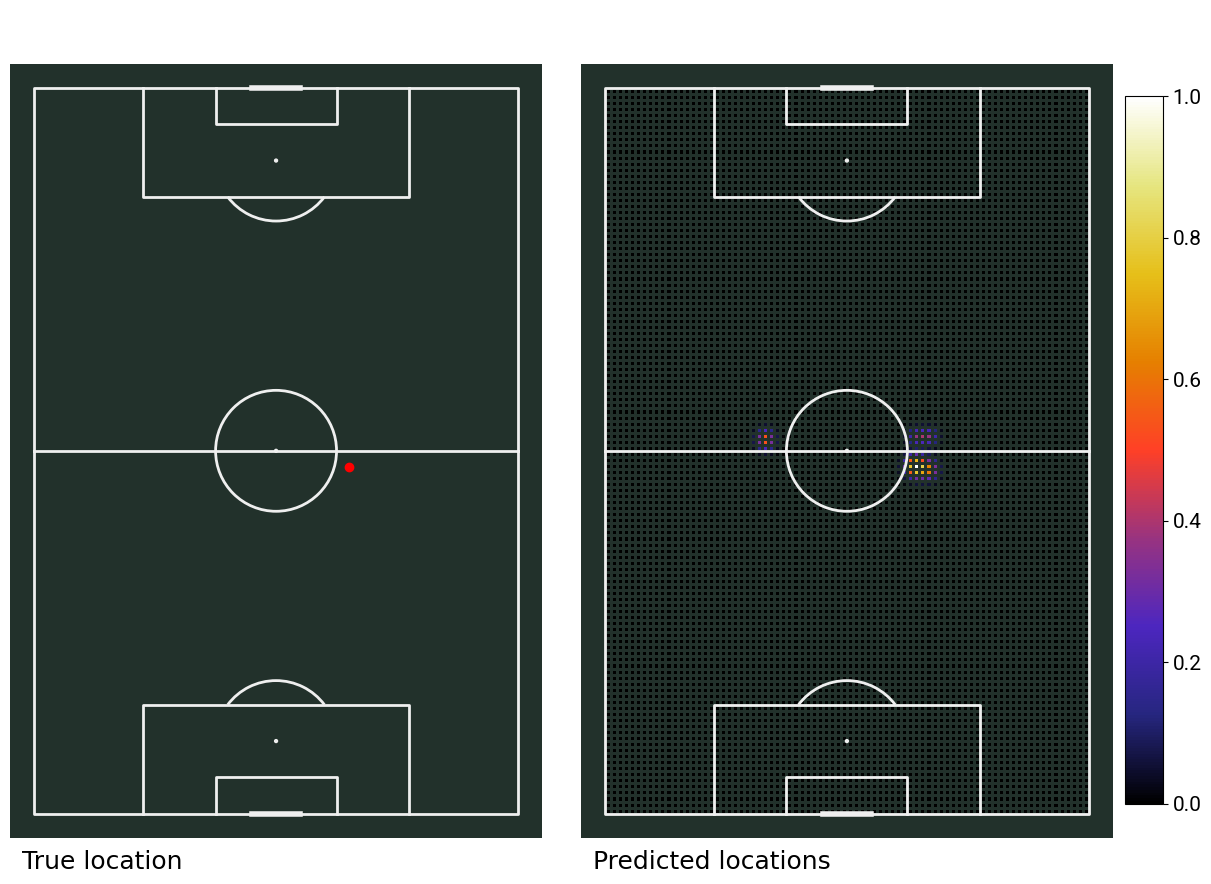

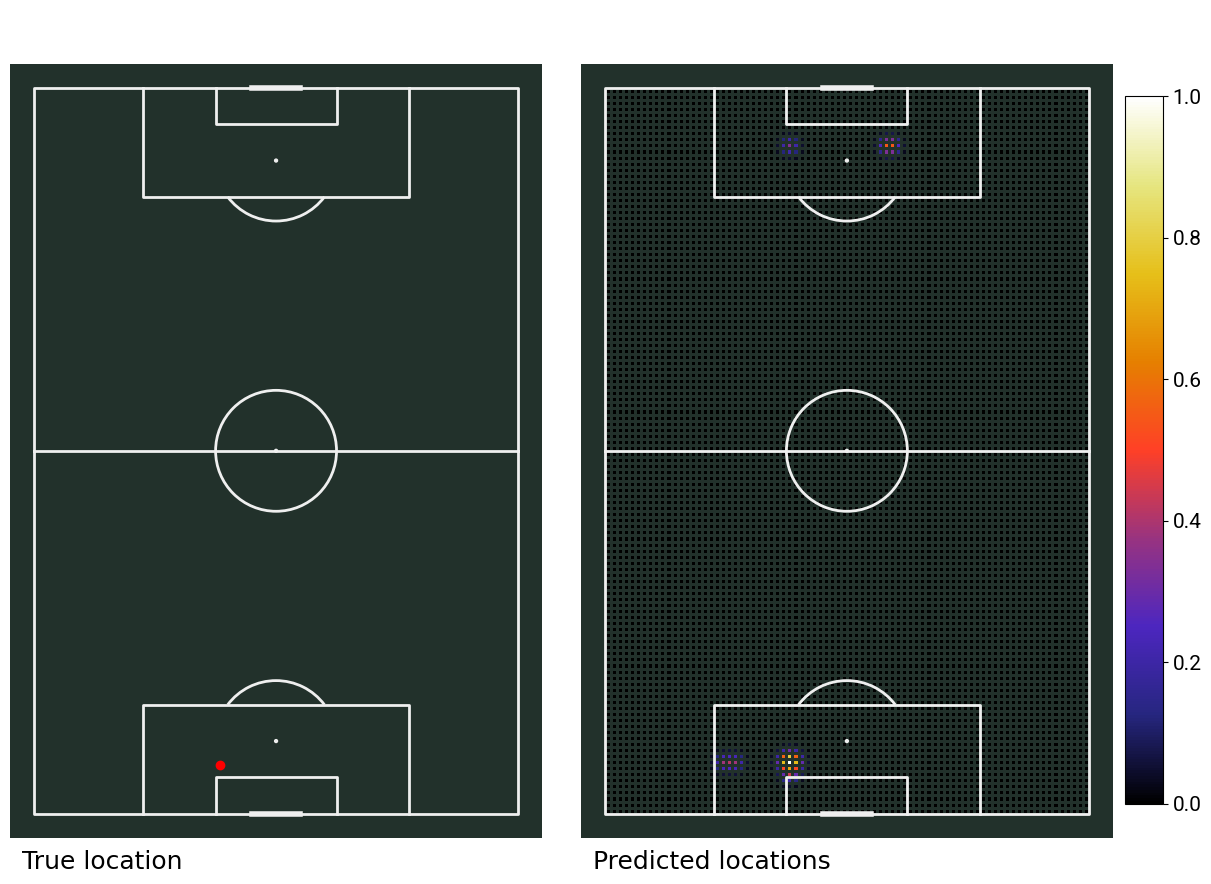

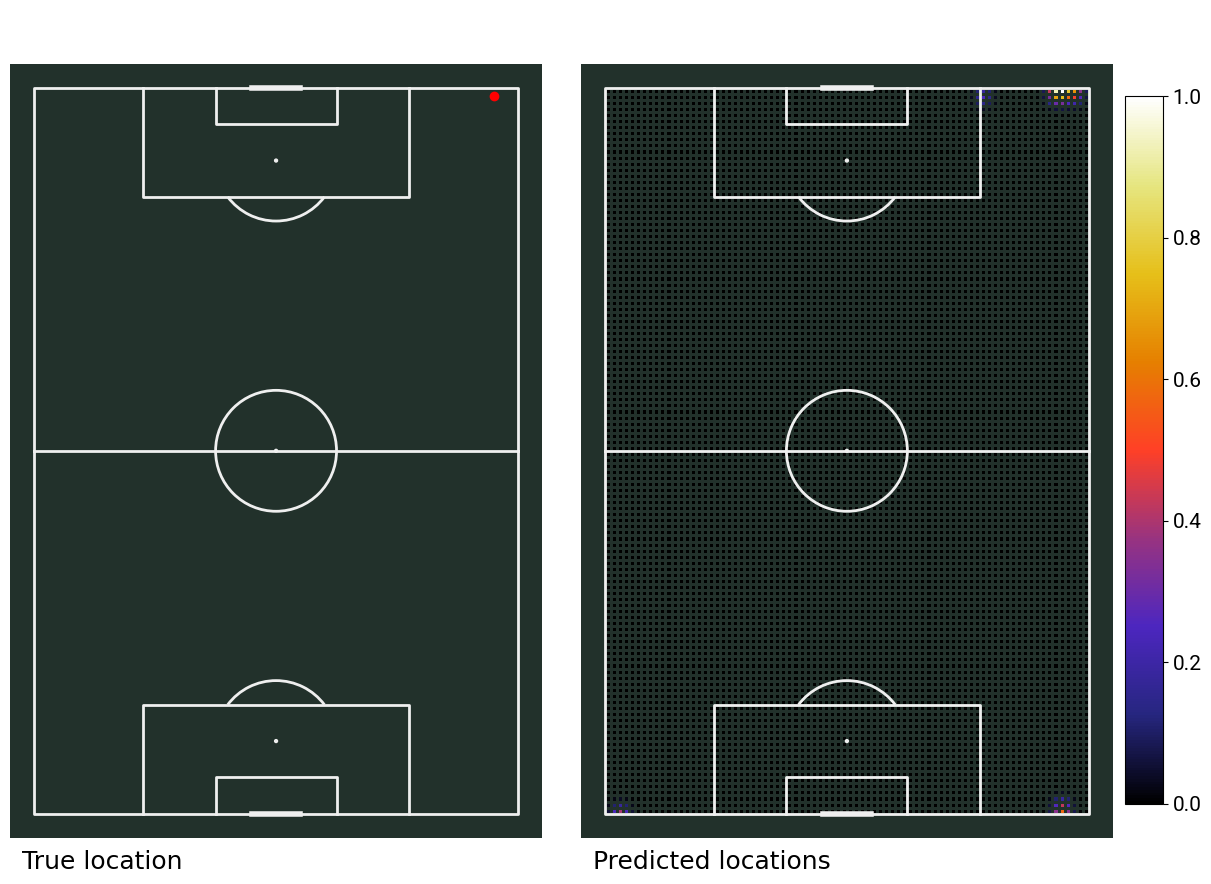

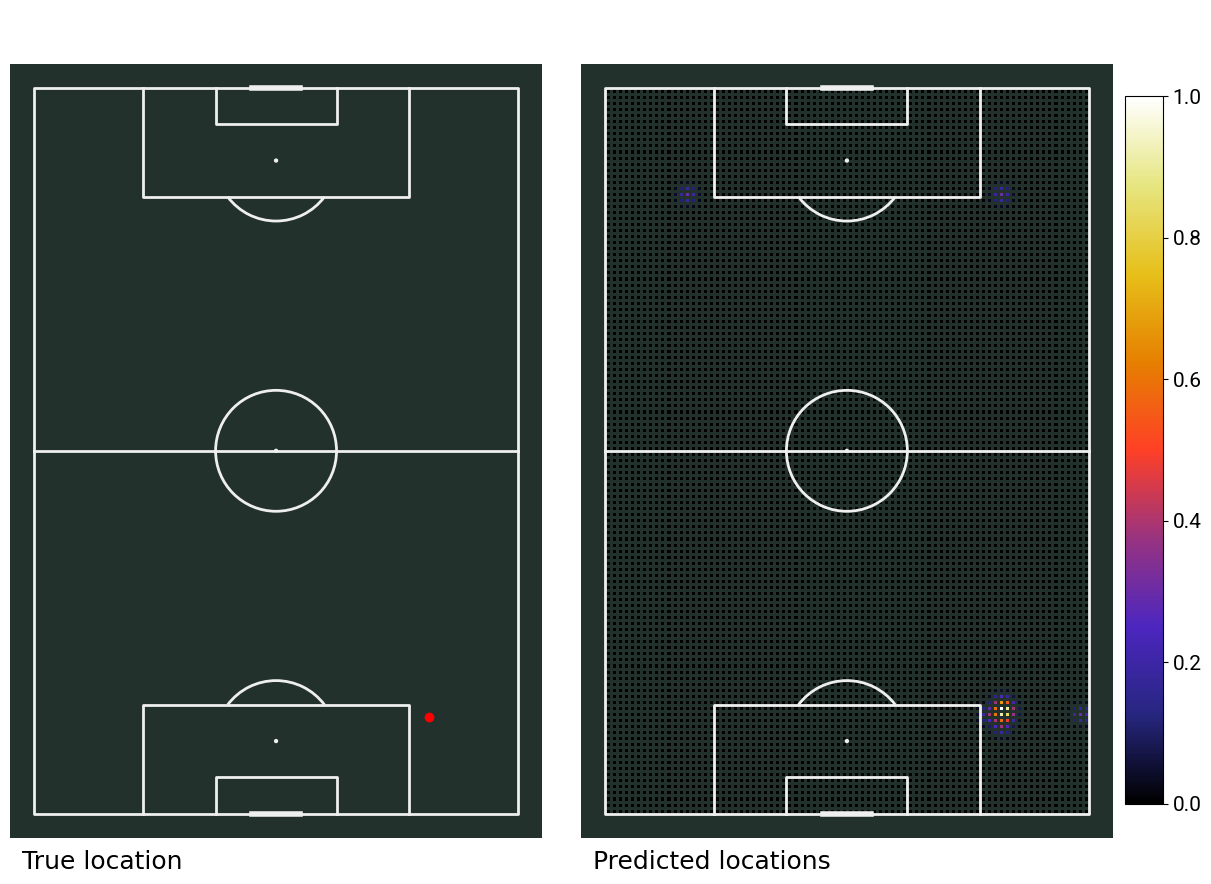

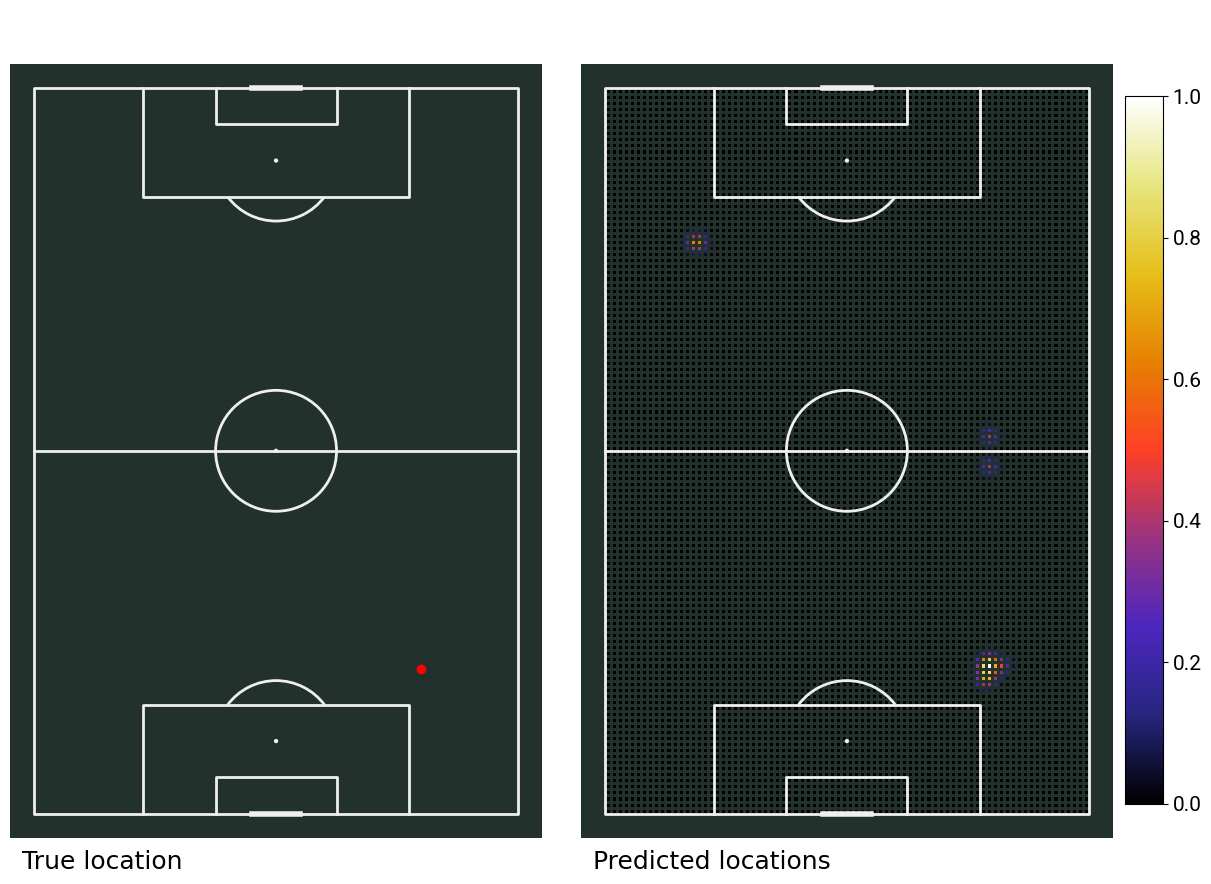

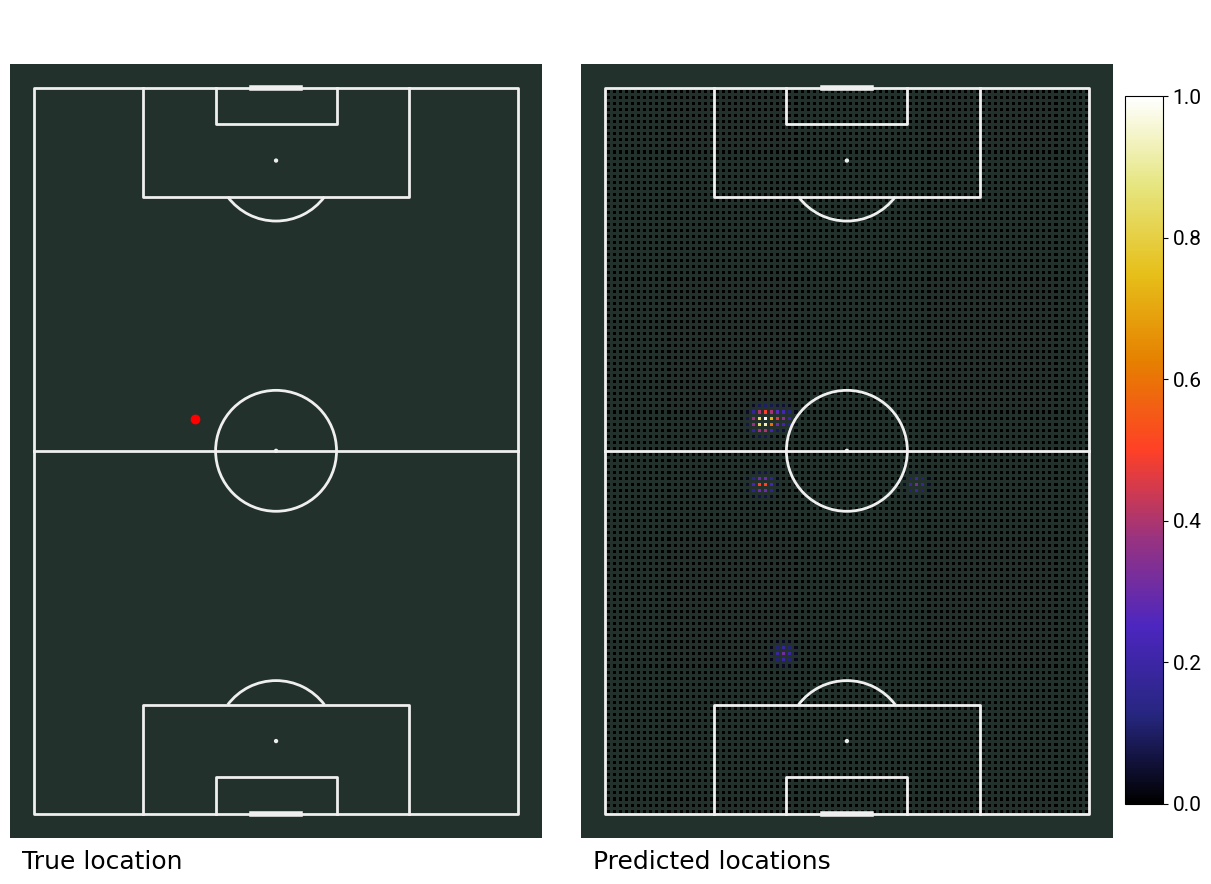

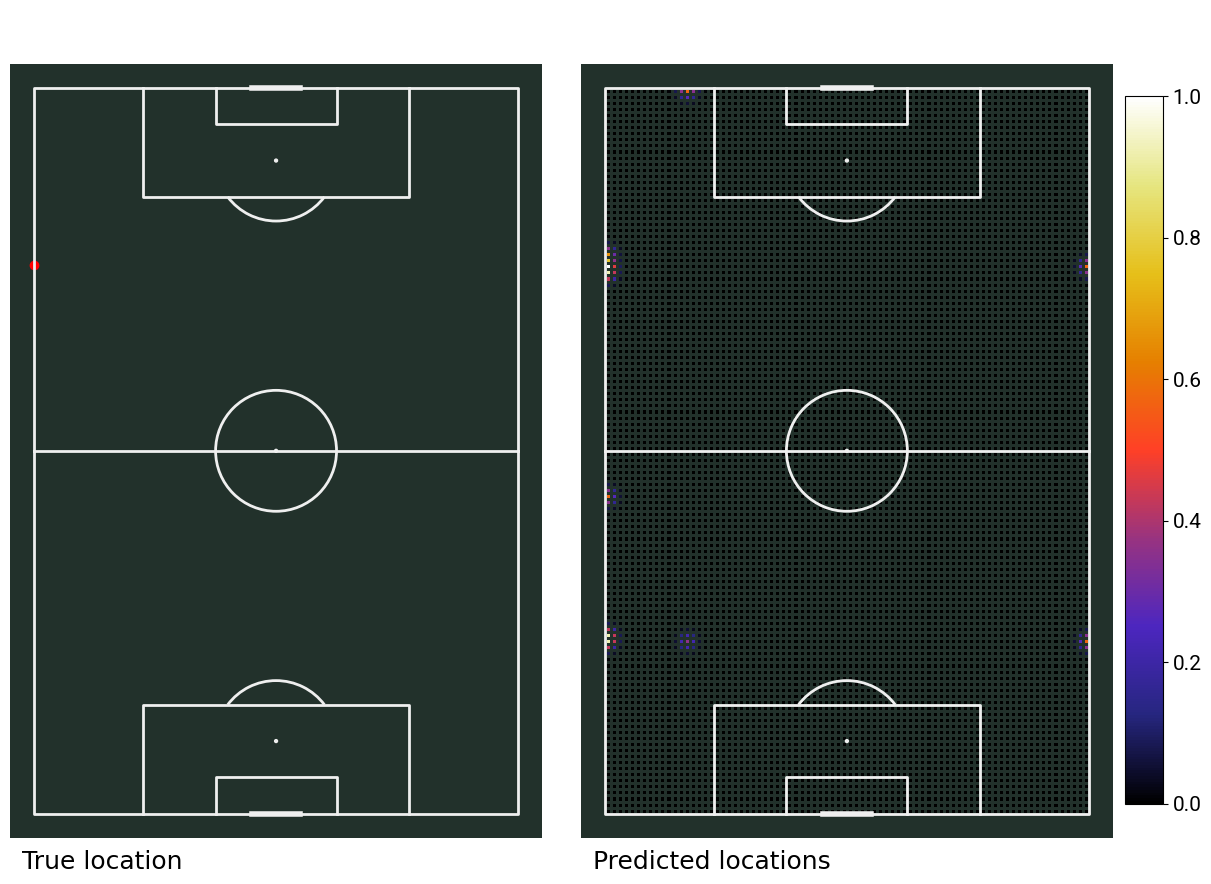

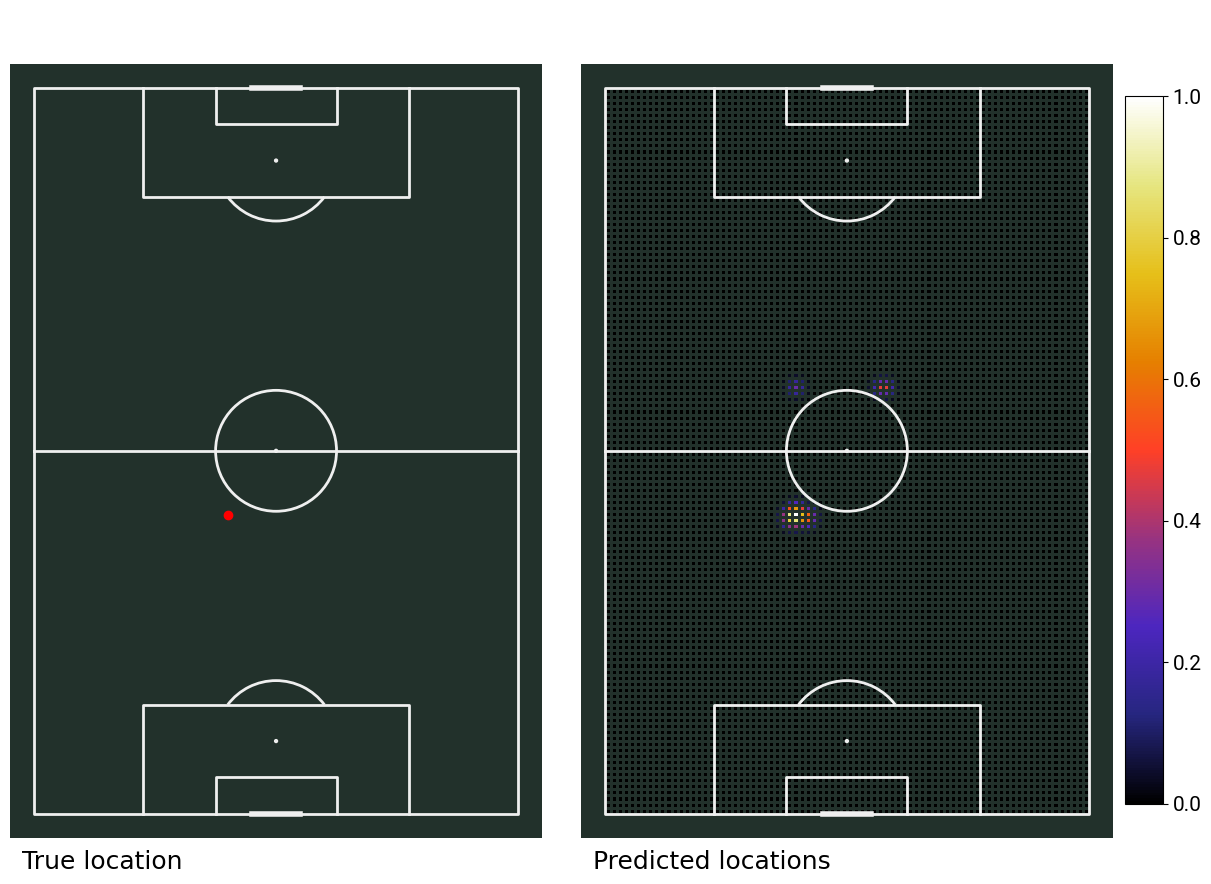

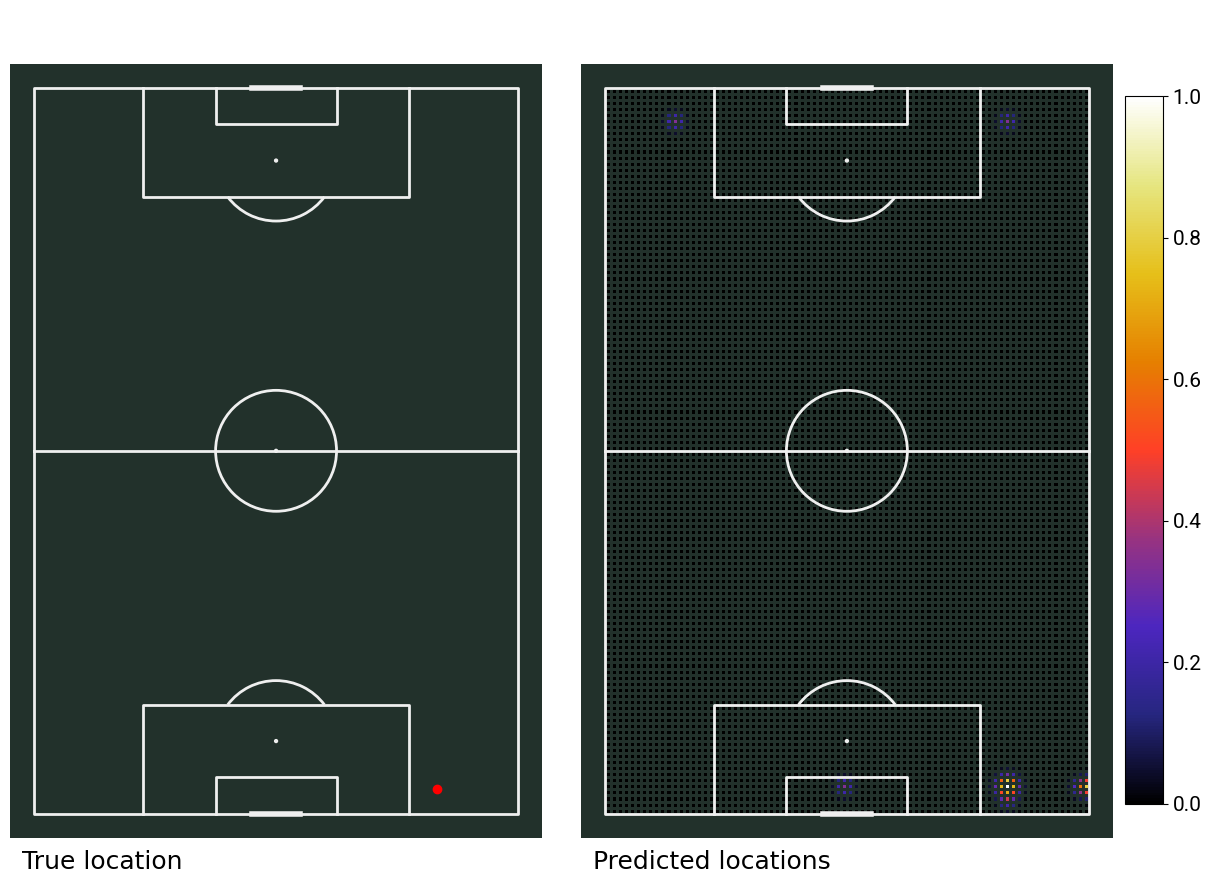

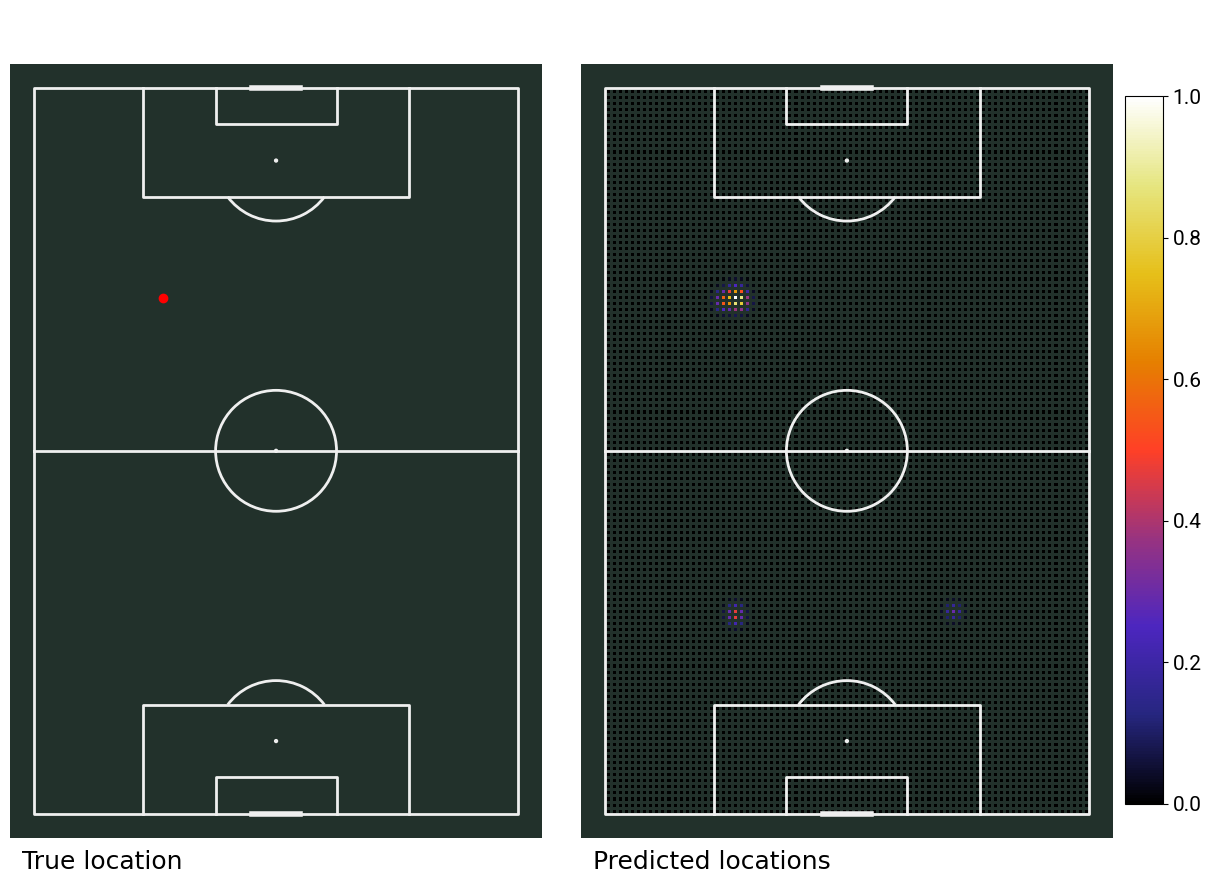

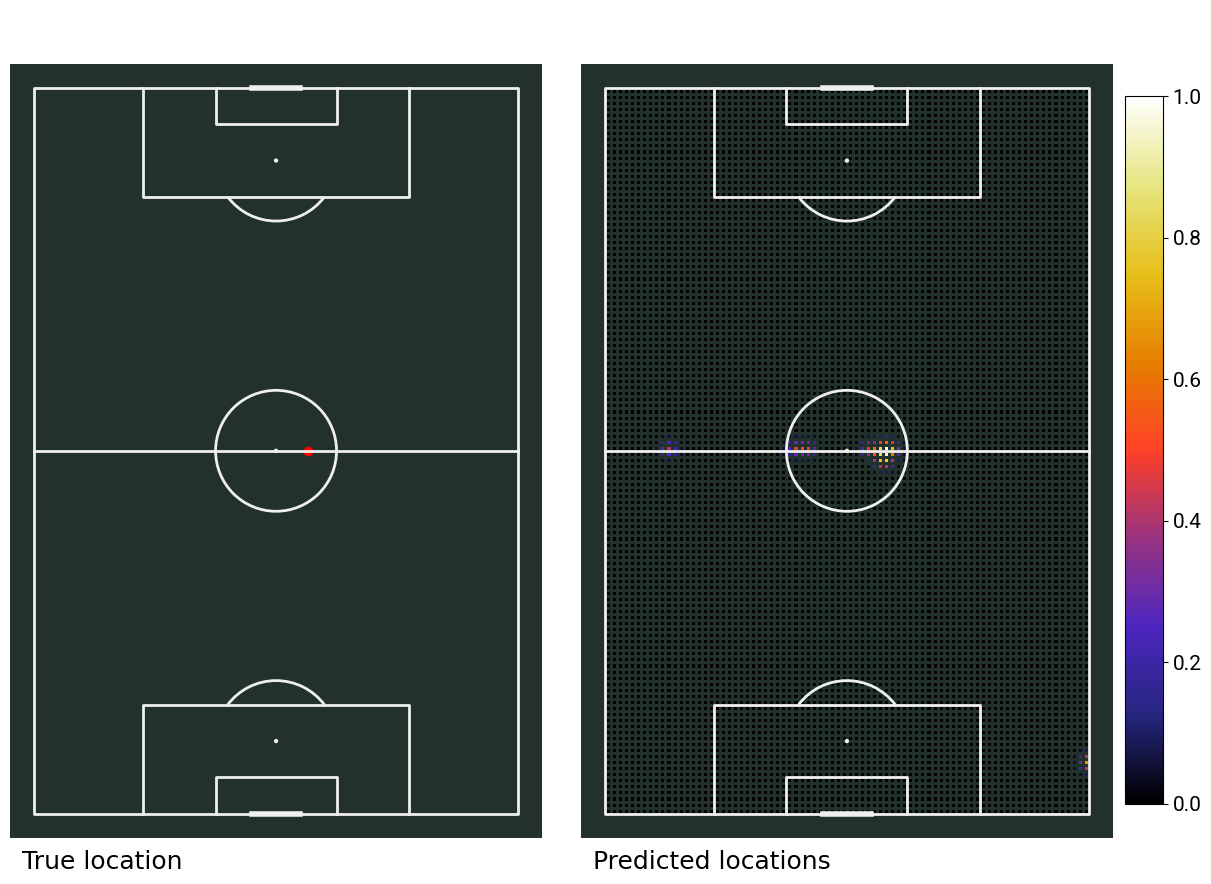

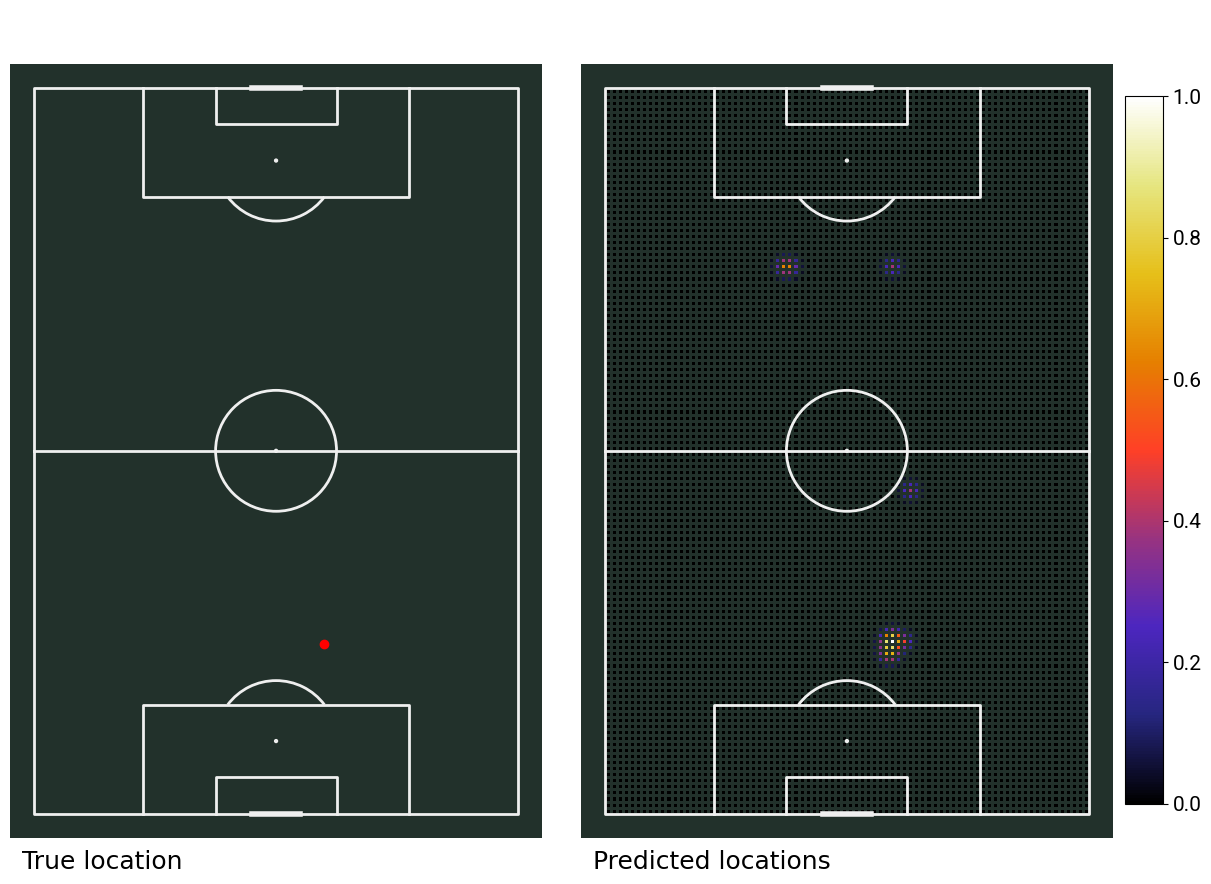

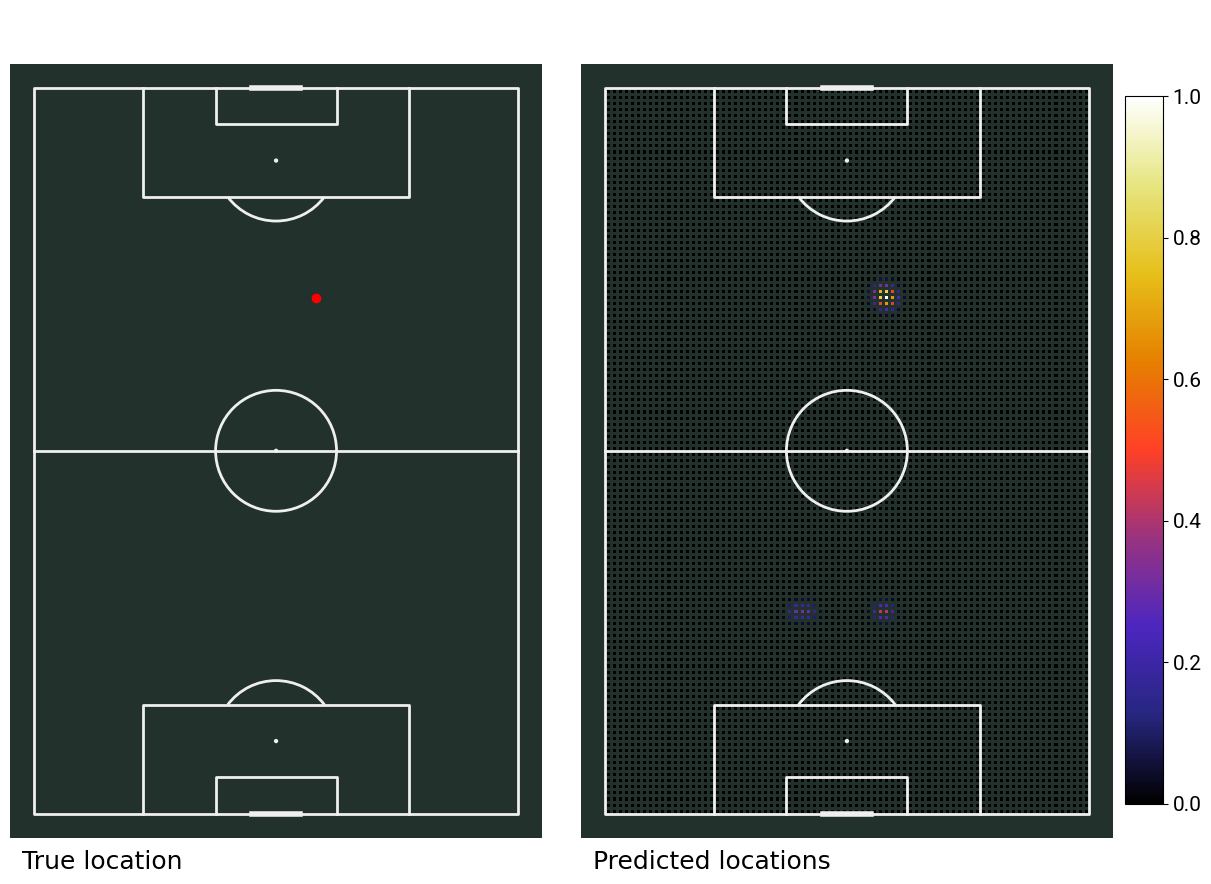

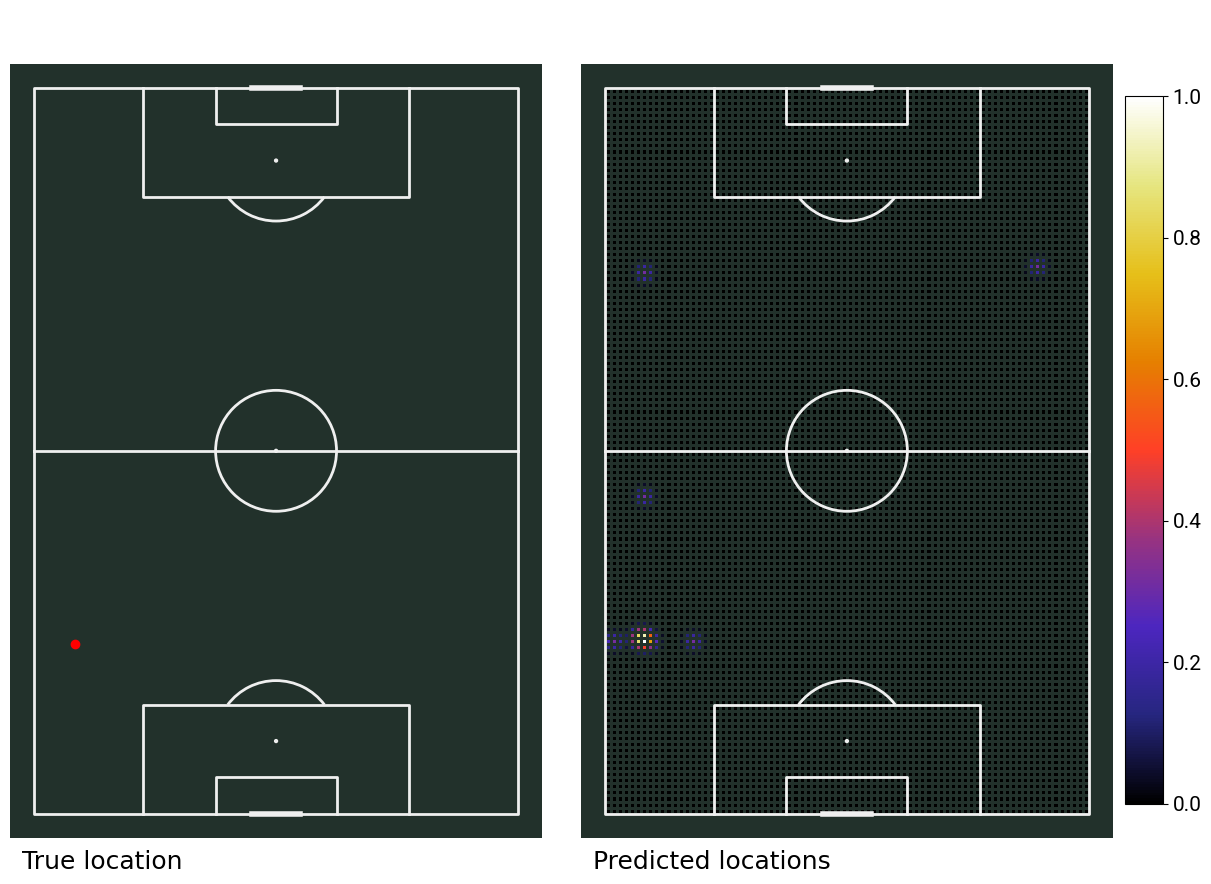

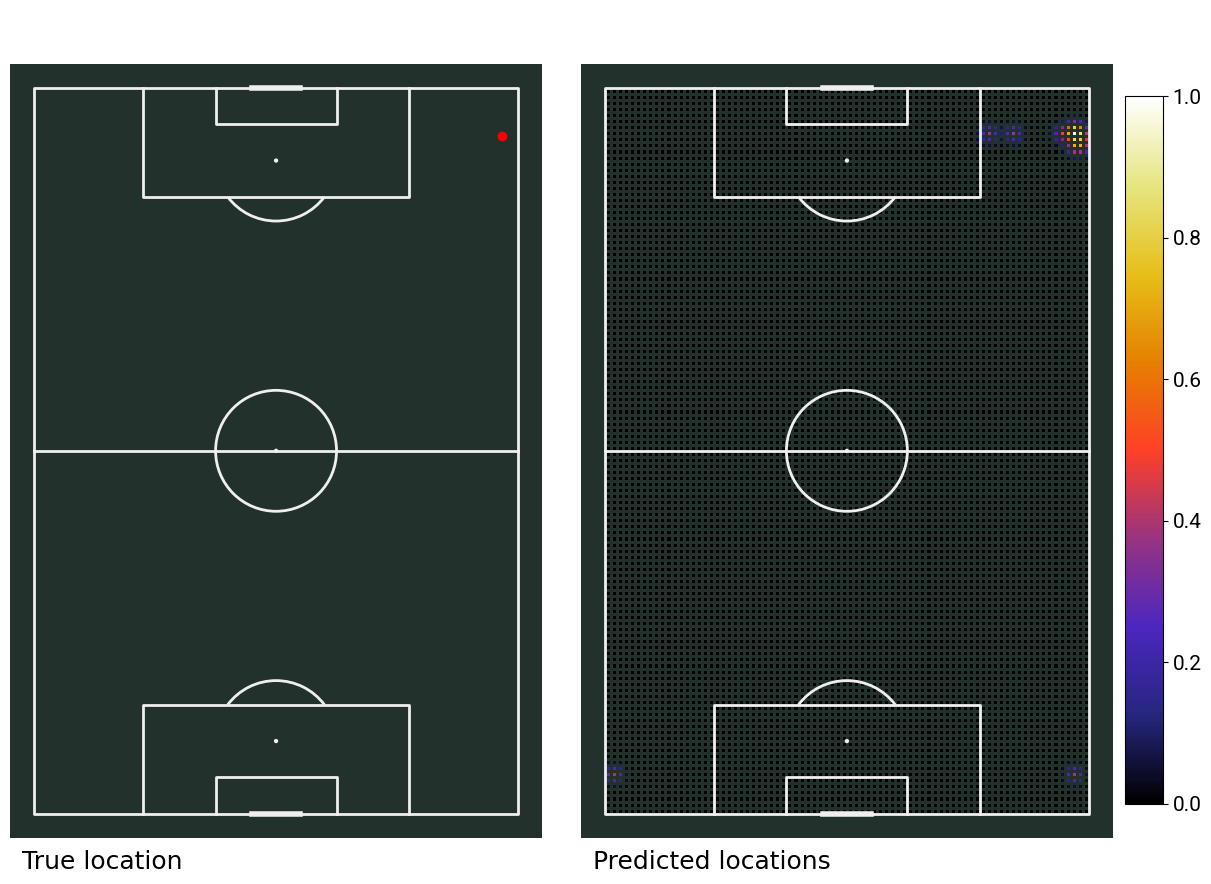

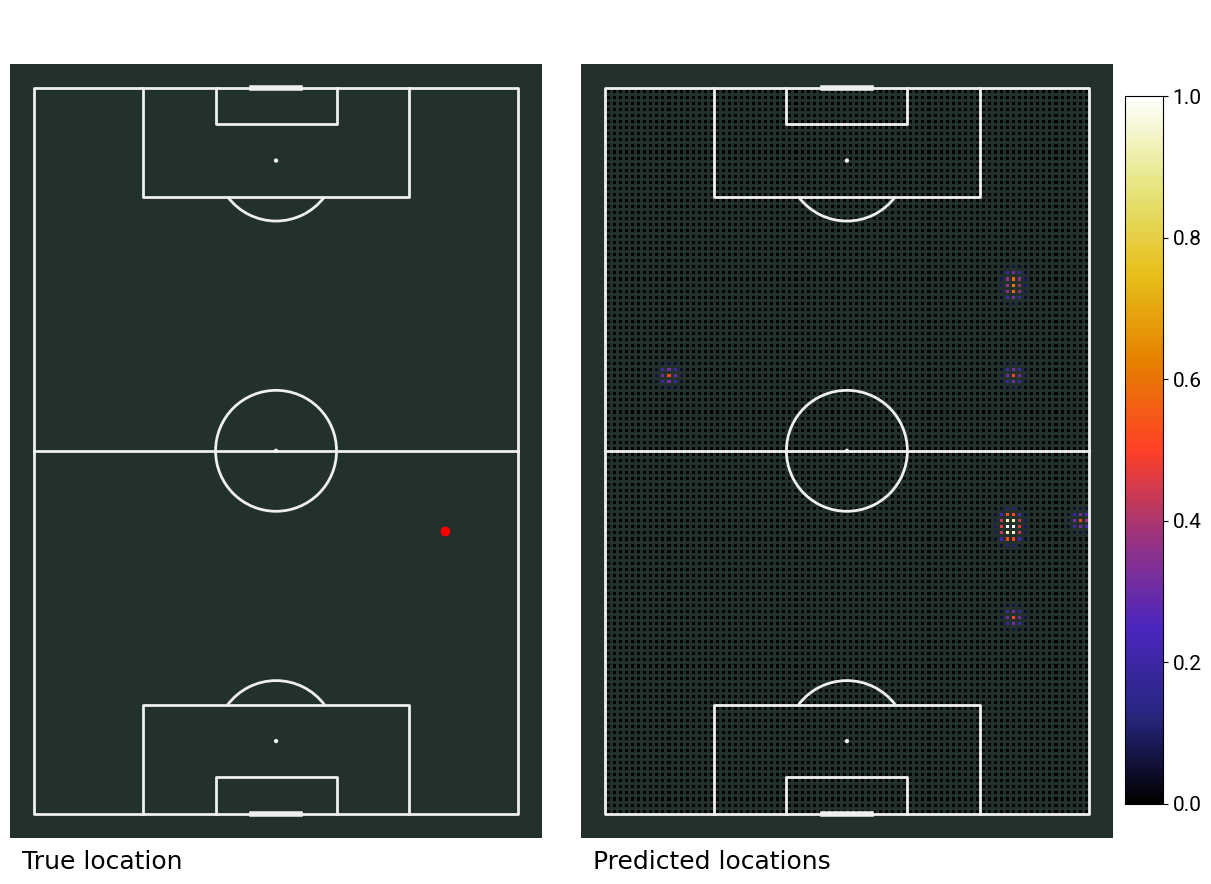

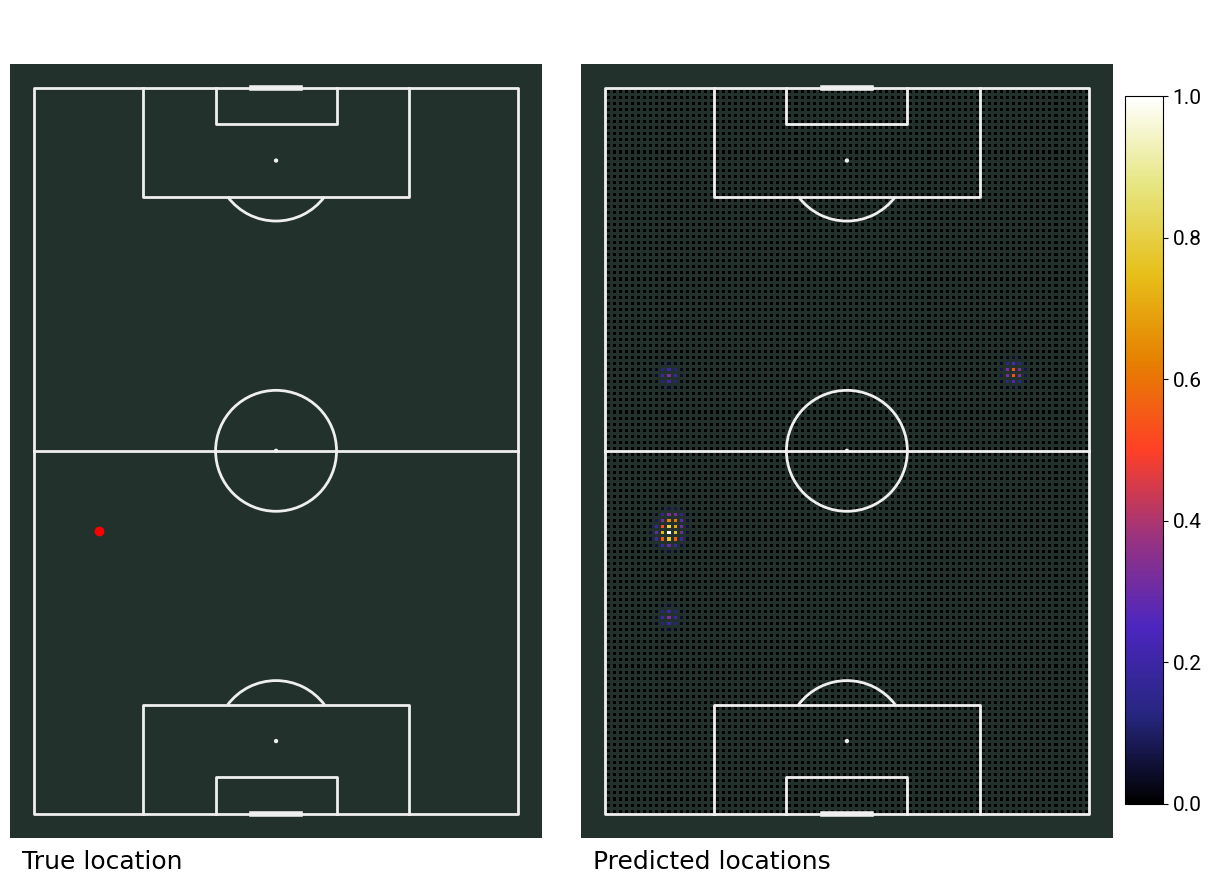

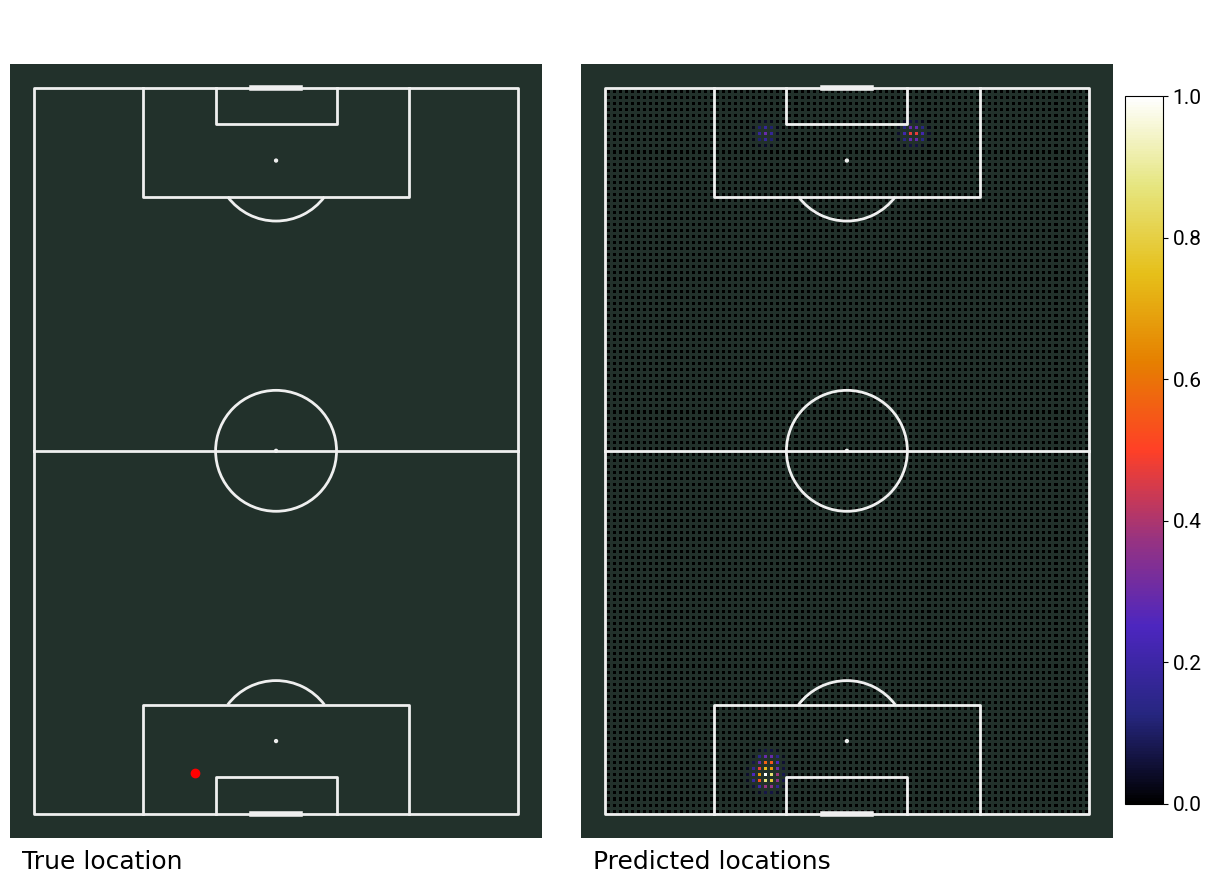

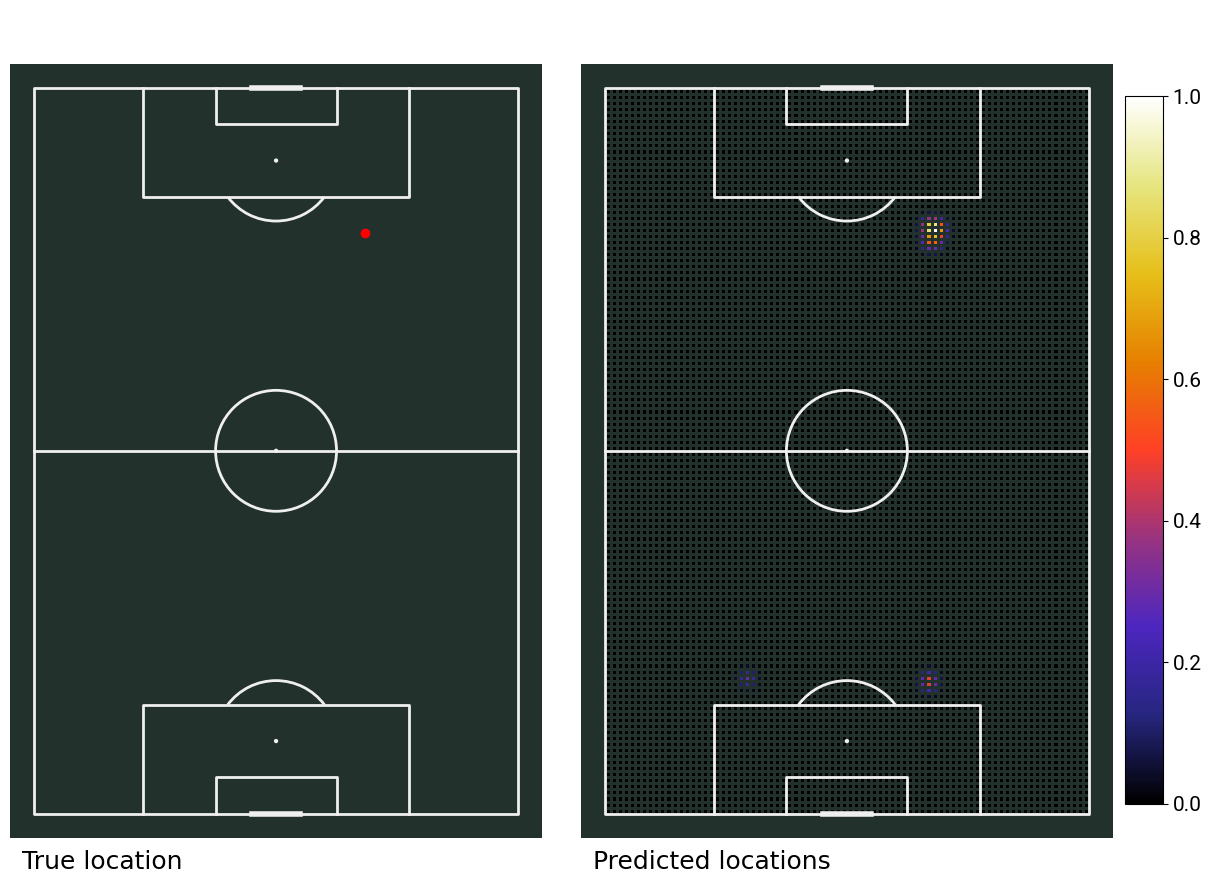

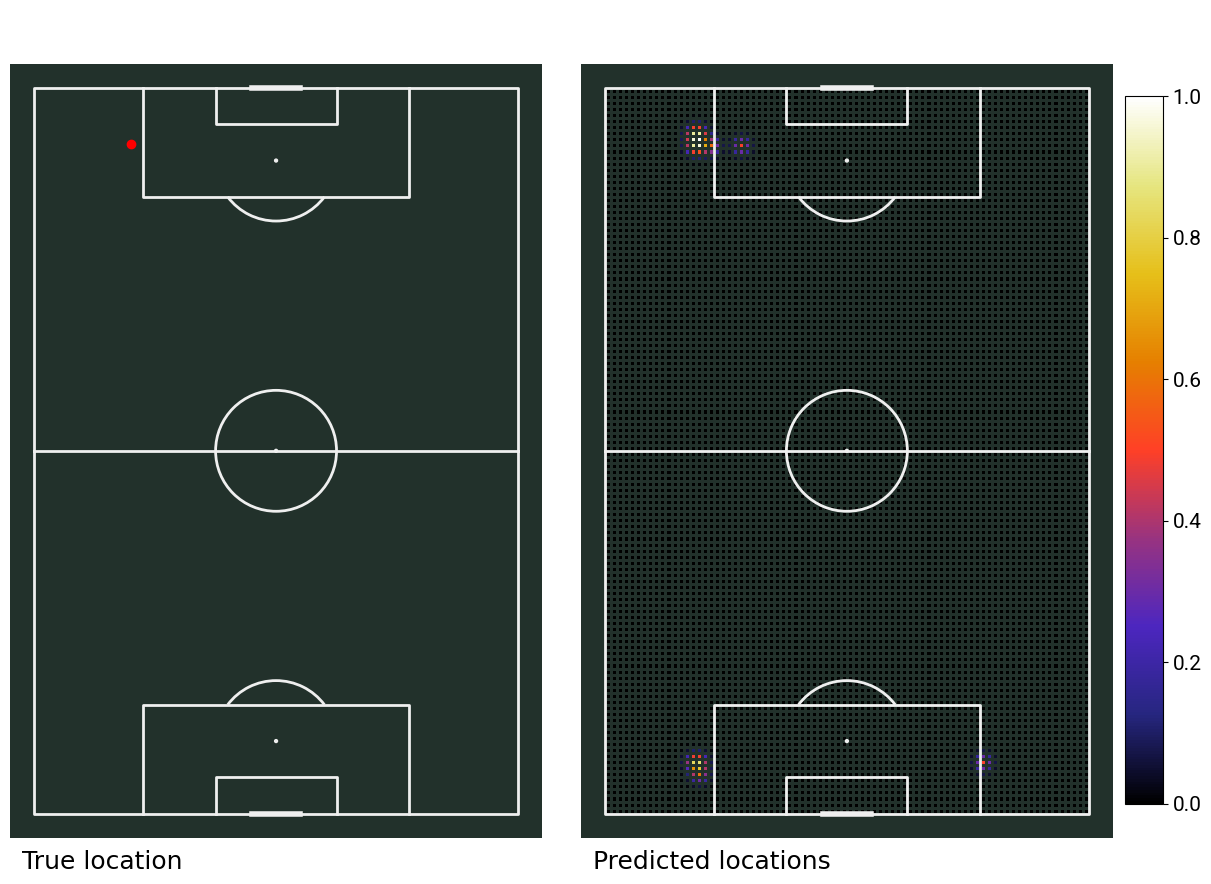

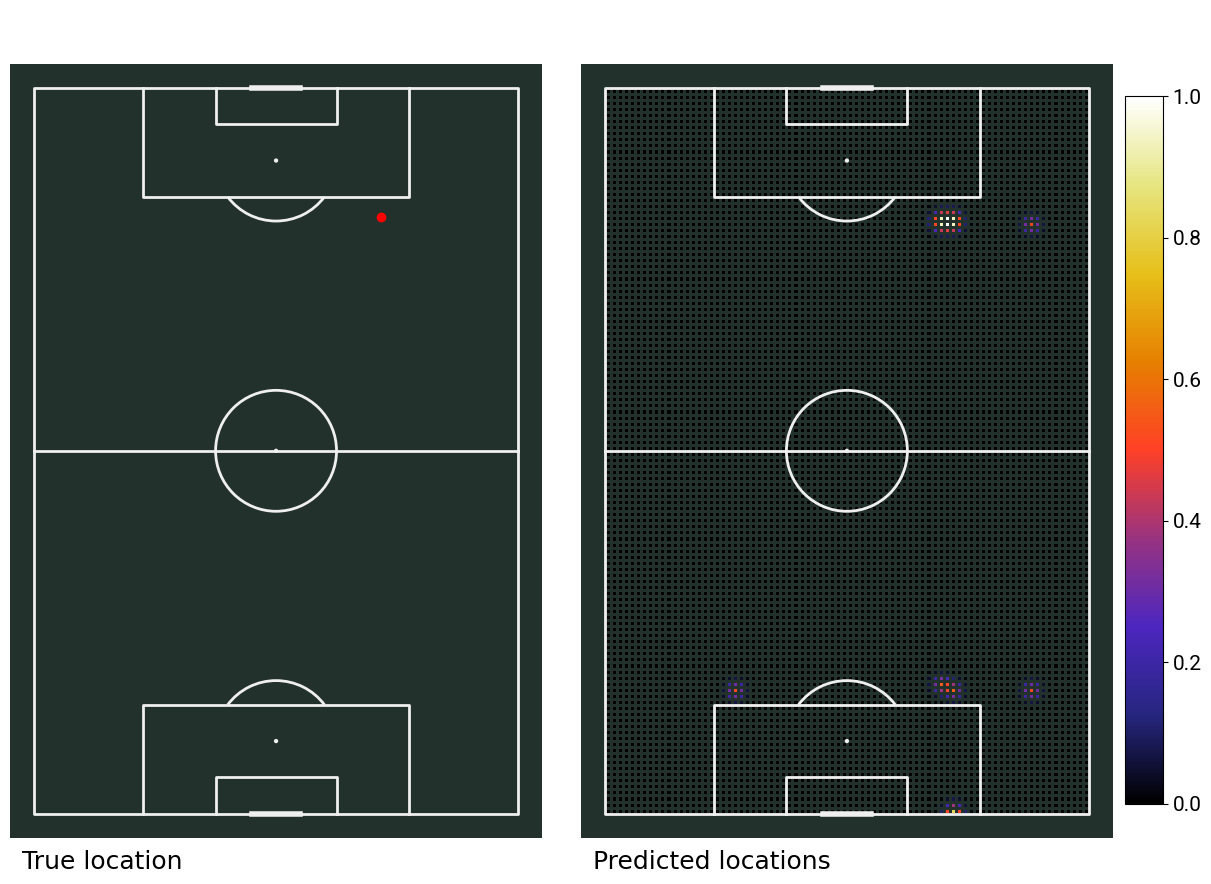

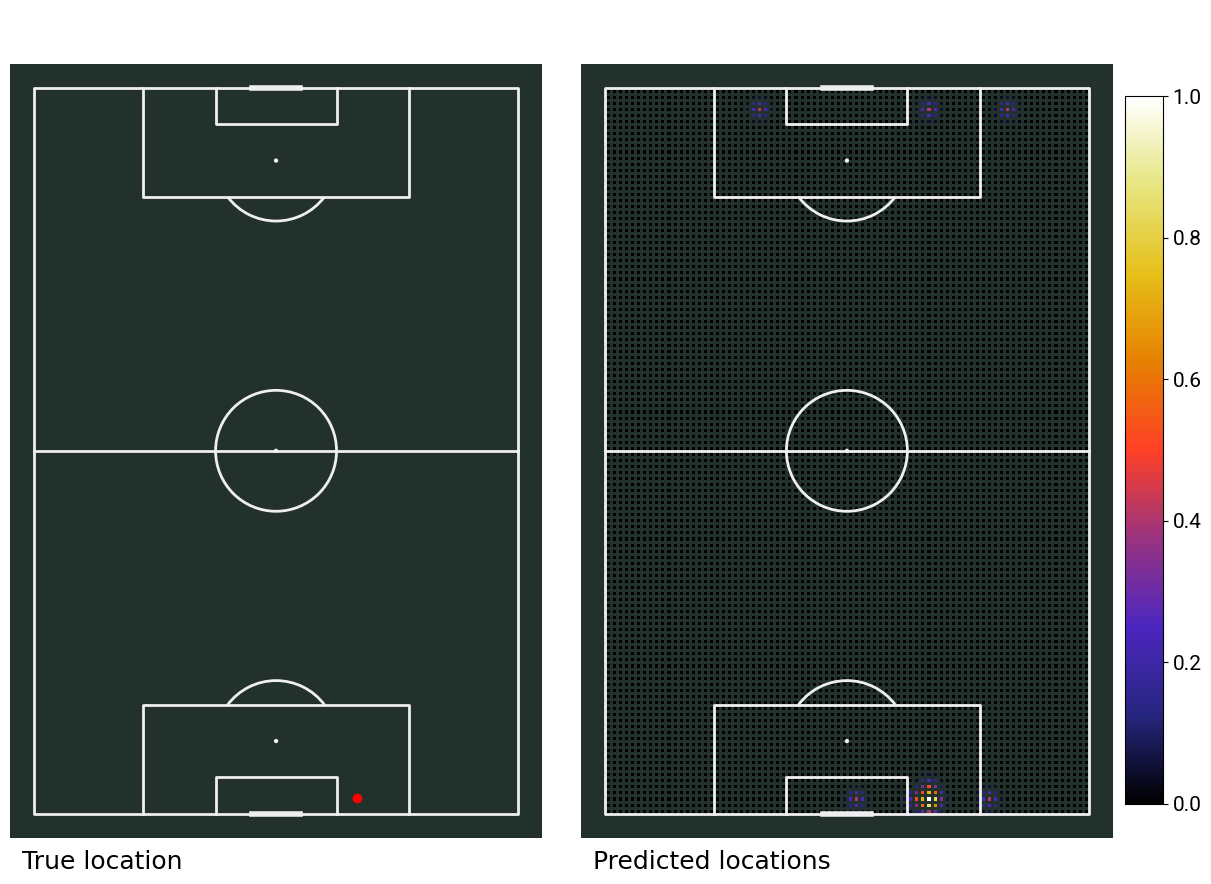

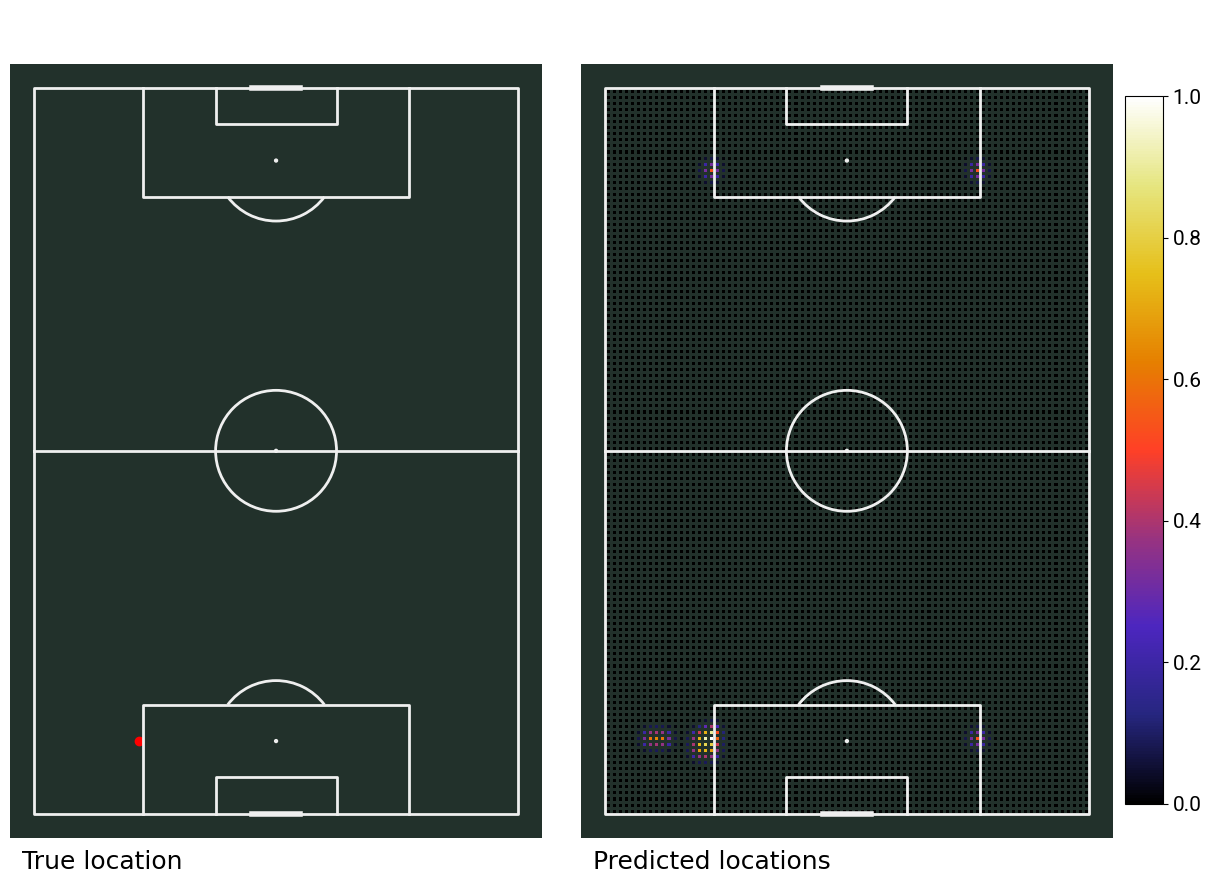

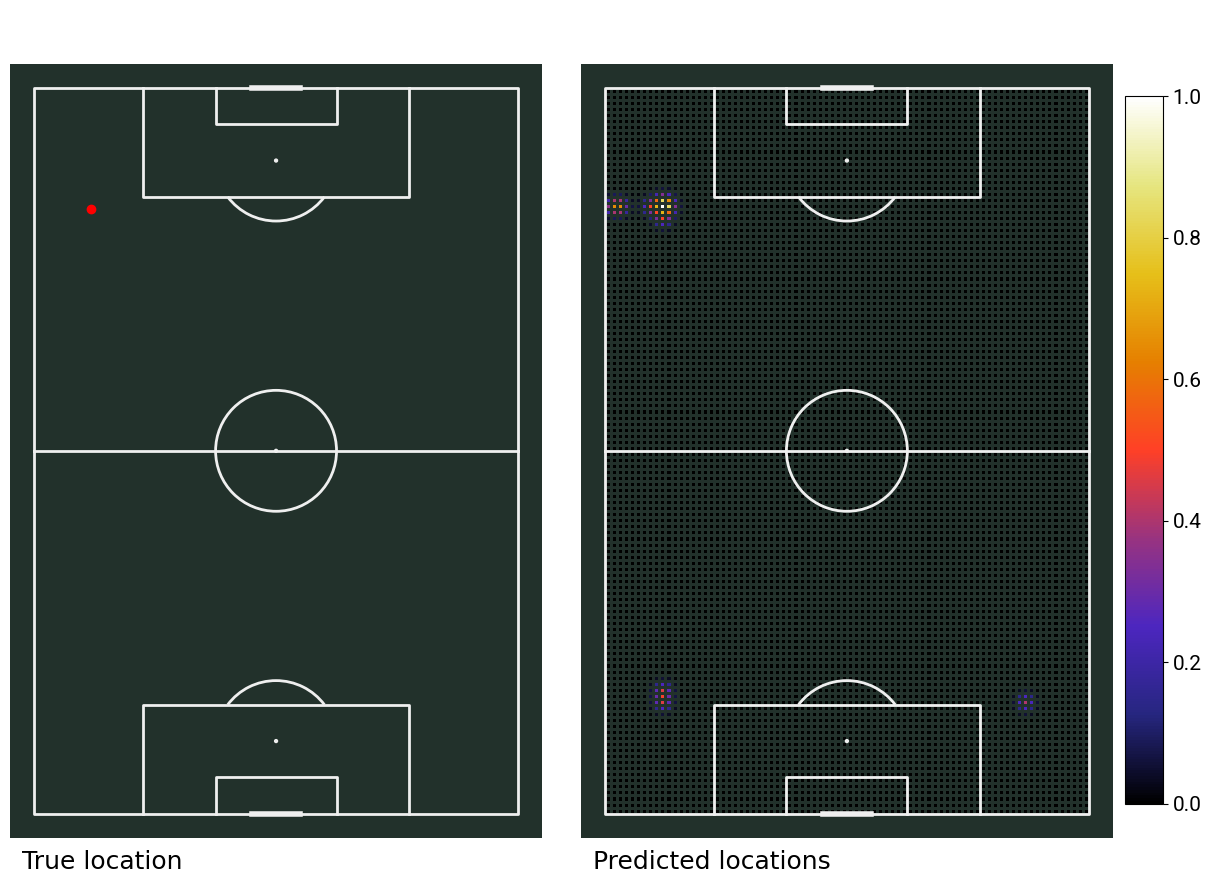

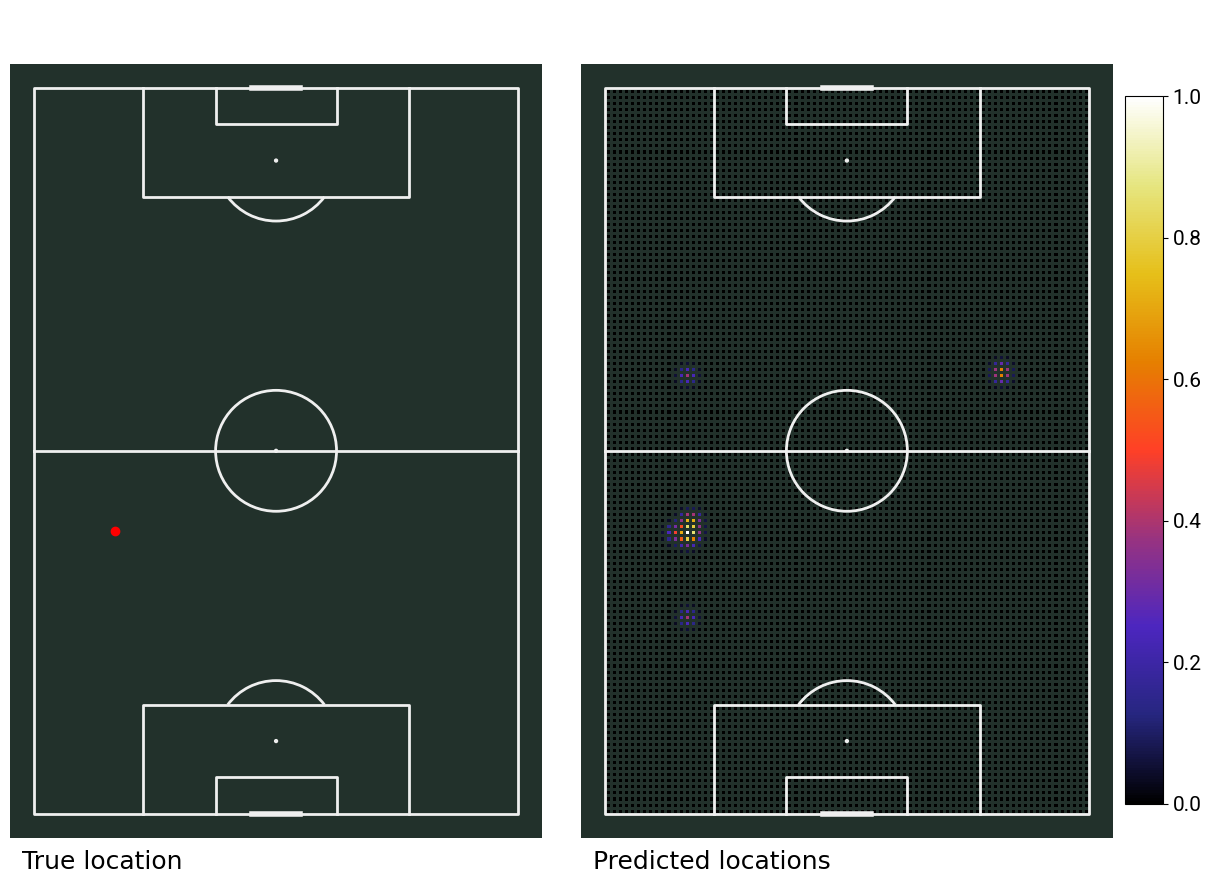

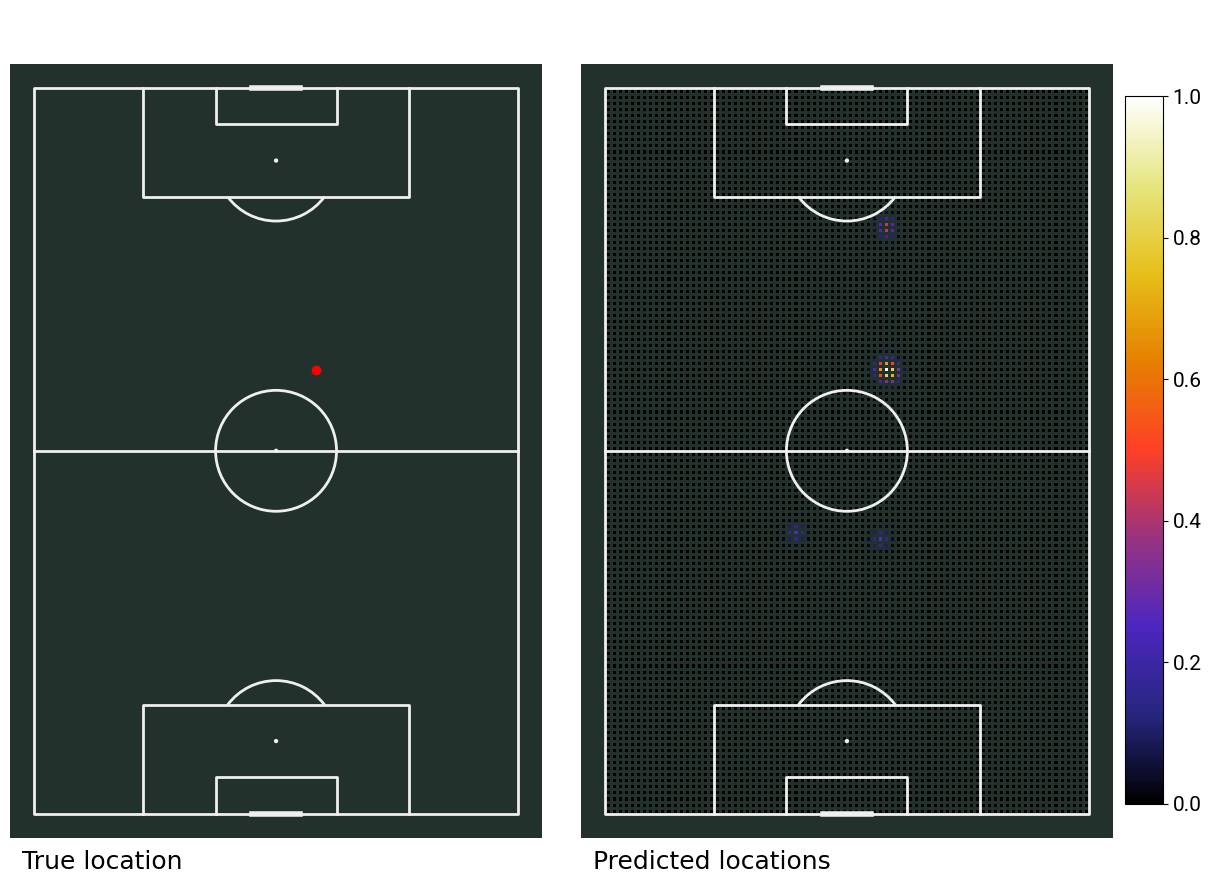

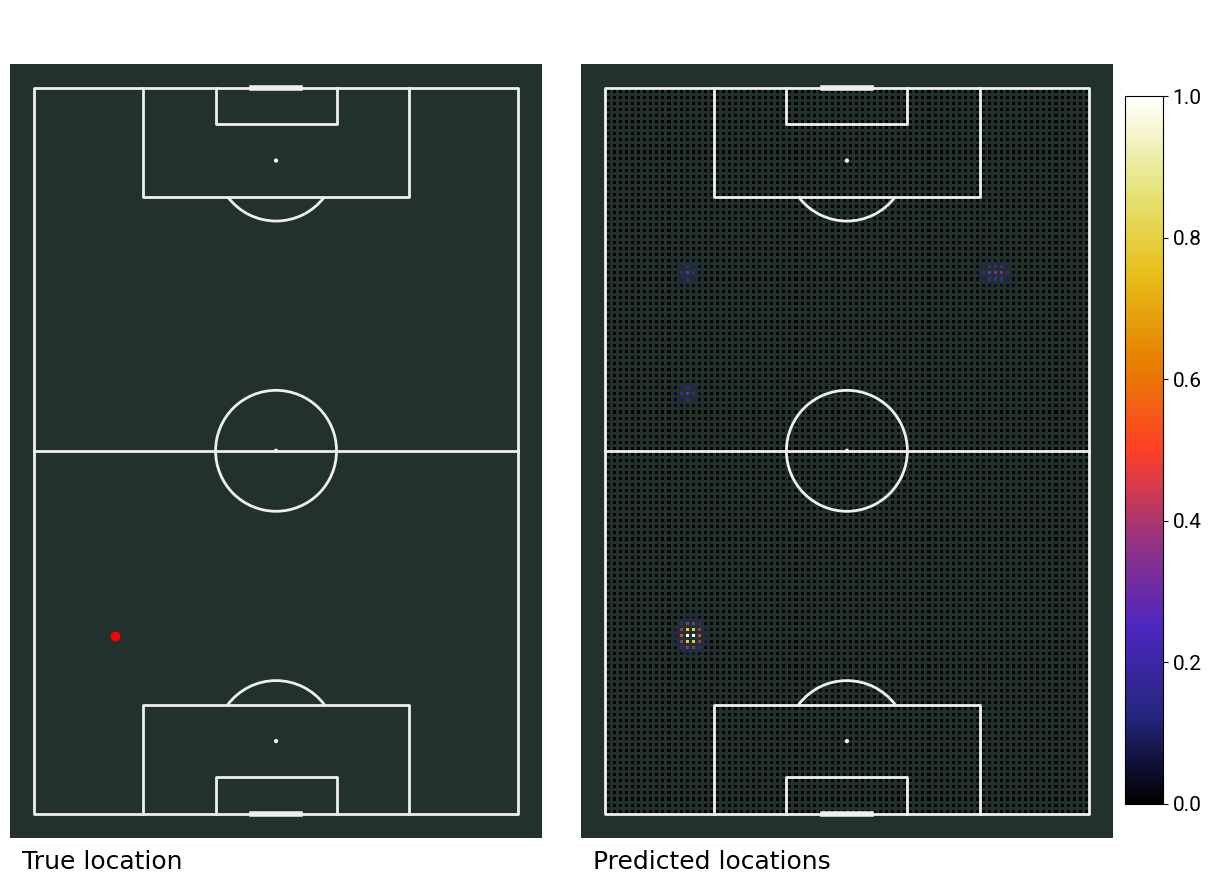

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mplsoccer import Pitch, FontManager, VerticalPitch
from scipy.ndimage import gaussian_filter
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

FACTOR = 4 / 3

for i, pred in enumerate(predictions):
    pred, label = pred
    true_x, true_y = get_location(int(label[0]))
    predicted_locations = np.array(pred[0].cpu())

    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2,
                pitch_color='#22312b', line_color='#efefef')

    # Draw
    fig, axs = pitch.grid(ncols=2,endnote_height=0.03, endnote_space=0,
                        # leave some space for the colorbar
                        grid_width=0.88, left=0.025,
                        title_height=0.06, title_space=0,
                        axis=False,
                        grid_height=0.86)
    # fig.set_facecolor('#22312b')
    fig.set_facecolor('white')

    for idx, ax in enumerate(axs['pitch'].flat):
        if idx == 0:
            annotation_string = (f'True location')
            ax.scatter(true_y * FACTOR, true_x * FACTOR, color="red")
            ax.text(-2, -8, annotation_string, ha='left', va='center', fontsize=18)

        if idx == 1:
            ax.text(-2, -8, f"Predicted locations", ha='left', va='center', fontsize=18)


            predicted_coords = [get_location(x) for x in predicted_locations]
            values = [gradient(x) for x in range(len(predicted_coords))]
            x = list(zip(*predicted_coords))[0]
            y = list(zip(*predicted_coords))[1]

            bin_statistic = pitch.bin_statistic([(xi * FACTOR)  for xi in x], [(yi * FACTOR)  for yi in y], values=values, statistic='count', bins=(120, 80))
            bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

            # Normalize count values
            count_norm = colors.Normalize(vmin=0, vmax=bin_statistic['statistic'].max())
            bin_statistic['statistic'] = count_norm(bin_statistic['statistic'])
            pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='CMRmap', edgecolors='#22312b')

            # Add cbar
            ax_cbar = fig.add_axes((0.915, 0.093, 0.03, 0.786))
            cbar = plt.colorbar(pcm, cax=ax_cbar)
            cbar.outline.set_edgecolor('black')
            cbar.ax.yaxis.set_tick_params(color='black')
            plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
            robotto_regular = FontManager()
            for label in cbar.ax.get_yticklabels():
                label.set_fontproperties(robotto_regular.prop)
                label.set_fontsize(15)

            # Endnote and title
            axs['endnote'].text(1, 0.5, '', va='center', ha='right', fontsize=15,
                                fontproperties=robotto_regular.prop, color='#dee6ea')
            ax_title = axs['title'].text(0.5, 0.5, f"",
                                        color='black',
                                        va='center', ha='center',
                                        fontproperties=robotto_regular.prop, fontsize=30)

            pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                                ['#15242e', '#4393c4'], N=10)

    plt.show()